# Imaginary Soundscape Demo Code

## Before you try ...

- please download this zipped data file and unzip it into the same directory as this notebook: 
https://github.com/Kajiyu/ImaginarySoundscapeDemo/releases/download/v1.0.0/data.zip

## Additional Information

### References

- Imaginary Soundscape: http://imaginarysoundscape2.qosmo.jp/
- the original demo (Chrome and Firefox are only available.) : http://imaginarysoundscape.qosmo.jp/
- the original paper: https://nips2017creativity.github.io/doc/Imaginary_Soundscape.pdf


### Model
![Model](https://github.com/Kajiyu/ImaginarySoundscapeDemo/raw/master/assets/model.jpg)

### Other references
- Our model is based on MIT's SoundNet: http://soundnet.csail.mit.edu/

## Dependencies

In [1]:
import warnings
warnings.filterwarnings('ignore')
import os, sys
import shutil
import glob
import json
import collections
import tensorflow as tf
import numpy as np
import librosa
import random
from scipy.stats import entropy

import keras
from keras.models import Model, load_model
import keras.backend as K
from keras.applications.mobilenet import MobileNet
from keras.preprocessing import image
from IPython.display import Audio, Image, display_jpeg, display

Using TensorFlow backend.


## Function Definitions

In [2]:
def preprocess_image(x):
    x /= 255.
    x -= 0.5
    x *= 2.
    return x

In [3]:
def get_image_features(model, filepath):
    img = image.load_img(filepath, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_image(x)
    preds = model.predict(x)[0]
    return preds

In [4]:
def get_sound_features(model,filepath):
    x, sr = librosa.load(filepath)
    print("========================")
    print(x[1000:2000])
    print("========================")
    x = x * 255.0
    x = np.reshape(x, (1, x.shape[0], 1, 1))
    x[x < -255.] = -255.
    x[x > 255.] = 255.
    assert np.max(x) < 256., "It seems this audio contains signal that exceeds 256"
    assert np.min(x) > -256., "It seems this audio contains signal that exceeds -256 " + str(np.min(x)) + " : " + filepath
    print("========================")
    print(x[1000:2000])
    print("========================")
    _y_pred = model.predict(x)
    feature =  _y_pred[0][0][0][0]
    print(feature)
    return feature

In [5]:
def get_topk_songs(img_feature, song_features, k=3):
    distances = []
    for i in range(len(song_features)):
        distance = entropy(img_feature, song_features[i])
        distances.append(distance)
    topk_indecies = np.argsort(distances)[:k]
    return topk_indecies

In [6]:
def create_sound_libs(
    soundnet_model,
    query="./data/sound_samples/*.mp3",
    out_json_path="./data/sounds.json",
    out_npy_path='./data/song_features.npy'
):
    mp3_files = glob.glob(query)
    output_dict = {"mp3":[]}
    for i in range(len(mp3_files)):
        x, sr = librosa.load(mp3_files[i])
        if len(x) > 230000:
            output_dict["mp3"].append({"filepath":mp3_files[i], "index":str(i)})
    with open(out_json_path, "w")  as f:
        json.dump(output_dict, f, ensure_ascii=False, indent=4, sort_keys=True, separators=(',', ': '))
    song_features = []
    for item in output_dict["mp3"]:
#         check with our values here:
        i_feature = get_sound_features(soundnet_model,item['filepath'])
        song_features.append(i_feature)
    song_features = np.array(song_features)
    print("Sound npy shape:", song_features.shape)
    np.save(out_npy_path, song_features)
    return (output_dict, song_features)

# How to

## 1. Load SoundNet and ImageNet models

In [8]:
soundnet = load_model("./data/models/soundnet.hdf5")
print(soundnet.summary())
imagenet = MobileNet(include_top=True, weights='imagenet') # using MobileNet

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, 1, 1)   0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, None, 1, 1)   0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, 1, 16)  1040        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, 1, 16)  64          conv2d_1[0][0]                   
____________________________________________________________________________________________

## 2. Create sound features using SoundNet model

- npy file: features of sounds pre-calculated by SoundNet
- json file: including ...
    - filepath: the path of each sound file
    - index: the index of each sound file at the npy array

In [9]:
# create sound features using SoundNet model
(mp3_files, sound_features) = create_sound_libs(soundnet)

print("#of mp3 files", len(mp3_files['mp3']))

[-1.52587891e-04 -9.15527344e-05 -6.10351562e-05 -3.05175781e-05
 -6.10351562e-05 -1.22070312e-04 -1.83105469e-04 -9.15527344e-05
  0.00000000e+00  0.00000000e+00 -6.10351562e-05 -1.52587891e-04
 -1.52587891e-04 -6.10351562e-05  6.10351562e-05  9.15527344e-05
  0.00000000e+00 -1.22070312e-04 -1.83105469e-04 -1.52587891e-04
 -6.10351562e-05  0.00000000e+00  0.00000000e+00  3.05175781e-05
  0.00000000e+00 -6.10351562e-05 -9.15527344e-05 -1.52587891e-04
 -1.83105469e-04 -2.74658203e-04 -2.13623047e-04 -1.52587891e-04
 -1.52587891e-04 -3.05175781e-05  1.22070312e-04  0.00000000e+00
 -6.10351562e-05  9.15527344e-05  9.15527344e-05  6.10351562e-05
 -3.05175781e-05 -9.15527344e-05  3.05175781e-05  6.10351562e-05
 -9.15527344e-05 -1.22070312e-04 -2.44140625e-04 -3.35693359e-04
 -3.05175781e-04 -9.15527344e-05  1.83105469e-04  2.74658203e-04
  1.22070312e-04  9.15527344e-05  9.15527344e-05  0.00000000e+00
 -9.15527344e-05 -1.22070312e-04  1.52587891e-04  5.49316406e-04
  4.27246094e-04 -1.22070

[4.91411374e-05 5.45736228e-04 6.64249295e-04 1.50629232e-04
 3.11097509e-04 1.43010708e-04 1.88816266e-04 3.76500539e-04
 1.68037906e-04 1.85414974e-04 5.86266979e-05 2.70570803e-04
 1.65409700e-04 1.58590599e-04 2.83456233e-04 1.02118291e-04
 1.39084645e-04 1.50415770e-04 2.39085042e-04 9.42608167e-05
 6.95642448e-05 3.39400605e-04 3.72899463e-04 4.94801730e-04
 8.56029437e-05 3.84309315e-05 1.56391689e-04 5.90958953e-05
 7.28378291e-05 2.56328669e-04 4.07346743e-05 1.06283071e-04
 5.17544577e-05 1.29878244e-04 1.97374349e-04 8.05817326e-05
 2.51810387e-04 1.98435901e-05 7.11467437e-05 1.03684630e-04
 1.17550378e-04 3.35786026e-05 4.91567444e-05 2.58813016e-05
 8.90660522e-05 4.54867768e-05 1.14243441e-04 6.23136511e-05
 3.60790800e-05 6.67552158e-05 2.43207469e-04 5.48823446e-04
 4.28132516e-05 4.82152536e-05 3.15738398e-05 1.13833812e-04
 4.06789077e-05 3.35100012e-05 2.95730802e-04 1.53378642e-04
 1.88120699e-04 7.07703584e-05 3.65194646e-05 4.00987083e-05
 1.05646272e-04 1.648322

[4.64149372e-04 2.60323938e-03 3.11711314e-03 1.41353032e-03
 3.06179072e-03 2.21405365e-03 5.18227648e-03 4.96512337e-04
 6.30035473e-04 1.11356180e-03 1.53542685e-04 2.00217110e-04
 3.24980734e-04 4.49939806e-04 3.39065213e-04 2.53770413e-04
 2.83558009e-04 4.85409051e-04 8.89483490e-04 2.92076380e-04
 9.47833643e-04 8.58823827e-04 8.69447831e-04 1.98159018e-03
 5.51034696e-04 3.14601464e-04 3.61780636e-04 2.39759363e-04
 1.11053872e-04 4.25556529e-04 2.91387521e-04 2.22353483e-04
 3.14883015e-04 2.82218144e-03 1.58863945e-03 5.20671310e-04
 1.46886357e-03 1.53105124e-04 1.67914230e-04 4.15141491e-04
 1.67851947e-04 1.83278913e-04 2.99990352e-04 1.61624659e-04
 1.57383110e-04 1.64005178e-04 2.39888614e-04 1.43389858e-04
 3.77218355e-04 7.64168333e-04 2.17607617e-03 5.53173188e-04
 2.61140813e-04 1.93453583e-04 1.52726891e-04 2.24832853e-04
 9.63330167e-05 2.50153156e-04 1.58741127e-03 2.31530779e-04
 2.02802607e-04 2.00675044e-04 2.29730300e-04 2.42141337e-04
 1.46908453e-04 1.997956

[ 0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.00000

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

[8.29055381e-04 7.06988329e-04 8.60921456e-04 2.53452949e-04
 7.64191791e-04 2.63587222e-04 9.39837075e-04 6.26473629e-04
 2.37971151e-04 6.53306255e-04 6.58738063e-05 9.94401562e-05
 1.04021841e-04 1.61996082e-04 8.67871931e-05 9.24043125e-05
 8.26459727e-05 1.23694626e-04 3.33752774e-04 1.23542719e-04
 2.31508006e-04 3.67201777e-04 3.03979992e-04 6.84217317e-04
 1.78497590e-04 1.28603657e-04 1.29530017e-04 1.17461539e-04
 1.17387121e-04 4.57054091e-04 6.07623770e-05 1.30236047e-04
 1.06797313e-04 6.86422398e-04 1.07198313e-03 1.11819354e-04
 3.00027634e-04 5.60759108e-05 1.45516911e-04 2.44257826e-04
 7.49157261e-05 7.26118160e-05 9.48381494e-05 9.45336578e-05
 6.65668995e-05 1.55861213e-04 8.19703273e-05 6.96895295e-05
 1.21991834e-04 1.89146667e-04 4.38192306e-04 8.68309930e-04
 1.13460192e-04 1.03445098e-04 8.99617371e-05 9.80699479e-05
 9.22864783e-05 4.10497232e-05 3.18838807e-04 2.63342605e-04
 3.02902772e-04 3.62473365e-04 2.46082607e-04 3.61879123e-04
 1.32970046e-04 2.862714

[ 0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00 -3.0517578e-05  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  3.0517578e-05  3.0517578e-05  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  3.0517578e-05  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00 -3.0517578e-05 -3.0517578e-05
 -3.0517578e-05 -3.0517578e-05  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  3.05175

[2.51989695e-04 7.69878156e-04 4.65604448e-04 1.62081240e-04
 7.77646201e-04 1.95181667e-04 6.54687348e-04 5.89623582e-04
 3.49330105e-04 1.86706107e-04 6.12190706e-05 1.44805716e-04
 1.19007549e-04 1.38943506e-04 1.33670561e-04 6.98563235e-05
 9.72455964e-05 1.78840361e-04 3.06493224e-04 1.63722652e-04
 9.51532929e-05 2.08029931e-04 1.46533057e-04 3.70420166e-04
 1.60796699e-04 9.86210216e-05 1.10311717e-04 1.44666308e-04
 1.63857447e-04 1.00039656e-03 6.20305509e-05 1.51522414e-04
 9.85247680e-05 2.45958741e-04 4.68979328e-04 6.75874617e-05
 2.08090947e-04 5.60131666e-05 2.22122166e-04 8.21810536e-05
 9.84684011e-05 5.77174651e-05 9.50098474e-05 8.82820823e-05
 6.82131795e-05 2.19670925e-04 1.16750489e-04 1.51840359e-04
 9.29090165e-05 9.98881733e-05 3.09514842e-04 8.89000890e-04
 1.36006711e-04 1.09944078e-04 1.05527492e-04 1.43851998e-04
 1.95245244e-04 5.16493565e-05 1.75533292e-04 2.43361283e-04
 3.80999147e-04 2.76372884e-04 1.48055740e-04 3.91902111e-04
 2.37862943e-04 1.430293

[ 0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.00000

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

[1.22099547e-04 1.02188077e-03 5.41757618e-04 3.08317452e-04
 1.09976286e-03 3.83044331e-04 6.87596737e-04 6.39447011e-04
 6.30846072e-04 2.07498349e-04 1.71627253e-04 2.96092854e-04
 2.50190904e-04 2.66548799e-04 2.00560375e-04 1.54675698e-04
 2.75554194e-04 2.88729265e-04 4.25414764e-04 2.87873088e-04
 1.46136648e-04 2.84613721e-04 2.01774776e-04 4.69679711e-04
 2.30034406e-04 1.19236756e-04 1.92942520e-04 1.33410911e-04
 1.45885031e-04 1.34548882e-03 9.21058090e-05 2.64923816e-04
 1.69296589e-04 3.77136952e-04 3.93300696e-04 1.46739971e-04
 4.09023196e-04 1.12519629e-04 4.04255989e-04 1.39929078e-04
 1.46578357e-04 8.76974227e-05 1.05400279e-04 1.11847163e-04
 9.88518223e-05 1.65195379e-04 1.70123472e-04 1.92473875e-04
 7.55010115e-05 9.63079510e-05 2.07316960e-04 8.59903172e-04
 1.48174338e-04 1.20267796e-04 9.83836944e-05 1.87274723e-04
 2.49101809e-04 7.73800857e-05 1.79468436e-04 2.76618433e-04
 3.03957611e-04 2.87843170e-04 1.50979351e-04 3.44423024e-04
 3.57825571e-04 2.695264

[]
[1.43735306e-05 4.15977935e-04 4.94878856e-04 2.97911407e-04
 9.97223309e-04 2.39746718e-04 3.63326544e-04 2.38772409e-04
 2.48760989e-05 1.67128437e-05 8.89714283e-06 1.78977389e-05
 2.14782667e-05 1.53809651e-05 1.83980919e-05 1.37208126e-05
 1.72008113e-05 1.90802257e-05 2.42944679e-05 1.81035648e-05
 8.64730555e-06 3.30522635e-05 4.36440932e-05 7.45094367e-05
 9.33200772e-06 1.26492259e-05 2.36021770e-05 1.21504963e-05
 2.76123537e-05 1.08557491e-04 1.19995966e-05 4.09980348e-05
 2.34728832e-05 1.80183473e-04 1.62715776e-04 1.93778124e-05
 7.29423409e-05 5.77494529e-06 1.89481070e-05 1.92419811e-05
 1.68895440e-05 6.05297964e-06 1.08713157e-05 1.64731591e-05
 1.03037937e-05 3.83636434e-05 2.27788132e-05 2.75233597e-05
 9.70991732e-06 1.01004725e-05 3.12074517e-05 1.01518200e-03
 1.12154239e-05 1.60049785e-05 1.81507585e-05 4.27844352e-05
 2.37516360e-05 6.07607944e-06 2.76867941e-05 1.02388156e-04
 1.57562215e-04 2.66918232e-05 1.97631707e-05 5.55734805e-05
 5.54151884e-05 1.139

[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.000

[ 0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.00000

[6.62434497e-04 6.84765982e-04 1.09718379e-03 3.84388957e-04
 9.41955426e-04 8.79100116e-04 1.53236149e-03 6.37258810e-04
 8.10224621e-04 2.08980357e-03 3.92709539e-04 6.40410406e-04
 9.06789093e-04 7.62408716e-04 5.91674994e-04 5.59006701e-04
 5.08782919e-04 7.36561953e-04 2.22319341e-03 3.68821842e-04
 1.03804586e-03 2.59804889e-03 2.20975187e-03 2.39303289e-03
 1.14762574e-03 2.24690302e-04 4.51140484e-04 3.86795960e-04
 1.50522421e-04 3.42976302e-04 3.29020259e-04 3.60927370e-04
 4.38312680e-04 8.76143517e-04 1.78705656e-03 5.07991645e-04
 1.02667965e-03 2.86863273e-04 3.14533972e-04 6.07935945e-04
 3.10624891e-04 3.81876598e-04 6.88128232e-04 3.00640153e-04
 3.02554166e-04 3.84298619e-04 4.09895234e-04 2.76306731e-04
 4.97739064e-04 1.10446906e-03 2.07621325e-03 5.47574891e-04
 4.55638568e-04 2.56580010e-04 3.30707961e-04 3.32488707e-04
 1.87452562e-04 2.64883827e-04 1.79182005e-03 4.23547288e-04
 3.09307681e-04 1.96809386e-04 2.94315658e-04 3.68868641e-04
 3.52949835e-04 7.863427

[-1.52587891e-04 -3.05175781e-05  3.05175781e-05  0.00000000e+00
  1.83105469e-04  3.35693359e-04  1.52587891e-04 -3.05175781e-05
 -3.05175781e-05 -1.52587891e-04 -2.44140625e-04 -2.44140625e-04
 -4.27246094e-04 -5.18798828e-04 -4.27246094e-04 -4.57763672e-04
 -4.57763672e-04 -1.22070312e-04  3.05175781e-05 -3.05175781e-05
  0.00000000e+00 -9.15527344e-05 -9.15527344e-05  0.00000000e+00
 -9.15527344e-05 -1.22070312e-04 -9.15527344e-05 -1.83105469e-04
  0.00000000e+00  2.44140625e-04  1.22070312e-04  1.22070312e-04
  1.52587891e-04 -1.83105469e-04 -3.96728516e-04 -5.49316406e-04
 -6.71386719e-04 -4.88281250e-04 -5.49316406e-04 -7.01904297e-04
 -2.74658203e-04  1.83105469e-04  2.44140625e-04  5.18798828e-04
  7.93457031e-04  5.79833984e-04  4.57763672e-04  4.57763672e-04
  3.05175781e-04  9.15527344e-05  0.00000000e+00  0.00000000e+00
 -3.05175781e-05 -9.15527344e-05  1.83105469e-04  4.57763672e-04
  2.74658203e-04 -6.10351562e-05 -2.13623047e-04 -2.13623047e-04
 -9.15527344e-05  3.05175

[9.32725452e-05 2.84747599e-04 2.55799270e-04 1.37706433e-04
 4.24233527e-04 1.35925962e-04 3.64683452e-04 4.34542540e-04
 1.64923622e-04 3.16940539e-04 8.44874958e-05 1.47846105e-04
 1.58444353e-04 1.82454605e-04 1.41443452e-04 1.34023416e-04
 1.18231605e-04 1.53209825e-04 2.82230874e-04 1.59339746e-04
 1.09742716e-04 2.76340550e-04 2.98168132e-04 6.03455759e-04
 1.89458529e-04 5.40247493e-05 7.89958431e-05 4.88267797e-05
 4.42507626e-05 2.79460684e-04 5.30968391e-05 9.97210082e-05
 5.39916073e-05 1.42114906e-04 2.47327785e-04 7.73662978e-05
 2.54244922e-04 7.55294750e-05 5.63471003e-05 1.47113271e-04
 9.20490565e-05 4.94531960e-05 9.19067825e-05 6.01067550e-05
 4.88660953e-05 1.04014398e-04 1.03731632e-04 8.77539933e-05
 1.37232957e-04 2.26487755e-04 4.89865139e-04 1.02393876e-03
 5.59883774e-05 4.11100373e-05 6.59098368e-05 1.03106824e-04
 6.28875860e-05 3.05891735e-05 1.73762179e-04 1.43839352e-04
 1.64524536e-04 2.24873555e-04 1.35235037e-04 1.27298976e-04
 1.07281528e-04 6.523590

[3.72878654e-04 1.10525836e-03 3.82832572e-04 1.64503159e-04
 7.81286624e-04 2.03712319e-04 5.54534898e-04 7.30109809e-04
 1.08017190e-03 5.64773101e-04 9.39310339e-05 2.57921551e-04
 2.51609192e-04 2.17339650e-04 2.67915253e-04 1.56865863e-04
 2.35645421e-04 2.23611569e-04 1.03459274e-03 1.44153455e-04
 2.41748086e-04 1.10021257e-03 6.89892331e-04 1.76386267e-03
 2.78932363e-04 9.84115613e-05 1.40647113e-04 1.37214491e-04
 1.04349747e-04 1.10223843e-03 1.43990153e-04 3.70016031e-04
 2.13951236e-04 2.12066821e-04 4.63238481e-04 8.42879308e-05
 2.54186947e-04 2.68052645e-05 1.82972537e-04 9.44288840e-05
 1.13614406e-04 4.93405278e-05 1.17209725e-04 5.96598620e-05
 5.87036775e-05 1.41502096e-04 1.64606274e-04 1.72477521e-04
 9.16576901e-05 1.22154030e-04 4.19130956e-04 5.33412036e-04
 9.17716607e-05 1.30332861e-04 9.89779946e-05 2.03825315e-04
 1.28215121e-04 3.60880076e-05 3.77237651e-04 3.68200912e-04
 2.94608180e-04 2.00761482e-04 1.36449671e-04 2.68382486e-04
 2.68251490e-04 1.778946

[1.29847060e-04 5.83880348e-04 1.20923237e-03 5.02821757e-04
 8.84178851e-04 3.94177885e-04 7.89968530e-04 3.00116895e-04
 2.08270183e-04 2.66900082e-04 7.68966638e-05 1.05628598e-04
 1.36668736e-04 1.30881555e-04 1.38291871e-04 1.13808419e-04
 9.86208033e-05 1.85971061e-04 2.64391158e-04 1.39777112e-04
 2.73593294e-04 1.99262169e-04 2.64046597e-04 3.74447525e-04
 1.90560910e-04 3.70621929e-05 1.10944136e-04 4.27571722e-05
 4.20469805e-05 3.44860688e-04 6.15890604e-05 1.02088408e-04
 5.67243005e-05 4.55833215e-04 3.43305932e-04 8.26437536e-05
 2.43550647e-04 2.73797286e-05 7.29141175e-05 1.04083352e-04
 7.72974454e-05 2.56937474e-05 4.57256283e-05 3.19410901e-05
 3.64006883e-05 8.78801948e-05 8.53490346e-05 4.88989608e-05
 4.78951442e-05 1.26404484e-04 3.10783653e-04 5.27701515e-04
 4.40371514e-05 4.31210901e-05 3.89543748e-05 8.93169854e-05
 3.99723722e-05 2.26794327e-05 3.18394683e-04 1.41317971e-04
 1.32758301e-04 7.86552991e-05 6.21377330e-05 1.00882586e-04
 1.10437795e-04 2.008546

[2.97917897e-04 2.31680763e-03 1.82328373e-03 1.73203100e-03
 3.65158846e-03 1.61997147e-03 5.05909277e-03 5.14689251e-04
 2.52915750e-04 3.69018846e-04 1.05172825e-04 2.45821808e-04
 2.09357007e-04 2.66745425e-04 2.99647800e-04 2.24153322e-04
 1.64676283e-04 2.95690144e-04 4.16213035e-04 2.07933830e-04
 4.51827509e-04 2.17805980e-04 3.29536502e-04 7.88847217e-04
 3.20675346e-04 1.87915633e-04 3.60702164e-04 1.63123303e-04
 1.21594210e-04 1.23054546e-03 3.20004649e-04 2.07655990e-04
 3.56101256e-04 2.74677807e-03 9.19518410e-04 5.59415261e-04
 1.61684945e-03 2.88776180e-04 2.69611919e-04 8.39263317e-04
 1.84944307e-04 3.31761490e-04 2.38775698e-04 3.40995641e-04
 1.79611554e-04 1.90211053e-04 2.64006841e-04 2.84254667e-04
 8.43243790e-04 6.18227408e-04 1.87741150e-03 9.15371813e-04
 2.07541860e-04 1.17309413e-04 2.14133717e-04 2.87041970e-04
 1.31291628e-04 1.41410012e-04 9.54856456e-04 3.01081192e-04
 3.35342134e-04 5.55486244e-04 5.63373207e-04 4.22408833e-04
 3.18759034e-04 7.046291

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

[1.50811489e-14 4.14795295e-15 4.38535850e-15 3.09874341e-15
 4.68678091e-12 2.62630933e-12 2.97044900e-14 4.02538350e-11
 1.79298119e-18 3.34167711e-14 1.55696948e-15 4.54100663e-16
 8.41593471e-15 3.15980965e-13 2.50792469e-13 1.06302194e-14
 9.21084606e-13 1.05363953e-14 3.77827618e-14 3.39759492e-12
 6.50828684e-17 4.13069222e-16 3.88715483e-11 5.42239198e-10
 3.51235881e-20 2.50439929e-11 1.41059725e-11 5.30424316e-10
 2.24349410e-08 6.38681138e-14 1.45365856e-13 2.97995309e-11
 2.99026673e-13 4.92222162e-14 1.01093327e-07 2.80320922e-16
 3.63548777e-14 1.28949807e-23 1.01881296e-12 1.70353043e-16
 5.68892711e-11 8.41522005e-17 5.63806727e-12 3.17272115e-13
 1.53035828e-13 1.99019006e-08 1.48011117e-10 2.19550224e-12
 6.85634260e-16 2.05922159e-15 3.12007906e-13 9.43691791e-10
 1.63834265e-14 7.55813884e-11 3.03085668e-10 1.37657208e-09
 6.59112209e-10 1.92952665e-14 1.18110903e-12 5.04570835e-07
 5.82430104e-04 1.24725841e-10 7.70377095e-11 4.27986847e-11
 3.58852420e-10 4.207859

[ 0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00 -3.0517578e-05
 -3.0517578e-05  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
 -3.0517578e-05 -3.0517578e-05  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.00000

[4.45887767e-04 9.85657098e-04 1.60031964e-03 7.45041878e-04
 1.49842014e-03 5.42363501e-04 1.28228462e-03 8.62938061e-04
 9.47425840e-04 8.88041279e-04 2.02987532e-04 3.66680295e-04
 2.39544475e-04 4.41276410e-04 3.43350286e-04 3.75723088e-04
 2.25048600e-04 4.18120850e-04 9.76355746e-04 4.41374577e-04
 3.29867849e-04 1.31570990e-03 9.96974297e-04 1.51698187e-03
 4.29716310e-04 1.31878754e-04 3.22879438e-04 1.82169635e-04
 1.42277073e-04 8.35012004e-04 8.22221773e-05 2.85314600e-04
 1.34498172e-04 4.55115049e-04 7.30521046e-04 1.80457355e-04
 4.35302762e-04 9.76238007e-05 2.28987847e-04 2.29455880e-04
 1.61138960e-04 6.24799140e-05 1.07315485e-04 9.36193755e-05
 8.96656129e-05 1.61848046e-04 1.91985979e-04 1.42531644e-04
 9.88187021e-05 1.59570278e-04 3.85347987e-04 6.83987688e-04
 1.46649036e-04 1.32040092e-04 1.16911673e-04 2.83545232e-04
 1.43283745e-04 5.16451510e-05 6.45715161e-04 4.84821736e-04
 3.38616694e-04 1.47753555e-04 1.10232133e-04 3.46720219e-04
 3.77513992e-04 7.125567

[1.37932220e-04 7.96386856e-04 5.28187840e-04 4.05772793e-04
 1.13500969e-03 5.03895164e-04 9.97465104e-04 5.13687264e-04
 2.08747777e-04 2.14234344e-04 7.56922454e-05 2.59009685e-04
 1.82786098e-04 1.28034895e-04 1.71302905e-04 1.03404192e-04
 1.43698649e-04 1.65199250e-04 3.40240455e-04 1.38368239e-04
 9.37371224e-05 3.26854410e-04 2.65743030e-04 5.27578522e-04
 1.31831082e-04 5.65307419e-05 7.35248832e-05 6.53285606e-05
 7.44647186e-05 6.39627222e-04 7.52496708e-05 1.19222830e-04
 8.71248994e-05 3.29071772e-04 3.45834618e-04 7.24414422e-05
 2.88129173e-04 4.39177456e-05 1.76624220e-04 1.54641108e-04
 7.63847711e-05 5.75614722e-05 8.25441457e-05 9.32345574e-05
 5.53617901e-05 1.29439286e-04 9.98479009e-05 1.58117371e-04
 1.45883096e-04 1.15407100e-04 3.39547260e-04 1.01000909e-03
 7.04317572e-05 6.50180446e-05 7.18144875e-05 1.41584591e-04
 9.56399017e-05 3.02239878e-05 2.01028772e-04 2.08777157e-04
 2.30935504e-04 1.96357898e-04 1.14846160e-04 3.17607075e-04
 1.95430170e-04 3.048978

[ 0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.00000

[3.78043012e-04 2.52638292e-03 9.02054249e-04 7.20151991e-04
 1.39041780e-03 1.03564386e-03 1.23314420e-03 3.83589504e-04
 5.52358630e-04 5.15963126e-04 5.33874671e-04 7.06172665e-04
 9.44390427e-04 9.27947927e-04 9.13366908e-04 1.15287269e-03
 7.10230088e-04 9.49374866e-04 1.11433002e-03 5.98602754e-04
 8.75473372e-04 1.47447072e-03 1.25954300e-03 1.74331910e-03
 8.55992315e-04 2.55676423e-04 5.37333428e-04 3.62789200e-04
 1.60662501e-04 1.12585665e-03 4.83163138e-04 4.86900535e-04
 4.84477263e-04 6.57622295e-04 4.40457050e-04 6.44734711e-04
 8.96179932e-04 3.03089328e-04 3.25327128e-04 5.86014183e-04
 4.39792697e-04 3.73535993e-04 3.67636880e-04 2.48007738e-04
 2.61795096e-04 3.07054812e-04 5.87880670e-04 2.92407611e-04
 2.33428946e-04 5.29628829e-04 1.34602911e-03 6.70153240e-04
 5.12745057e-04 3.34252283e-04 2.29877493e-04 4.35815396e-04
 1.91859377e-04 1.79444134e-04 1.20852410e-03 4.48299426e-04
 3.50578310e-04 2.33986168e-04 2.55138730e-04 2.77718878e-04
 3.99216427e-04 6.897613

[-5.21850586e-03 -5.43212891e-03 -2.41088867e-03 -3.11279297e-03
 -5.00488281e-03 -1.92260742e-03  7.01904297e-04 -5.49316406e-04
 -7.01904297e-04  1.52587891e-04  1.22070312e-04  2.25830078e-03
  6.01196289e-03  5.92041016e-03  6.40869141e-04 -3.75366211e-03
 -2.96020508e-03 -9.46044922e-04 -1.52587891e-04  2.22778320e-03
  4.36401367e-03  2.71606445e-03  4.27246094e-04  1.22070312e-03
  2.50244141e-03  3.35693359e-04 -2.31933594e-03 -5.79833984e-04
  1.28173828e-03 -1.25122070e-03 -3.99780273e-03 -4.57763672e-03
 -4.60815430e-03 -3.32641602e-03  2.13623047e-04  5.34057617e-03
  7.69042969e-03  2.16674805e-03 -4.69970703e-03 -3.75366211e-03
  5.49316406e-04  8.54492188e-04 -1.22070312e-03 -1.64794922e-03
 -3.05175781e-04  3.05175781e-05 -9.15527344e-04 -9.46044922e-04
 -1.83105469e-04  2.07519531e-03  5.58471680e-03  5.00488281e-03
 -5.79833984e-04 -5.95092773e-03 -7.32421875e-03 -4.54711914e-03
 -3.87573242e-03 -8.20922852e-03 -8.88061523e-03 -4.48608398e-03
 -1.46484375e-03  3.81469

[ 0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.00000

[8.41609668e-04 6.14458928e-04 5.11284685e-04 1.68294646e-04
 5.83997637e-04 2.07986261e-04 7.81153678e-04 7.05019280e-04
 2.87628092e-04 5.07377961e-04 5.74406477e-05 1.08301385e-04
 1.29230917e-04 1.13712369e-04 1.31960551e-04 9.54155330e-05
 8.68572824e-05 1.63457647e-04 2.32421313e-04 1.19937024e-04
 1.23153121e-04 2.90233380e-04 2.98087718e-04 7.49716186e-04
 1.86145786e-04 1.00437610e-04 1.18448523e-04 9.86428349e-05
 1.14549322e-04 4.35334106e-04 8.62170345e-05 1.30222150e-04
 1.21390920e-04 4.73980763e-04 4.87042154e-04 1.39222364e-04
 3.76378739e-04 1.29662745e-04 1.27057021e-04 2.20464834e-04
 8.01328351e-05 6.50781367e-05 1.00122823e-04 1.16342504e-04
 9.23482366e-05 1.44943449e-04 1.05514897e-04 1.26240178e-04
 2.31823709e-04 3.00023239e-04 5.95664198e-04 1.04358094e-03
 1.24442173e-04 1.17755677e-04 1.54811132e-04 1.42483084e-04
 1.58881434e-04 6.31689254e-05 2.55050370e-04 2.35770684e-04
 3.27840535e-04 4.70835424e-04 2.85783055e-04 3.21755302e-04
 1.69325853e-04 1.699295

[2.36072647e-05 2.16813176e-04 2.13880630e-04 1.33760128e-04
 4.17374278e-04 1.34952585e-04 1.47312574e-04 3.86828033e-04
 8.96321726e-05 3.59803198e-05 5.34928076e-05 6.16101388e-05
 7.66250523e-05 5.92226570e-05 4.48894025e-05 3.41122977e-05
 6.05360001e-05 6.02499240e-05 8.63772366e-05 7.95882079e-05
 2.12739815e-05 8.24323870e-05 9.10745948e-05 1.68709899e-04
 4.04253769e-05 3.12549237e-05 3.80918900e-05 3.02627759e-05
 5.60398548e-05 2.13286781e-04 2.69686097e-05 1.10913999e-04
 4.25335602e-05 9.87844833e-05 1.22617043e-04 2.57902193e-05
 1.03779486e-04 2.33354349e-05 6.35742108e-05 3.39991748e-05
 6.24659006e-05 2.34240433e-05 2.98768209e-05 4.09661734e-05
 3.84297527e-05 5.70939919e-05 6.22730950e-05 3.88709959e-05
 2.44721723e-05 1.91107174e-05 5.63232570e-05 1.00509531e-03
 2.60345587e-05 3.25247820e-05 4.42722558e-05 7.60618568e-05
 5.25950672e-05 1.16014435e-05 3.38005775e-05 1.60358933e-04
 1.67048041e-04 7.78034446e-05 4.58313116e-05 1.28009968e-04
 1.11940310e-04 5.259479

[-6.10351562e-05 -3.05175781e-05  9.15527344e-05  3.05175781e-05
  3.05175781e-05  9.15527344e-05  9.15527344e-05  9.15527344e-05
  1.52587891e-04  6.10351562e-05 -1.83105469e-04 -2.44140625e-04
 -6.10351562e-05  9.15527344e-05  3.05175781e-05 -1.52587891e-04
 -1.52587891e-04 -9.15527344e-05  6.10351562e-05  1.83105469e-04
  3.05175781e-05  0.00000000e+00  1.52587891e-04  1.83105469e-04
  1.22070312e-04 -9.15527344e-05 -2.13623047e-04 -6.10351562e-05
 -1.22070312e-04 -2.13623047e-04 -2.44140625e-04 -3.05175781e-04
  6.10351562e-05  3.35693359e-04 -6.10351562e-05  0.00000000e+00
  3.66210938e-04  1.52587891e-04  1.83105469e-04  5.18798828e-04
  4.57763672e-04  3.96728516e-04  4.27246094e-04  3.96728516e-04
  3.35693359e-04  3.05175781e-04  5.49316406e-04  7.32421875e-04
  7.01904297e-04  7.32421875e-04  4.57763672e-04  3.66210938e-04
  5.18798828e-04  9.15527344e-05 -1.52587891e-04  3.05175781e-05
  0.00000000e+00  2.44140625e-04  5.18798828e-04  4.27246094e-04
  7.32421875e-04  1.00708

[-8.54492188e-04 -1.73950195e-03 -2.80761719e-03 -3.32641602e-03
 -2.99072266e-03 -2.07519531e-03 -1.06811523e-03 -3.05175781e-04
  4.27246094e-04  1.34277344e-03  2.07519531e-03  1.89208984e-03
  6.40869141e-04 -7.62939453e-04 -9.46044922e-04  3.96728516e-04
  2.22778320e-03  3.14331055e-03  2.65502930e-03  1.58691406e-03
  8.85009766e-04  7.62939453e-04  7.32421875e-04  2.44140625e-04
 -3.35693359e-04 -2.13623047e-04  8.54492188e-04  2.19726562e-03
  2.71606445e-03  1.55639648e-03 -8.23974609e-04 -2.83813477e-03
 -3.11279297e-03 -1.92260742e-03 -8.54492188e-04 -7.62939453e-04
 -9.15527344e-04 -5.79833984e-04 -2.74658203e-04 -8.54492188e-04
 -2.10571289e-03 -3.11279297e-03 -3.23486328e-03 -2.47192383e-03
 -1.25122070e-03 -3.66210938e-04 -5.18798828e-04 -1.40380859e-03
 -1.43432617e-03  2.13623047e-04  2.47192383e-03  3.63159180e-03
  3.23486328e-03  1.92260742e-03  3.66210938e-04 -1.09863281e-03
 -2.31933594e-03 -2.99072266e-03 -2.71606445e-03 -1.25122070e-03
  1.19018555e-03  3.26538

[4.26177488e-04 5.91641758e-04 4.55132627e-04 1.99263435e-04
 6.55394746e-04 2.00052295e-04 5.05135104e-04 4.71289852e-04
 1.44577338e-04 2.61357316e-04 6.80817029e-05 7.27646038e-05
 8.38537599e-05 1.03063372e-04 1.05826148e-04 1.01410820e-04
 8.23557712e-05 1.34232119e-04 1.95492845e-04 1.10432127e-04
 1.19877513e-04 2.82967056e-04 2.85171700e-04 6.10295858e-04
 1.28013999e-04 5.53884965e-05 7.72657295e-05 6.55122858e-05
 1.01105907e-04 6.41749590e-04 6.28994094e-05 1.43927595e-04
 7.93580621e-05 2.95523787e-04 3.84078594e-04 6.93531911e-05
 2.26780743e-04 3.62617757e-05 8.52368394e-05 1.19869743e-04
 5.92362994e-05 2.41628422e-05 3.59329133e-05 5.56756167e-05
 4.13902308e-05 8.86148337e-05 6.75548144e-05 9.49666210e-05
 7.14886410e-05 1.85602737e-04 4.18437558e-04 8.89039482e-04
 6.32941155e-05 7.63170683e-05 7.44031204e-05 1.39169992e-04
 7.87629178e-05 3.17990089e-05 2.06403318e-04 2.20484173e-04
 2.72607955e-04 2.26366101e-04 1.31241803e-04 1.86441059e-04
 1.79818409e-04 1.653689

[1.61344225e-17 2.29912742e-18 7.51437421e-18 1.94293290e-18
 9.99912992e-15 9.04197189e-16 1.33221317e-17 9.73336063e-14
 2.24496186e-24 4.29194531e-18 1.34470996e-20 2.27146413e-20
 2.90457234e-19 1.35291891e-17 2.85163568e-17 6.77482687e-19
 1.91448398e-16 1.50231509e-19 3.58618959e-19 1.37781013e-16
 2.81240222e-22 1.13874831e-21 1.94047015e-14 3.19326027e-13
 1.25188420e-26 9.13771825e-14 1.02241552e-14 5.80917953e-12
 1.07513665e-10 4.90527740e-18 4.48325647e-18 6.51768401e-16
 1.83719742e-17 8.27992242e-17 1.50480126e-08 6.22962523e-21
 3.41814500e-18 2.25749308e-30 2.09070006e-16 6.56825956e-21
 2.47443091e-14 8.66251568e-21 2.15869714e-15 3.97223512e-17
 6.64220076e-17 1.48971557e-10 4.60410247e-14 2.80827289e-16
 3.91540676e-20 5.38284843e-20 3.82278708e-17 1.39967573e-12
 1.82681234e-17 2.14280728e-13 8.57647015e-13 4.78911886e-13
 1.17970217e-12 8.17266026e-18 1.32364277e-16 5.28779021e-10
 1.52153725e-05 1.68017089e-13 1.48183508e-13 3.00969271e-14
 4.01952472e-14 1.079601

[6.35453762e-05 5.46001364e-04 5.00018126e-04 1.71493681e-04
 4.23378369e-04 2.11430146e-04 6.77299802e-04 5.07620338e-04
 1.45277576e-04 1.37246898e-04 3.77068463e-05 7.07905128e-05
 1.22765836e-04 6.06072717e-05 8.79914369e-05 6.10570278e-05
 9.59006647e-05 9.71422705e-05 1.82236457e-04 8.18296030e-05
 3.97652257e-05 1.62381053e-04 1.89496743e-04 4.53109387e-04
 5.17024928e-05 2.44498060e-05 4.29186439e-05 3.91895337e-05
 3.89436937e-05 1.81976633e-04 3.06551447e-05 5.38324493e-05
 3.38587415e-05 2.03821561e-04 1.52131732e-04 3.37409110e-05
 1.22790487e-04 1.58825496e-05 3.98215816e-05 5.63060312e-05
 4.63565157e-05 1.81643809e-05 3.53528994e-05 3.55037955e-05
 2.75461189e-05 5.59341242e-05 7.40668329e-05 5.65537739e-05
 5.05491116e-05 3.79865887e-05 1.19998105e-04 7.08330481e-04
 3.53501200e-05 4.51152700e-05 2.89820655e-05 8.66430782e-05
 5.47664786e-05 2.69425746e-05 9.60486650e-05 1.07737666e-04
 1.40958597e-04 6.74198673e-05 3.79543962e-05 7.21589895e-05
 1.02357568e-04 1.382976

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

[ 3.0517578e-05  3.0517578e-05  3.0517578e-05  3.0517578e-05
  3.0517578e-05  3.0517578e-05  0.0000000e+00  0.0000000e+00
  3.0517578e-05  3.0517578e-05  3.0517578e-05  3.0517578e-05
  0.0000000e+00  0.0000000e+00 -3.0517578e-05 -3.0517578e-05
 -3.0517578e-05  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
 -3.0517578e-05 -3.0517578e-05  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00 -3.0517578e-05  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.00000

[4.35037888e-04 9.66625055e-04 1.05990912e-03 4.07279993e-04
 1.19790982e-03 4.60785668e-04 1.49647577e-03 1.03648286e-03
 1.53504440e-03 1.99489621e-03 1.93420710e-04 3.31587420e-04
 3.53563577e-04 3.38620011e-04 2.98342755e-04 2.80569016e-04
 1.80376068e-04 2.80726003e-04 1.43132778e-03 1.96410547e-04
 4.88791440e-04 1.52826088e-03 8.42776499e-04 2.16387608e-03
 3.32565862e-04 5.87974464e-05 1.86799734e-04 9.62926279e-05
 5.72330173e-05 4.69801249e-04 1.47201514e-04 1.41242985e-04
 1.34581438e-04 6.36659097e-04 6.36264216e-04 1.94614811e-04
 4.10054519e-04 9.00124869e-05 1.52110908e-04 2.24162126e-04
 1.21280558e-04 7.14232301e-05 1.06947533e-04 8.77007697e-05
 6.51184164e-05 1.04168052e-04 1.47135128e-04 1.14896451e-04
 1.80540243e-04 2.06755256e-04 8.74706544e-04 4.16229974e-04
 1.09023247e-04 7.53830609e-05 8.14880841e-05 1.10430366e-04
 6.86578132e-05 3.39051076e-05 7.99748581e-04 1.46999941e-04
 1.32441768e-04 1.35878843e-04 1.40685501e-04 1.74150700e-04
 1.06699365e-04 5.407204

[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -3.05175781e-05
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -3.05175781e-05  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  3.05175781e-05  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -3.05175781e-05 -3.05175781e-05 -3.05175781e-05
 -3.05175781e-05  0.00000000e+00 -3.05175781e-05 -3.05175781e-05
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  3.05175781e-05  3.05175781e-05
  3.05175781e-05  3.05175781e-05  3.05175781e-05  3.05175781e-05
  3.05175781e-05  3.05175781e-05  3.05175781e-05  3.05175781e-05
  3.05175781e-05  0.00000

[2.9462110e-04 1.6044044e-03 8.2831946e-04 3.9811202e-04 9.2124077e-04
 7.9836725e-04 9.2632894e-04 5.4746174e-04 7.6190149e-04 8.0011791e-04
 3.0137229e-04 4.4952348e-04 5.2315230e-04 6.6639431e-04 7.0444093e-04
 6.1337324e-04 4.7895027e-04 7.8318361e-04 1.1498950e-03 4.8194898e-04
 7.3344284e-04 9.8061177e-04 7.6339045e-04 1.3679904e-03 1.4054682e-03
 5.0349772e-04 6.1239541e-04 4.1817912e-04 2.6194437e-04 1.0220098e-03
 3.5058730e-04 4.4827451e-04 5.5703346e-04 6.4897403e-04 5.5572938e-04
 5.4443488e-04 1.2343779e-03 4.1969592e-04 4.2284650e-04 4.6022152e-04
 3.7010876e-04 4.6525057e-04 4.4710893e-04 2.6939224e-04 3.2496362e-04
 4.0682100e-04 5.0822343e-04 2.3868184e-04 3.6907967e-04 5.3858437e-04
 1.6969467e-03 9.3411299e-04 5.4106466e-04 3.0608405e-04 3.7601672e-04
 3.7357339e-04 3.4049476e-04 4.0058608e-04 1.4318636e-03 4.4017233e-04
 4.4768964e-04 3.6041404e-04 4.4127056e-04 3.7987271e-04 4.8677929e-04
 8.6173211e-04 3.2252038e-04 5.5887696e-04 3.6926355e-04 2.3061267e-04
 4.410

[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -3.05175781e-05  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -3.05175781e-05
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000

[3.58787074e-04 1.45790947e-03 3.75752657e-04 2.51310965e-04
 8.07495438e-04 5.43491857e-04 9.52529605e-04 1.24872837e-03
 2.04354315e-03 1.19342259e-03 1.18751975e-03 2.22448143e-03
 2.54127895e-03 1.74610724e-03 2.47526518e-03 2.35648640e-03
 1.95916672e-03 1.91690575e-03 3.73008219e-03 9.25371540e-04
 1.47023553e-03 5.03396010e-03 2.17655883e-03 4.19306383e-03
 2.15760875e-03 3.64466541e-04 7.30768021e-04 6.15958008e-04
 2.37796470e-04 8.46283860e-04 5.81339584e-04 6.84493687e-04
 1.10426580e-03 4.17047908e-04 5.48367621e-04 8.99045670e-04
 1.21094577e-03 8.97832797e-04 4.66586120e-04 8.15342413e-04
 6.27109956e-04 7.96643784e-04 7.95763393e-04 4.04853345e-04
 4.23236488e-04 3.76999902e-04 1.01197849e-03 5.22045942e-04
 5.63237933e-04 6.29297399e-04 2.56129191e-03 4.90506587e-04
 1.12861732e-03 4.92732855e-04 3.89135414e-04 6.78143697e-04
 2.91300355e-04 4.57082846e-04 1.88551925e-03 7.62618904e-04
 4.71946754e-04 3.92232061e-04 4.64733370e-04 3.92948161e-04
 6.17078389e-04 5.447354

[7.36115544e-05 5.60007291e-04 3.64499894e-04 1.50142427e-04
 3.92435264e-04 1.45477446e-04 2.72343925e-04 6.32832409e-04
 1.07401975e-04 1.66042490e-04 6.01103675e-05 1.09321918e-04
 9.35323405e-05 8.47751435e-05 5.81895329e-05 6.87826687e-05
 9.90137487e-05 5.53200771e-05 9.10328963e-05 8.41400979e-05
 5.85380731e-05 1.47468876e-04 2.21401482e-04 3.20973515e-04
 6.32355295e-05 6.14699238e-05 1.09217552e-04 7.39118841e-05
 1.01882906e-04 3.13112949e-04 3.22910673e-05 9.98415417e-05
 7.23412159e-05 1.57334551e-04 2.29931262e-04 4.07861917e-05
 1.20477496e-04 2.09195714e-05 7.20890457e-05 5.63154936e-05
 5.10066675e-05 2.06204295e-05 3.55811826e-05 4.28460226e-05
 2.91286506e-05 6.68740759e-05 5.01378345e-05 4.77668364e-05
 2.43705308e-05 4.42944001e-05 1.04723134e-04 1.15148001e-03
 4.47071652e-05 4.45007063e-05 4.76840469e-05 6.57211640e-05
 7.44141216e-05 2.94063411e-05 9.72000125e-05 1.80113959e-04
 2.56666419e-04 1.31298322e-04 7.48364328e-05 1.38224452e-04
 8.48256968e-05 8.859045

[1.70470212e-05 2.65051844e-04 1.33602472e-04 6.24096137e-05
 2.48516095e-04 8.80819425e-05 1.03280552e-04 1.72263768e-04
 1.55574871e-05 1.56931201e-05 6.44794727e-06 1.34122356e-05
 1.33054627e-05 1.41081173e-05 1.01575488e-05 1.00567840e-05
 1.37962688e-05 1.56678161e-05 1.80921852e-05 1.44274700e-05
 7.66074209e-06 2.74966169e-05 4.20956057e-05 7.25667414e-05
 1.03599832e-05 1.07088827e-05 1.29453110e-05 1.15030207e-05
 2.50677294e-05 8.23106384e-05 9.36026754e-06 2.58245982e-05
 1.35877399e-05 4.46640734e-05 1.27849446e-04 1.09607672e-05
 2.82307574e-05 3.49423590e-06 1.74850975e-05 1.23634863e-05
 1.32261521e-05 5.55980841e-06 8.80123753e-06 1.28777729e-05
 6.45357613e-06 3.51034687e-05 1.69379764e-05 1.31570732e-05
 7.82128154e-06 8.73763565e-06 2.69376924e-05 1.12335815e-03
 1.08583290e-05 1.46396533e-05 2.07080066e-05 2.67963096e-05
 2.79268825e-05 6.83138660e-06 1.74921188e-05 8.66958508e-05
 1.69176375e-04 3.91887661e-05 2.48741217e-05 5.13486957e-05
 3.37726196e-05 4.378624

[ 0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.00000

[-5.49316406e-04  6.10351562e-05  4.57763672e-04  5.79833984e-04
  5.79833984e-04  3.05175781e-04 -1.83105469e-04 -9.15527344e-04
 -1.43432617e-03 -9.15527344e-04  2.74658203e-04  1.06811523e-03
  1.28173828e-03  1.19018555e-03  9.15527344e-04  7.62939453e-04
  6.10351562e-04  3.05175781e-04  1.83105469e-04  2.44140625e-04
  3.05175781e-05 -1.52587891e-04  1.52587891e-04  4.27246094e-04
  1.22070312e-04 -7.01904297e-04 -1.46484375e-03 -1.49536133e-03
 -1.06811523e-03 -1.12915039e-03 -1.25122070e-03 -6.40869141e-04
  1.52587891e-04  5.49316406e-04  7.62939453e-04  7.62939453e-04
  3.35693359e-04 -4.57763672e-04 -1.37329102e-03 -1.95312500e-03
 -1.80053711e-03 -1.19018555e-03 -4.27246094e-04  3.35693359e-04
  1.03759766e-03  1.61743164e-03  2.01416016e-03  1.70898438e-03
  1.06811523e-03  6.40869141e-04 -3.05175781e-05 -1.09863281e-03
 -1.67846680e-03 -1.55639648e-03 -9.46044922e-04  2.13623047e-04
  1.03759766e-03  8.54492188e-04  7.01904297e-04  1.00708008e-03
  6.71386719e-04 -3.66210

[2.34697600e-05 3.55070049e-04 2.32586302e-04 1.96509514e-04
 6.01881358e-04 2.26731674e-04 2.68912670e-04 2.72410980e-04
 3.04734695e-05 2.63380789e-05 9.64377159e-06 1.61099597e-05
 1.82344957e-05 2.23079896e-05 1.42885674e-05 1.36604722e-05
 1.76665362e-05 2.36705782e-05 2.78163825e-05 1.83446446e-05
 1.50698015e-05 4.37095914e-05 6.04468405e-05 1.11965768e-04
 1.55640882e-05 1.98937887e-05 2.42193873e-05 1.77421607e-05
 3.73673683e-05 1.40678894e-04 1.82923050e-05 3.93094379e-05
 2.09942427e-05 1.82465345e-04 1.40358810e-04 2.01134389e-05
 6.72534370e-05 1.30205635e-05 2.38258326e-05 3.39627222e-05
 1.65524871e-05 1.05398194e-05 1.46687607e-05 2.16409117e-05
 1.30775352e-05 4.35267284e-05 2.36649594e-05 2.35684056e-05
 1.33683689e-05 2.10540729e-05 7.97670873e-05 1.22101908e-03
 1.75904970e-05 2.09998307e-05 3.78238183e-05 3.91046851e-05
 4.75765773e-05 1.12901189e-05 3.22104424e-05 9.49266978e-05
 2.31963742e-04 6.74924522e-05 4.17160190e-05 9.89575492e-05
 4.82965006e-05 6.692304

[ 2.44140625e-04  3.05175781e-04  3.66210938e-04  7.93457031e-04
  2.13623047e-04 -7.62939453e-04 -1.12915039e-03 -1.03759766e-03
 -3.05175781e-04  6.10351562e-05  0.00000000e+00  3.35693359e-04
  6.10351562e-05 -9.15527344e-05  7.93457031e-04  7.93457031e-04
 -3.05175781e-05  6.10351562e-05  5.18798828e-04  5.49316406e-04
  9.15527344e-05 -4.57763672e-04 -2.44140625e-04  1.83105469e-04
  0.00000000e+00  9.15527344e-05  6.10351562e-04  3.96728516e-04
  2.74658203e-04  5.18798828e-04 -9.15527344e-05 -6.10351562e-05
  7.01904297e-04  2.44140625e-04  2.13623047e-04  6.10351562e-04
 -4.57763672e-04 -9.76562500e-04 -2.74658203e-04 -6.71386719e-04
 -1.31225586e-03 -1.00708008e-03 -1.06811523e-03 -1.46484375e-03
 -6.10351562e-04  5.79833984e-04  2.74658203e-04 -2.74658203e-04
 -5.79833984e-04 -1.09863281e-03 -5.79833984e-04  2.74658203e-04
  1.83105469e-04 -7.62939453e-04 -1.28173828e-03  3.96728516e-04
  7.93457031e-04 -7.93457031e-04  3.96728516e-04  1.83105469e-04
 -1.77001953e-03  2.74658

[ 0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.00000

[9.92792193e-05 1.81049877e-03 1.04153184e-02 2.64849477e-02
 6.49586618e-02 4.84067686e-02 2.29851492e-02 1.08817339e-05
 5.31587102e-06 1.12397665e-05 8.52909943e-06 1.26273426e-05
 5.70526709e-06 1.70589392e-05 2.82685469e-05 9.39339770e-06
 1.04114542e-05 1.00456909e-05 3.02955796e-05 2.01457296e-05
 7.26600319e-06 4.84559387e-05 1.29319524e-04 1.27640844e-04
 9.64522496e-06 6.24368622e-05 4.78424772e-04 1.06533102e-04
 9.48194793e-05 1.08808733e-03 4.91677783e-05 3.02282075e-04
 1.75393478e-04 1.59886219e-02 2.78586848e-03 6.97744908e-05
 2.59687979e-04 8.29339206e-06 1.34406655e-04 3.95844327e-05
 6.43087042e-05 2.37527074e-05 3.34293873e-05 3.03569796e-05
 3.13350720e-05 5.59352775e-05 1.45030353e-04 4.18516611e-05
 3.02807621e-05 1.81183896e-05 5.85397829e-05 3.18474777e-05
 6.34533135e-05 4.85396085e-05 2.41795078e-05 1.88924765e-04
 9.13741223e-06 1.45605627e-05 4.88251593e-04 1.29200809e-04
 1.29000866e-04 8.98516100e-06 9.63016009e-06 2.13719049e-05
 1.36037823e-04 2.715324

[-3.41796875e-03 -5.95092773e-03 -3.90625000e-03 -1.77001953e-03
 -2.13623047e-03  1.03759766e-03  9.76562500e-04 -2.16674805e-03
 -8.23974609e-04 -2.13623047e-03 -3.23486328e-03  9.15527344e-04
  0.00000000e+00 -1.43432617e-03  2.41088867e-03  1.58691406e-03
 -3.69262695e-03 -5.85937500e-03 -2.41088867e-03  3.26538086e-03
  4.94384766e-03  4.54711914e-03  4.54711914e-03  2.68554688e-03
 -1.52587891e-04 -2.28881836e-03 -1.67846680e-03 -6.10351562e-04
 -1.22070312e-03  9.76562500e-04  2.04467773e-03 -2.47192383e-03
 -7.41577148e-03 -9.58251953e-03 -5.58471680e-03  3.05175781e-04
  1.58691406e-03  3.99780273e-03  2.71606445e-03 -4.18090820e-03
 -3.14331055e-03 -7.01904297e-04 -3.87573242e-03 -2.74658203e-03
  7.62939453e-04  4.45556641e-03  9.97924805e-03  9.12475586e-03
  0.00000000e+00 -5.24902344e-03  1.00708008e-03  4.30297852e-03
 -3.08227539e-03 -5.61523438e-03 -6.22558594e-03 -8.91113281e-03
 -6.40869141e-04  5.27954102e-03  1.28173828e-03  3.23486328e-03
  5.00488281e-03  3.20434

[1.81691765e-04 7.50182604e-04 6.89797162e-04 3.37794394e-04
 1.04014808e-03 4.40367614e-04 5.85807720e-04 2.98669649e-04
 1.00496014e-04 1.48534236e-04 7.60383191e-05 1.00066412e-04
 1.01520898e-04 1.10142682e-04 1.03458224e-04 7.61548363e-05
 8.97891659e-05 1.00388825e-04 1.52728724e-04 9.78704848e-05
 1.27736552e-04 1.75535795e-04 1.93802873e-04 2.16447108e-04
 9.31614341e-05 6.80627491e-05 1.15819334e-04 7.87586032e-05
 1.10329071e-04 4.21271630e-04 7.12900728e-05 1.70942294e-04
 9.85854203e-05 3.79324949e-04 4.31172783e-04 8.73233585e-05
 1.67282880e-04 3.75442360e-05 1.33039692e-04 1.25813589e-04
 7.55293731e-05 5.39880384e-05 7.22261684e-05 7.29463718e-05
 5.12324841e-05 9.55064388e-05 8.21508802e-05 1.13028094e-04
 5.88815492e-05 7.83068826e-05 2.08884550e-04 6.39338221e-04
 7.33863053e-05 7.60806797e-05 7.86730961e-05 1.20491342e-04
 7.46591468e-05 3.44530381e-05 1.28424363e-04 3.32491734e-04
 2.61760550e-04 1.40085074e-04 9.86090236e-05 1.89074810e-04
 1.62235723e-04 2.949954

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

[1.85590325e-04 2.27926939e-04 8.00322450e-04 1.83836863e-04
 4.63489152e-04 3.10256262e-04 7.99900095e-04 2.65498762e-04
 4.17610107e-04 8.44506780e-04 3.61992657e-04 8.32367572e-04
 1.19930215e-03 1.47759786e-03 8.77123734e-04 8.68157484e-04
 1.03787787e-03 8.58548214e-04 1.89638312e-03 4.89949132e-04
 5.21471817e-03 4.88048652e-03 3.61469272e-03 3.83171462e-03
 2.17480236e-03 1.54171386e-04 3.19946761e-04 1.47758081e-04
 9.06096975e-05 2.92649755e-04 2.87531962e-04 1.65383695e-04
 2.02753174e-04 2.40547088e-04 9.60155681e-04 2.06373676e-04
 4.64060809e-04 3.03796096e-05 1.65994265e-04 2.60486733e-04
 2.59408349e-04 1.39274271e-04 2.44081297e-04 1.15840303e-04
 1.00899619e-04 1.60696480e-04 3.41961480e-04 1.09347660e-04
 1.25117673e-04 9.69208835e-04 2.33534654e-03 2.19492242e-04
 1.17256379e-04 7.08479274e-05 1.11862544e-04 1.97505608e-04
 5.67685165e-05 5.47189775e-05 1.53471890e-03 3.80018813e-04
 1.87132464e-04 8.01070710e-05 1.12062698e-04 1.28951331e-04
 2.22471921e-04 2.506338

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

[2.85132664e-05 1.74121509e-04 1.19744509e-04 7.50041945e-05
 2.87220086e-04 8.86234920e-05 1.76899528e-04 3.12277058e-04
 6.43214880e-05 3.01737964e-05 3.03548204e-05 4.92363069e-05
 4.53950488e-05 4.75486522e-05 3.05931280e-05 2.69371594e-05
 3.87023756e-05 5.69956792e-05 7.21056567e-05 6.42335217e-05
 2.71037006e-05 4.59866897e-05 6.69597794e-05 1.14183393e-04
 3.44337350e-05 2.97775841e-05 3.93800328e-05 2.89680574e-05
 4.58296890e-05 2.45596224e-04 3.35406876e-05 8.73454192e-05
 5.34386272e-05 9.98569667e-05 1.61030082e-04 3.06972870e-05
 1.34086004e-04 1.91810777e-05 5.37557898e-05 3.64049120e-05
 4.87813086e-05 1.42866929e-05 2.36156393e-05 4.02876103e-05
 2.26530956e-05 8.56295446e-05 5.68467221e-05 3.92353322e-05
 3.25187029e-05 4.77372159e-05 9.74889117e-05 7.81048206e-04
 2.20960519e-05 2.61109017e-05 4.34874528e-05 5.84152185e-05
 5.09107376e-05 1.34643224e-05 3.90518908e-05 1.32226676e-04
 1.96658351e-04 1.35584443e-04 6.19979328e-05 1.20249759e-04
 8.81261512e-05 5.745606

[1.36675648e-04 4.02485486e-04 2.05521658e-03 3.50732182e-04
 5.75725222e-04 2.21791241e-04 6.32314361e-04 1.64887606e-04
 1.51223678e-04 2.79141939e-04 1.16510855e-04 1.34540969e-04
 1.50802574e-04 3.09607887e-04 1.43400976e-04 1.70382133e-04
 1.41868033e-04 1.54029636e-04 2.64806877e-04 1.64680954e-04
 6.38266327e-04 4.26285958e-04 4.18948679e-04 5.27972938e-04
 2.98294239e-04 6.98323202e-05 1.13662907e-04 7.28359955e-05
 5.16273758e-05 2.08345256e-04 8.72012097e-05 1.53123910e-04
 5.83900583e-05 2.89061019e-04 4.62088472e-04 1.01276506e-04
 2.54779385e-04 2.42348851e-05 7.68552709e-05 1.71889842e-04
 1.16556643e-04 7.49934916e-05 7.62322379e-05 5.83485380e-05
 6.24035092e-05 1.11917434e-04 1.25511317e-04 8.30430872e-05
 8.37914340e-05 2.29391459e-04 5.15031104e-04 3.31542047e-04
 5.00587812e-05 6.22761654e-05 5.79921580e-05 9.54072457e-05
 4.25294529e-05 4.06709587e-05 3.79526929e-04 2.09089500e-04
 1.27001767e-04 5.89710544e-05 8.29869532e-05 7.06096107e-05
 1.19873548e-04 1.628763

[2.61902390e-03 8.22094269e-04 5.78440377e-04 5.67973300e-04
 1.26444118e-03 4.55955684e-04 8.91287695e-04 3.87744571e-04
 4.21486213e-04 1.54801330e-03 2.75216647e-04 2.10967119e-04
 3.56167671e-04 6.80170022e-04 6.92987465e-04 6.88623521e-04
 2.90896103e-04 6.02821412e-04 1.23679568e-03 3.97894968e-04
 9.88000887e-04 1.07104029e-03 1.23374478e-03 2.19740253e-03
 9.12777963e-04 5.48420416e-04 5.75392856e-04 6.65534462e-04
 3.19169805e-04 5.33995277e-04 3.29452625e-04 3.45320848e-04
 4.57560003e-04 6.11034164e-04 1.20080588e-03 7.87613215e-04
 1.13341666e-03 5.06164914e-04 5.94040321e-04 7.34481029e-04
 3.73826944e-04 5.44881972e-04 5.65135619e-04 3.70435242e-04
 5.46979369e-04 7.27245293e-04 6.38564525e-04 3.52740026e-04
 5.42708207e-04 9.22688399e-04 2.26309500e-03 1.16471620e-03
 6.33038231e-04 5.60142857e-04 5.11678110e-04 4.98740934e-04
 3.54318239e-04 4.96847206e-04 1.81738636e-03 8.52506433e-04
 4.75425128e-04 6.22856896e-04 7.35664857e-04 4.80618008e-04
 4.31854045e-04 3.827918

[4.84945340e-04 9.62341088e-04 1.04482530e-03 4.35727387e-04
 1.00066490e-03 3.61171406e-04 1.75454887e-03 9.42501356e-04
 5.31630765e-04 7.56657333e-04 6.04667803e-05 1.83880620e-04
 2.12697065e-04 1.79200128e-04 1.93657528e-04 1.21186793e-04
 9.17590296e-05 2.64388626e-04 5.11694874e-04 1.70772968e-04
 2.78699852e-04 3.32003867e-04 2.90889235e-04 7.29160791e-04
 1.90855702e-04 7.21331235e-05 1.12768925e-04 8.99992665e-05
 6.59563957e-05 5.57819149e-04 9.94370566e-05 1.29464417e-04
 1.01910926e-04 7.35108159e-04 5.41910878e-04 1.95758184e-04
 6.46958593e-04 1.31213310e-04 1.40989723e-04 2.78054620e-04
 7.63245480e-05 4.25602302e-05 7.97727334e-05 9.80201949e-05
 5.13233135e-05 1.20588687e-04 1.08789820e-04 1.31999375e-04
 2.72167992e-04 2.56883941e-04 7.74808170e-04 9.90671339e-04
 1.16272495e-04 8.38886262e-05 6.18145496e-05 1.50221327e-04
 1.02123267e-04 2.96971684e-05 3.45866545e-04 1.59400603e-04
 1.82636519e-04 2.98641680e-04 1.73458859e-04 2.52120983e-04
 1.70502579e-04 2.899687

[7.90062113e-05 3.34143406e-04 4.75418376e-04 2.74839753e-04
 6.18750229e-04 2.43050352e-04 2.95728794e-04 2.99114326e-04
 8.35194442e-05 1.45905331e-04 4.70761152e-05 6.43849198e-05
 9.20107632e-05 6.56665434e-05 6.52343224e-05 7.12157052e-05
 5.41479385e-05 6.81425372e-05 1.12580092e-04 9.64471474e-05
 6.63599567e-05 3.58947786e-04 2.43311370e-04 2.88392097e-04
 1.10379020e-04 4.86213576e-05 7.05746206e-05 4.91948886e-05
 6.49916838e-05 2.00100869e-04 2.92788391e-05 9.66589287e-05
 5.19948844e-05 2.30224876e-04 3.21325293e-04 4.71110143e-05
 1.18418997e-04 1.97587033e-05 7.01119061e-05 7.65623408e-05
 5.47843847e-05 2.46494110e-05 4.44675134e-05 3.75789459e-05
 4.02252481e-05 9.45243810e-05 6.15735407e-05 6.58880745e-05
 6.17184924e-05 7.19528907e-05 1.68710219e-04 6.54666685e-04
 3.88590997e-05 3.86843931e-05 4.81699099e-05 7.98143010e-05
 5.03210395e-05 1.97613044e-05 1.16539617e-04 2.16517088e-04
 1.78229020e-04 6.52858289e-05 5.34519058e-05 1.08259839e-04
 9.63391285e-05 1.766529

[ 4.88281250e-04  8.54492188e-04  7.93457031e-04  6.10351562e-05
  2.13623047e-04  4.27246094e-04  3.05175781e-04 -3.05175781e-05
 -4.57763672e-04  2.74658203e-04  7.62939453e-04  1.83105469e-04
  3.96728516e-04  3.66210938e-04 -4.27246094e-04 -4.57763672e-04
  3.05175781e-05  3.96728516e-04  9.15527344e-05 -1.83105469e-04
 -9.15527344e-05 -9.76562500e-04 -1.03759766e-03  1.22070312e-04
 -6.10351562e-05  2.44140625e-04  7.93457031e-04 -3.05175781e-04
 -3.96728516e-04 -6.10351562e-05 -7.32421875e-04 -1.52587891e-04
  7.01904297e-04  6.71386719e-04  6.71386719e-04  5.79833984e-04
  3.96728516e-04  9.15527344e-05 -2.13623047e-04 -5.49316406e-04
 -1.25122070e-03 -7.62939453e-04 -1.52587891e-04 -8.23974609e-04
 -4.88281250e-04  0.00000000e+00 -4.57763672e-04 -3.05175781e-04
 -7.01904297e-04 -1.40380859e-03 -7.62939453e-04  3.96728516e-04
  1.15966797e-03  7.32421875e-04 -2.44140625e-04 -4.88281250e-04
 -9.15527344e-04 -1.03759766e-03  9.15527344e-05  1.03759766e-03
  7.01904297e-04 -5.18798

[ 3.66210938e-04 -1.77001953e-03  7.62939453e-04  2.13623047e-04
 -3.38745117e-03 -2.62451172e-03 -6.71386719e-04 -3.05175781e-05
 -5.49316406e-04 -1.15966797e-03  2.07519531e-03  3.78417969e-03
  9.46044922e-04  2.01416016e-03  3.32641602e-03 -5.49316406e-04
 -1.12915039e-03  1.43432617e-03  7.62939453e-04  2.74658203e-04
  1.61743164e-03  7.93457031e-04 -2.28881836e-03 -2.96020508e-03
 -2.44140625e-04  3.05175781e-05 -1.15966797e-03  7.32421875e-04
  3.05175781e-05 -3.47900391e-03 -2.19726562e-03  6.10351562e-04
  6.40869141e-04  1.52587891e-04 -1.25122070e-03 -2.07519531e-03
 -1.83105469e-04  1.64794922e-03  1.25122070e-03 -1.09863281e-03
 -2.07519531e-03 -9.15527344e-05  5.49316406e-04  6.40869141e-04
  2.38037109e-03  9.76562500e-04 -2.31933594e-03 -2.10571289e-03
 -8.85009766e-04 -1.03759766e-03 -1.83105469e-03 -2.41088867e-03
 -7.32421875e-04  2.34985352e-03  4.02832031e-03  2.74658203e-03
 -7.62939453e-04 -2.01416016e-03 -6.40869141e-04  4.27246094e-04
  1.80053711e-03  3.05175

[ 3.66210938e-04  3.05175781e-04  9.15527344e-05  3.05175781e-05
  3.05175781e-05 -3.05175781e-05  6.10351562e-05  1.22070312e-04
  6.10351562e-05  1.22070312e-04  2.13623047e-04  1.22070312e-04
  1.52587891e-04  1.22070312e-04 -1.52587891e-04 -2.44140625e-04
 -1.52587891e-04 -3.35693359e-04 -5.18798828e-04 -4.88281250e-04
 -4.27246094e-04 -3.05175781e-04 -2.13623047e-04 -3.05175781e-04
 -3.96728516e-04 -3.66210938e-04 -3.05175781e-04 -3.05175781e-04
 -2.13623047e-04 -1.83105469e-04 -2.74658203e-04 -1.83105469e-04
  1.52587891e-04  2.13623047e-04  2.44140625e-04  3.96728516e-04
  3.05175781e-04  3.66210938e-04  7.01904297e-04  7.01904297e-04
  5.18798828e-04  6.40869141e-04  7.01904297e-04  6.71386719e-04
  7.62939453e-04  4.27246094e-04 -1.22070312e-04 -4.57763672e-04
 -7.32421875e-04 -6.40869141e-04 -1.83105469e-04 -1.52587891e-04
 -3.35693359e-04 -3.35693359e-04 -5.18798828e-04 -6.10351562e-04
 -3.35693359e-04 -6.10351562e-05  1.83105469e-04  4.27246094e-04
  4.57763672e-04  3.66210

[5.93489967e-05 4.20446071e-04 9.57549084e-04 8.30079371e-04
 1.54102198e-03 7.23538920e-04 1.05697662e-03 4.65385383e-04
 2.54414394e-04 1.85254044e-04 7.30902393e-05 1.00662968e-04
 1.42477598e-04 1.23121616e-04 9.07544891e-05 9.64511491e-05
 8.49170901e-05 1.10615649e-04 2.85114773e-04 1.25978506e-04
 8.50702854e-05 2.99005944e-04 3.57754441e-04 5.65967406e-04
 1.14550487e-04 5.65722112e-05 1.29471126e-04 4.12410009e-05
 6.13617740e-05 5.28891163e-04 4.40539879e-05 1.65137782e-04
 9.35559437e-05 3.89642519e-04 2.59513705e-04 7.39623792e-05
 2.49997101e-04 5.95117199e-05 1.41268159e-04 1.58638897e-04
 7.65729346e-05 4.38203861e-05 5.98555089e-05 8.83126049e-05
 7.34185815e-05 1.09597408e-04 9.31876421e-05 9.29204398e-05
 7.11255343e-05 9.00326922e-05 1.96272886e-04 1.52934913e-03
 4.68675025e-05 3.68576584e-05 6.26179390e-05 1.18525102e-04
 7.96018430e-05 2.67563810e-05 1.76555579e-04 2.26298114e-04
 2.24062402e-04 1.03727543e-04 7.98391993e-05 1.94342123e-04
 1.79710842e-04 1.652943

[ 0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.00000

  1.69982910e-02  1.44042969e-02  1.06201172e-02  7.65991211e-03]
[]
[1.35645721e-04 6.91538502e-04 3.62641033e-04 1.90555991e-04
 6.00486004e-04 2.95825070e-04 3.74211551e-04 5.93585777e-04
 6.29588147e-04 3.67811765e-04 1.64700905e-04 4.67573089e-04
 4.27166611e-04 3.87930166e-04 3.94134433e-04 2.67140334e-04
 4.09785542e-04 5.85337111e-04 5.69345313e-04 4.15517512e-04
 2.39329165e-04 7.36418704e-04 5.10221580e-04 1.13987701e-03
 4.15354298e-04 9.69101093e-05 1.74450746e-04 1.49850661e-04
 9.57595112e-05 6.14271907e-04 8.91555464e-05 2.53729697e-04
 1.77698617e-04 1.63401884e-04 3.18948703e-04 1.37686395e-04
 3.51552968e-04 1.50376116e-04 2.00397015e-04 1.96690584e-04
 2.25613359e-04 9.40889295e-05 2.18608562e-04 1.27377614e-04
 1.21032434e-04 1.48174135e-04 2.84156471e-04 1.75200519e-04
 1.05527164e-04 1.62174896e-04 5.12217521e-04 8.18308559e-04
 1.46935403e-04 8.51030927e-05 1.03377235e-04 3.18283419e-04
 1.39216834e-04 5.74708865e-05 3.38379206e-04 3.28727067e-04
 2.67034367e-04 

[7.50094943e-04 4.91151295e-04 1.33048324e-03 4.53150104e-04
 1.19357032e-03 4.08680935e-04 1.33930682e-03 7.23424484e-04
 5.59120148e-04 6.85704406e-04 1.47096202e-04 1.94088483e-04
 1.88831458e-04 2.87955889e-04 2.08401194e-04 2.14375483e-04
 1.65246907e-04 2.77540385e-04 4.67233884e-04 2.29731755e-04
 3.54046904e-04 7.06475053e-04 5.59678709e-04 8.11844482e-04
 2.81672023e-04 9.48521556e-05 2.42860173e-04 1.30339031e-04
 1.11877947e-04 6.21054904e-04 1.27696272e-04 1.71545238e-04
 1.29674110e-04 6.27160654e-04 7.25493766e-04 2.52115919e-04
 5.58077300e-04 1.02434416e-04 1.90038714e-04 2.42263355e-04
 1.11945672e-04 6.76777054e-05 1.14621151e-04 8.28213524e-05
 8.46443436e-05 1.81336800e-04 1.32902132e-04 1.30456305e-04
 1.40488613e-04 3.51210037e-04 7.78797781e-04 4.94209758e-04
 1.13030219e-04 1.02236976e-04 9.36050492e-05 1.69043866e-04
 1.13535832e-04 6.27345944e-05 6.64131483e-04 2.89872696e-04
 2.40195193e-04 1.69155348e-04 1.43808400e-04 2.49674107e-04
 2.53322825e-04 5.437360

[1.57053437e-04 5.33773040e-04 3.49753973e-04 2.66463641e-04
 6.45167718e-04 2.11199484e-04 4.36366594e-04 2.67968950e-04
 5.19016030e-05 6.50558795e-05 3.22757442e-05 4.47988496e-05
 5.41794288e-05 5.96434875e-05 4.70383820e-05 3.84391606e-05
 4.60637784e-05 6.90853922e-05 6.62710736e-05 6.00001658e-05
 3.76523858e-05 6.26657347e-05 8.50376091e-05 2.00075345e-04
 5.12876904e-05 3.38451136e-05 4.43333338e-05 4.71144813e-05
 4.91632200e-05 3.10199277e-04 2.86502709e-05 7.36223446e-05
 3.64539083e-05 2.80030479e-04 2.42281487e-04 5.17708468e-05
 1.98969807e-04 6.00837666e-05 7.43007477e-05 1.01505764e-04
 5.83023648e-05 4.05577448e-05 3.54964468e-05 6.29107599e-05
 4.93673579e-05 6.85909836e-05 6.77777207e-05 7.34682544e-05
 6.06565591e-05 6.50962174e-05 2.17757100e-04 6.60218066e-04
 4.84589327e-05 4.73096152e-05 7.20484168e-05 8.93344477e-05
 8.59371721e-05 2.21248611e-05 1.05742234e-04 1.63628705e-04
 2.11163031e-04 2.26024233e-04 9.70572946e-05 2.23990195e-04
 1.46874503e-04 1.404482

[1.6392807e-04 2.3677936e-03 5.3512829e-04 4.3771480e-04 1.1601982e-03
 7.7075121e-04 1.0351144e-03 6.7000580e-04 6.6290423e-04 4.4772468e-04
 6.4423151e-04 9.6017373e-04 1.2916914e-03 9.5345220e-04 9.9108834e-04
 9.6500758e-04 7.5352658e-04 8.6561556e-04 1.3371391e-03 7.4117933e-04
 5.1014184e-04 1.2671965e-03 7.7782496e-04 1.6674930e-03 8.8959333e-04
 2.4610010e-04 5.6593952e-04 4.2430731e-04 2.2368040e-04 2.1022731e-03
 4.4405193e-04 4.7918077e-04 7.7400974e-04 7.4076129e-04 5.1662012e-04
 5.5259350e-04 1.2566511e-03 5.8623526e-04 5.1257701e-04 5.2172365e-04
 4.6535360e-04 3.5191452e-04 2.7625373e-04 3.1683643e-04 2.4054402e-04
 3.3251548e-04 5.9760874e-04 3.0360345e-04 3.3982692e-04 2.8250125e-04
 9.5982850e-04 7.6633046e-04 4.4612301e-04 2.8459885e-04 2.5052472e-04
 3.6812847e-04 2.2247393e-04 1.7604181e-04 7.3690148e-04 4.1904036e-04
 3.2867320e-04 2.9047820e-04 2.4092729e-04 3.3768325e-04 4.5847241e-04
 4.6901760e-04 2.4691148e-04 2.6686030e-04 2.1882974e-04 1.9860255e-04
 4.295

[-9.15527344e-05 -1.83105469e-04 -2.44140625e-04 -2.44140625e-04
 -1.83105469e-04 -1.22070312e-04 -3.05175781e-05  0.00000000e+00
  3.05175781e-05  3.05175781e-05  3.05175781e-05  3.05175781e-05
  3.05175781e-05 -3.05175781e-05 -6.10351562e-05 -6.10351562e-05
 -9.15527344e-05 -6.10351562e-05 -3.05175781e-05  3.05175781e-05
  9.15527344e-05  1.22070312e-04  9.15527344e-05  3.05175781e-05
 -6.10351562e-05 -9.15527344e-05 -1.22070312e-04 -1.22070312e-04
 -1.52587891e-04 -1.22070312e-04 -3.05175781e-05  6.10351562e-05
  3.05175781e-05 -6.10351562e-05 -1.83105469e-04 -2.13623047e-04
 -1.83105469e-04 -9.15527344e-05  0.00000000e+00  3.05175781e-05
  6.10351562e-05  6.10351562e-05  6.10351562e-05  6.10351562e-05
  6.10351562e-05  3.05175781e-05  0.00000000e+00 -9.15527344e-05
 -2.13623047e-04 -2.44140625e-04 -1.83105469e-04  0.00000000e+00
  1.83105469e-04  2.44140625e-04  1.83105469e-04  3.05175781e-05
 -3.05175781e-05  6.10351562e-05  1.83105469e-04  1.52587891e-04
  0.00000000e+00 -2.13623

[ 0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.00000

[-4.27246094e-04 -1.52587891e-04 -3.05175781e-05 -1.83105469e-04
 -6.71386719e-04 -6.71386719e-04  9.15527344e-05  8.85009766e-04
  1.15966797e-03  7.62939453e-04  2.13623047e-04 -2.13623047e-04
 -7.62939453e-04 -9.76562500e-04 -1.03759766e-03 -1.22070312e-03
 -6.71386719e-04  3.96728516e-04  1.19018555e-03  1.06811523e-03
  6.10351562e-05 -2.74658203e-04 -3.05175781e-05  1.83105469e-04
  7.01904297e-04  3.96728516e-04 -4.57763672e-04 -2.44140625e-04
 -2.44140625e-04 -1.19018555e-03 -1.92260742e-03 -1.55639648e-03
 -3.35693359e-04  3.05175781e-04  3.96728516e-04  6.71386719e-04
  2.74658203e-04 -1.52587891e-04 -9.15527344e-05 -3.35693359e-04
 -2.44140625e-04  4.27246094e-04  8.85009766e-04  5.18798828e-04
 -8.23974609e-04 -1.64794922e-03 -1.22070312e-03 -4.57763672e-04
 -3.05175781e-05 -4.57763672e-04 -5.49316406e-04  2.44140625e-04
  9.15527344e-05 -8.54492188e-04 -1.12915039e-03 -1.19018555e-03
 -8.85009766e-04  2.74658203e-04  1.37329102e-03  8.85009766e-04
 -9.15527344e-05  6.10351

[3.24179942e-04 7.96592038e-04 4.66209982e-04 3.29123461e-04
 1.02613855e-03 6.56489050e-04 8.25264142e-04 5.73085621e-04
 6.15151948e-04 1.28376693e-03 1.19771832e-03 2.17236835e-03
 2.12970097e-03 1.34579814e-03 1.49887276e-03 1.36463239e-03
 1.52243220e-03 1.25024398e-03 2.29813880e-03 8.67543858e-04
 9.31868854e-04 4.04866692e-03 2.08344590e-03 2.96948967e-03
 1.93840661e-03 2.88982905e-04 5.75884944e-04 3.19428480e-04
 2.05780860e-04 9.68829088e-04 3.22395877e-04 5.81497326e-04
 4.16252471e-04 3.54485499e-04 5.29895246e-04 3.72422946e-04
 7.39836833e-04 2.51409481e-04 4.80441988e-04 4.59820207e-04
 6.39637001e-04 4.13409842e-04 6.13608339e-04 3.83840408e-04
 3.50659655e-04 3.75688192e-04 6.86484971e-04 4.83695767e-04
 2.81729095e-04 6.11589581e-04 1.77871925e-03 5.17626177e-04
 5.59617125e-04 4.07500745e-04 4.75666166e-04 5.63628855e-04
 2.81005399e-04 2.13037842e-04 1.31549838e-03 1.10531796e-03
 5.11942897e-04 2.30431993e-04 3.24526831e-04 4.19767894e-04
 6.03457214e-04 6.028377

[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000

[ 0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.00000

[2.49410165e-04 1.45733159e-03 9.92977992e-04 3.16748774e-04
 7.57846457e-04 3.62669176e-04 8.05940712e-04 8.62209417e-04
 8.72027420e-04 7.24912039e-04 2.98904983e-04 4.16710420e-04
 3.97735683e-04 3.81133286e-04 3.39871302e-04 3.79496982e-04
 3.37403500e-04 3.01863387e-04 7.46376289e-04 2.53871985e-04
 4.26427694e-04 1.11212209e-03 7.40699528e-04 1.31944893e-03
 5.37883432e-04 1.17243049e-04 2.44203082e-04 1.52831359e-04
 1.09714070e-04 8.27538257e-04 2.36145919e-04 3.03104025e-04
 2.62620044e-04 3.77862918e-04 4.31300257e-04 1.99378424e-04
 5.16303757e-04 1.36275703e-04 2.34272346e-04 3.69670277e-04
 1.79391776e-04 1.48901134e-04 1.55502552e-04 1.18754506e-04
 1.37462455e-04 1.79886032e-04 2.45951727e-04 1.97476722e-04
 2.40694368e-04 2.83380039e-04 6.91121269e-04 8.47564253e-04
 1.25438426e-04 8.90475349e-05 1.05209358e-04 2.15351654e-04
 1.13447401e-04 6.75645279e-05 4.07591375e-04 2.90806754e-04
 2.32361184e-04 2.04673532e-04 1.57593415e-04 2.39748901e-04
 2.82724213e-04 2.200281

[1.15979878e-04 8.20326677e-04 7.73573818e-04 3.15652258e-04
 7.72619445e-04 2.56931555e-04 4.18372569e-04 6.61834318e-04
 1.83283206e-04 2.10656304e-04 1.00426310e-04 1.61230011e-04
 1.47525920e-04 1.16633732e-04 1.42147124e-04 1.02304846e-04
 1.09596098e-04 1.30702538e-04 2.07459438e-04 1.33151581e-04
 1.36323157e-04 5.43531554e-04 4.18056501e-04 5.22477436e-04
 1.40657430e-04 8.38994456e-05 1.87893413e-04 1.04000086e-04
 1.49699132e-04 4.24812868e-04 7.89701007e-05 2.40098030e-04
 1.41080935e-04 3.19598243e-04 3.89172346e-04 9.37762234e-05
 1.97978618e-04 4.15654504e-05 1.37265451e-04 1.53915578e-04
 9.92675341e-05 5.09163001e-05 6.43823732e-05 6.29660644e-05
 9.93437206e-05 1.02073776e-04 9.72416965e-05 1.39328244e-04
 4.83909425e-05 9.22918553e-05 2.34126768e-04 1.01108279e-03
 7.73114007e-05 9.55294454e-05 7.52849082e-05 1.65568214e-04
 1.02816586e-04 6.34714743e-05 2.25938842e-04 3.52181232e-04
 3.85325460e-04 1.61592136e-04 1.08463522e-04 1.67265258e-04
 2.20381815e-04 2.521899

[2.46611489e-05 4.34245012e-04 1.94776134e-04 1.12262169e-04
 4.40361095e-04 9.84699145e-05 2.27420562e-04 3.84216517e-04
 1.55188260e-04 7.31671025e-05 5.64446564e-05 7.00468881e-05
 9.00994419e-05 8.57009727e-05 7.49017781e-05 5.89331030e-05
 8.87914357e-05 1.43841942e-04 1.39858574e-04 1.11648573e-04
 5.61416564e-05 1.04027669e-04 6.70330119e-05 2.04494034e-04
 4.28366548e-05 2.83187255e-05 5.03624578e-05 4.20607939e-05
 6.77508360e-05 5.89982839e-04 2.90143780e-05 8.46977564e-05
 3.67386965e-05 1.13125010e-04 1.69582941e-04 3.82450671e-05
 1.40349803e-04 2.98713694e-05 1.55818969e-04 4.99196613e-05
 5.75950435e-05 2.87780986e-05 3.96796677e-05 3.93470036e-05
 2.87542862e-05 8.13917723e-05 6.14666205e-05 5.89504743e-05
 4.84917509e-05 2.82348865e-05 1.22101861e-04 1.28644507e-03
 4.62838216e-05 3.69825539e-05 3.71682872e-05 8.56655897e-05
 9.81449630e-05 1.56371461e-05 4.44315338e-05 1.70045460e-04
 1.84864548e-04 2.03914969e-04 5.89210249e-05 1.42191740e-04
 1.58354756e-04 4.211212

[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  3.05175781e-05
  3.05175781e-05  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -3.05175781e-05 -3.05175781e-05 -3.05175781e-05  0.00000000e+00
 -3.05175781e-05 -3.05175781e-05 -3.05175781e-05 -6.10351562e-05
 -6.10351562e-05 -3.05175781e-05 -3.05175781e-05  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  3.05175781e-05  3.05175781e-05  6.10351562e-05
  6.10351562e-05  6.10351562e-05  6.10351562e-05  6.10351562e-05
  6.10351562e-05  9.15527344e-05  9.15527344e-05  9.15527344e-05
  1.22070312e-04  1.22070312e-04  1.22070312e-04  1.52587891e-04
  1.52587891e-04  1.52587891e-04  1.52587891e-04  1.22070312e-04
  1.22070312e-04  1.22070312e-04  1.22070312e-04  1.22070312e-04
  1.22070312e-04  1.22070312e-04  1.22070312e-04  1.22070312e-04
  1.22070312e-04  1.22070

[1.07678323e-04 8.29933153e-04 4.71723819e-04 2.75639672e-04
 7.78071582e-04 4.11872345e-04 4.48925071e-04 4.23251709e-04
 1.11527821e-04 1.60648007e-04 5.69834010e-05 8.49865610e-05
 9.55436190e-05 9.90920307e-05 9.31924005e-05 7.03016922e-05
 8.64371905e-05 9.25328495e-05 1.44985286e-04 8.41511865e-05
 7.24033453e-05 2.23398383e-04 2.66479503e-04 3.39377759e-04
 1.21743549e-04 6.04198685e-05 9.45096472e-05 6.94186383e-05
 8.94214973e-05 4.01865051e-04 6.33145246e-05 1.34040558e-04
 8.63175301e-05 2.74246442e-04 3.32164200e-04 6.71838206e-05
 1.45732265e-04 3.60504273e-05 1.09767381e-04 7.20259777e-05
 6.48295318e-05 3.99782111e-05 5.70790180e-05 5.39333123e-05
 3.81656719e-05 1.03273102e-04 8.85155096e-05 1.07476371e-04
 5.03812116e-05 4.80475028e-05 1.71477281e-04 1.10934477e-03
 5.85756097e-05 6.97064534e-05 7.57385569e-05 1.05273219e-04
 6.93912007e-05 3.22704109e-05 1.21470250e-04 2.58751796e-04
 2.71857280e-04 1.03914223e-04 8.15949534e-05 1.87490034e-04
 1.11148329e-04 1.896962

[ 0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00 -3.0517578e-05  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00 -3.0517578e-05 -3.0517578e-05 -3.0517578e-05
 -3.0517578e-05 -3.0517578e-05  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.00000

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  3.05175781e-05
  6.10351562e-05  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -3.05175781e-05 -6.10351562e-05 -6.10351562e-05 -3.05175781e-05
  3.05175781e-05  3.05175781e-05  3.05175781e-05  6.10351562e-05
  3.05175781e-05  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  3.05175781e-05  6.10351562e-05
  3.05175781e-05  0.00000000e+00 -3.05175781e-05 -3.05175781e-05
 -3.05175781e-05 -6.10351562e-05 -6.10351562e-05  0.00000000e+00
  3.05175781e-05  3.05175781e-05  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -3.05175781e-05 -3.05175781e-05  0.00000000e+00
  3.05175781e-05  3.05175781e-05  0.00000000e+00 -3.05175781e-05
 -3.05175781e-05  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  3.05175781e-05  3.05175781e-05 -3.05175781e-05 -6.10351562e-05
 -3.05175781e-05  0.00000

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

[ 0.00000000e+00  0.00000000e+00 -6.10351562e-05 -9.15527344e-05
 -9.15527344e-05 -1.52587891e-04 -1.22070312e-04 -3.05175781e-05
 -3.05175781e-05 -3.05175781e-05  0.00000000e+00 -1.52587891e-04
 -1.52587891e-04 -1.22070312e-04 -1.52587891e-04 -9.15527344e-05
 -9.15527344e-05 -3.05175781e-05  9.15527344e-05 -3.05175781e-05
  0.00000000e+00  9.15527344e-05 -3.05175781e-05  0.00000000e+00
 -3.05175781e-05 -1.83105469e-04 -1.22070312e-04 -6.10351562e-05
 -6.10351562e-05 -1.52587891e-04 -2.74658203e-04 -1.83105469e-04
 -1.83105469e-04 -2.13623047e-04 -6.10351562e-05 -9.15527344e-05
  9.15527344e-05  2.44140625e-04 -9.15527344e-05 -3.05175781e-05
  6.10351562e-05 -1.83105469e-04 -3.05175781e-05  3.05175781e-05
 -2.44140625e-04 -1.52587891e-04 -6.10351562e-05 -3.05175781e-05
  9.15527344e-05 -6.10351562e-05 -9.15527344e-05  3.05175781e-05
 -1.22070312e-04 -2.13623047e-04 -1.22070312e-04 -9.15527344e-05
 -2.74658203e-04 -3.96728516e-04 -3.05175781e-05  2.74658203e-04
 -9.15527344e-05 -3.96728

[1.52117645e-05 5.89350238e-04 3.99646320e-04 2.09580190e-04
 5.97950653e-04 2.06405530e-04 2.65512645e-04 2.97472114e-04
 3.15393263e-05 4.30652617e-05 1.12858306e-05 2.25757649e-05
 2.55568684e-05 2.39117308e-05 2.09107311e-05 2.23785555e-05
 3.05863978e-05 2.47165517e-05 3.46920024e-05 2.17782544e-05
 1.70230014e-05 8.61464578e-05 1.16556541e-04 1.58510971e-04
 2.43970480e-05 2.00162831e-05 3.78786390e-05 1.84014625e-05
 3.26151167e-05 1.19300465e-04 1.13293327e-05 4.58117865e-05
 2.07157773e-05 1.20042969e-04 1.41220633e-04 2.04986973e-05
 5.22914925e-05 7.22650066e-06 2.57195607e-05 2.65978597e-05
 2.18382993e-05 8.12371036e-06 1.40396060e-05 1.22040101e-05
 1.51389977e-05 3.92481015e-05 2.62160320e-05 2.62557387e-05
 1.14773848e-05 1.37730458e-05 5.20827380e-05 1.00944180e-03
 1.59469619e-05 2.28464760e-05 2.73408878e-05 4.79060145e-05
 2.99906005e-05 9.91513116e-06 3.35745899e-05 1.27601801e-04
 1.88295526e-04 3.97849690e-05 2.64562150e-05 6.29601636e-05
 5.74783917e-05 9.157976

[ 0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.00000

[8.41166649e-04 2.08414829e-04 1.38611556e-03 4.69335384e-04
 1.14117702e-03 4.45806916e-04 1.21561962e-03 4.18282347e-04
 5.81611821e-04 2.82184733e-03 4.50145948e-04 4.27849765e-04
 6.66757929e-04 7.89461774e-04 4.43199882e-04 4.91813757e-04
 3.17019905e-04 5.14337095e-04 2.33451952e-03 3.29531758e-04
 1.02946325e-03 4.08377917e-03 2.39115721e-03 3.16889468e-03
 9.85868741e-04 1.86965772e-04 3.24374414e-04 2.29066733e-04
 1.04091196e-04 2.24271862e-04 2.71101104e-04 1.56201451e-04
 3.08359566e-04 6.07711903e-04 1.41570170e-03 3.59363708e-04
 5.33392071e-04 1.34573173e-04 3.13162338e-04 4.75091510e-04
 1.76745234e-04 3.28811439e-04 4.82961012e-04 2.21495546e-04
 2.19606663e-04 3.41683277e-04 2.06263401e-04 1.50773820e-04
 2.89523858e-04 8.58034589e-04 1.36188651e-03 4.75294539e-04
 2.55855877e-04 2.14365908e-04 2.82156980e-04 1.37521594e-04
 8.97165664e-05 1.08144763e-04 1.40316738e-03 2.37219429e-04
 1.99437840e-04 1.28553380e-04 2.69302604e-04 2.16675689e-04
 1.59106814e-04 4.768145

[1.85345847e-03 1.27438770e-03 1.32061332e-03 4.38994728e-04
 1.16704102e-03 4.50800057e-04 1.79744896e-03 5.74647682e-04
 6.70247478e-04 8.69036594e-04 1.38950505e-04 2.16480810e-04
 1.99554954e-04 3.85267165e-04 3.68526293e-04 2.84201495e-04
 1.77399168e-04 5.92458353e-04 7.84329895e-04 2.96931335e-04
 4.29063424e-04 7.30882748e-04 5.56962041e-04 1.19210349e-03
 6.10247604e-04 3.11758515e-04 2.87310482e-04 2.47647462e-04
 2.32270613e-04 5.91212418e-04 3.22912791e-04 3.64000618e-04
 3.15778685e-04 8.63303663e-04 8.96520796e-04 5.61306253e-04
 1.18721463e-03 4.03210579e-04 3.38459125e-04 5.10562328e-04
 2.21119131e-04 2.58265471e-04 2.62685789e-04 2.09674181e-04
 2.31146303e-04 3.63751285e-04 3.70057911e-04 2.23286959e-04
 4.20439872e-04 6.97671610e-04 1.84397318e-03 7.58132490e-04
 3.59464320e-04 4.33529553e-04 2.95974634e-04 3.35436052e-04
 2.22708812e-04 2.25218231e-04 9.82394442e-04 4.60201438e-04
 3.96515417e-04 4.20622528e-04 4.12434834e-04 4.74558765e-04
 3.48956848e-04 4.511260

[5.60912486e-05 1.82999254e-04 1.24146172e-04 4.00081044e-05
 2.44456111e-04 3.77248689e-05 1.08787841e-04 3.36183235e-04
 8.42646259e-05 2.61373461e-05 2.15843793e-05 2.46979271e-05
 2.75611346e-05 3.91261601e-05 2.84190064e-05 1.75962050e-05
 2.78770040e-05 3.36923695e-05 8.61930530e-05 5.70563643e-05
 1.38190217e-05 7.27863080e-05 3.61379352e-05 1.06545980e-04
 2.57125230e-05 1.60606069e-05 2.00393079e-05 2.67100713e-05
 4.42918608e-05 2.96735845e-04 5.56272516e-06 5.57409803e-05
 1.31525258e-05 3.70232592e-05 1.81934287e-04 9.33708725e-06
 3.23844906e-05 6.72917167e-06 5.13024643e-05 1.89307793e-05
 2.92478107e-05 7.82289953e-06 1.31944371e-05 3.00621177e-05
 1.10192295e-05 4.88186743e-05 3.14265380e-05 3.81813516e-05
 9.76446518e-06 1.13896258e-05 3.80213824e-05 6.89131732e-04
 2.21245882e-05 2.34600866e-05 1.52731591e-05 4.25885046e-05
 6.65590414e-05 6.60244859e-06 1.49356920e-05 6.74438270e-05
 1.58228489e-04 9.53330673e-05 3.09402276e-05 1.72003973e-04
 7.52804699e-05 2.350132

[1.13717681e-04 8.38837994e-04 8.66995484e-04 3.68610490e-04
 1.01499981e-03 4.77127061e-04 3.93921800e-04 3.01144202e-04
 1.52337117e-04 2.42986949e-04 1.44549136e-04 1.96727095e-04
 1.74226574e-04 1.49084721e-04 1.67411810e-04 1.22516620e-04
 1.52888504e-04 1.48004678e-04 2.69327546e-04 1.51659216e-04
 1.16781703e-04 4.99012705e-04 3.53355485e-04 5.08584490e-04
 1.87348807e-04 9.56927906e-05 1.72096625e-04 9.87797539e-05
 1.04481769e-04 5.33131126e-04 6.76099153e-05 2.58580811e-04
 1.30233442e-04 2.39640387e-04 3.29499890e-04 5.32326194e-05
 1.46228907e-04 3.37837992e-05 1.78846050e-04 9.24158594e-05
 1.53441666e-04 5.89409610e-05 1.08635882e-04 9.52038899e-05
 7.66897065e-05 1.13157075e-04 1.43264711e-04 1.83374897e-04
 4.08193409e-05 6.95922281e-05 1.61532342e-04 4.94843116e-04
 9.91535053e-05 1.13587514e-04 9.43684572e-05 1.84611767e-04
 6.97322102e-05 3.22015767e-05 1.53607776e-04 7.09826185e-04
 2.49021221e-04 1.31348424e-04 8.89206422e-05 2.04392985e-04
 2.82902329e-04 2.923241

[ 1.11694336e-02  1.32141113e-02  2.00805664e-02  2.60925293e-02
  2.11181641e-02  1.47705078e-02  1.24206543e-02  6.07299805e-03
 -2.16674805e-03 -8.54492188e-03 -9.49096680e-03 -1.89208984e-03
 -7.93457031e-04 -1.20239258e-02 -2.04772949e-02 -2.63366699e-02
 -3.21044922e-02 -2.94494629e-02 -2.28881836e-02 -1.83105469e-02
 -1.50756836e-02 -1.42211914e-02 -9.09423828e-03 -2.41088867e-03
 -3.90625000e-03 -2.22778320e-03  3.90625000e-03  3.05175781e-05
 -4.60815430e-03 -9.76562500e-04  2.96020508e-03  5.85937500e-03
  5.85937500e-03  5.09643555e-03  1.04064941e-02  1.27868652e-02
  1.26647949e-02  2.03247070e-02  2.51770020e-02  2.21252441e-02
  1.54418945e-02  1.83105469e-04 -1.22070312e-02 -1.18408203e-02
 -1.17187500e-02 -1.30004883e-02 -1.48315430e-02 -2.24304199e-02
 -2.23693848e-02 -1.06506348e-02 -2.13623047e-04  3.81469727e-03
 -4.69970703e-03 -1.56860352e-02 -1.08337402e-02 -5.34057617e-03
 -5.06591797e-03  5.76782227e-03  1.25122070e-02  3.84521484e-03
 -3.44848633e-03 -1.89208

[-1.83105469e-04 -1.52587891e-04  6.10351562e-05  2.44140625e-04
 -1.22070312e-04 -4.57763672e-04 -1.52587891e-04 -3.05175781e-05
 -6.10351562e-05  3.35693359e-04  3.66210938e-04  3.05175781e-05
  2.44140625e-04  4.57763672e-04  4.27246094e-04  4.57763672e-04
  2.13623047e-04  1.52587891e-04  3.66210938e-04  1.83105469e-04
 -9.15527344e-05 -1.83105469e-04 -2.13623047e-04 -4.57763672e-04
 -6.40869141e-04 -3.35693359e-04 -3.05175781e-04 -2.74658203e-04
  9.15527344e-05 -4.27246094e-04 -7.62939453e-04 -3.05175781e-05
 -1.83105469e-04 -5.49316406e-04 -2.44140625e-04 -2.44140625e-04
  0.00000000e+00  3.05175781e-05 -4.57763672e-04 -5.18798828e-04
 -6.71386719e-04 -7.01904297e-04 -2.74658203e-04 -3.05175781e-04
 -6.10351562e-05  2.44140625e-04 -3.35693359e-04 -3.35693359e-04
  3.66210938e-04  1.22070312e-04 -1.83105469e-04  9.15527344e-05
 -1.52587891e-04 -6.71386719e-04 -1.52587891e-04  3.35693359e-04
 -1.83105469e-04 -4.27246094e-04 -2.74658203e-04 -2.74658203e-04
  4.88281250e-04  1.34277

[2.87221119e-05 1.03443199e-04 6.44188913e-05 3.82017097e-05
 1.76213434e-04 6.09470881e-05 7.13802947e-05 2.49276112e-04
 5.05792705e-05 1.46517887e-05 2.13363892e-05 2.85430633e-05
 3.41482883e-05 4.04131824e-05 1.76590002e-05 1.74411980e-05
 2.37771783e-05 2.47519783e-05 5.49400211e-05 4.43945573e-05
 1.38832711e-05 4.85413293e-05 4.48972423e-05 9.35898643e-05
 2.28020490e-05 1.58252533e-05 1.43447396e-05 1.72030195e-05
 2.69576576e-05 7.81157869e-05 8.81570213e-06 4.04674283e-05
 1.47685068e-05 6.48267887e-05 9.74276845e-05 1.04751625e-05
 4.14722672e-05 9.54928419e-06 2.17619545e-05 1.05996505e-05
 1.79199833e-05 4.71455769e-06 1.34236880e-05 1.94106160e-05
 8.92752450e-06 6.00231142e-05 1.91575618e-05 2.00648465e-05
 6.34983871e-06 1.82580334e-05 7.61889169e-05 6.04119268e-04
 2.40892077e-05 1.66846985e-05 3.12035518e-05 3.59765872e-05
 3.78862787e-05 6.63511946e-06 1.51494314e-05 7.80823466e-05
 1.90038016e-04 1.33158450e-04 5.45777584e-05 7.62827040e-05
 4.99760390e-05 3.150439

[ 3.84521484e-03  7.32421875e-03  7.17163086e-03  2.59399414e-03
 -4.27246094e-04 -7.38525391e-03 -8.20922852e-03  6.10351562e-05
 -4.88281250e-04 -1.77001953e-03  3.38745117e-03  2.31933594e-03
  2.28881836e-03  7.35473633e-03  1.05285645e-02  1.19628906e-02
  4.45556641e-03 -4.39453125e-03  1.83105469e-04  4.73022461e-03
  2.92968750e-03 -1.95312500e-03 -1.32446289e-02 -1.65710449e-02
 -5.85937500e-03  5.79833984e-03  1.61743164e-02  1.92565918e-02
  1.00708008e-02  1.89208984e-03  2.25830078e-03  7.01904297e-03
  8.02612305e-03  2.28881836e-03 -4.42504883e-03 -1.26037598e-02
 -1.88293457e-02 -1.55029297e-02 -1.19018555e-02 -1.39770508e-02
 -1.44042969e-02 -9.06372070e-03 -3.96728516e-04  2.31933594e-03
  2.25830078e-03  7.75146484e-03  6.59179688e-03 -3.05175781e-05
  7.32421875e-04 -1.00708008e-03 -5.40161133e-03 -3.93676758e-03
 -4.85229492e-03 -6.19506836e-03 -1.31225586e-03  6.16455078e-03
  1.50451660e-02  2.04162598e-02  1.82800293e-02  9.67407227e-03
 -3.96728516e-03 -8.54492

[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000

[-2.65502930e-03 -2.10571289e-03 -1.03759766e-03 -1.15966797e-03
 -1.70898438e-03 -1.49536133e-03 -1.43432617e-03 -1.98364258e-03
 -1.86157227e-03 -6.71386719e-04  2.74658203e-04  7.01904297e-04
  1.43432617e-03  2.44140625e-03  2.77709961e-03  2.68554688e-03
  2.65502930e-03  1.89208984e-03  1.03759766e-03  5.18798828e-04
 -3.05175781e-05  5.49316406e-04  1.52587891e-03  1.58691406e-03
  1.67846680e-03  1.06811523e-03  8.85009766e-04  3.05175781e-03
  3.20434570e-03  7.32421875e-04  1.00708008e-03  2.44140625e-03
  1.15966797e-03 -6.10351562e-05  1.28173828e-03  2.59399414e-03
  3.20434570e-03  3.90625000e-03  1.22070312e-03 -1.64794922e-03
  1.92260742e-03  3.78417969e-03  4.27246094e-04  8.23974609e-04
  1.19018555e-03 -2.28881836e-03 -2.92968750e-03 -1.67846680e-03
 -2.44140625e-04  5.79833984e-04 -1.19018555e-03  5.18798828e-04
  3.47900391e-03  1.73950195e-03  1.73950195e-03  2.25830078e-03
  4.27246094e-04  1.34277344e-03  1.09863281e-03 -1.61743164e-03
 -1.80053711e-03 -5.79833

[ 0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.00000

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

[1.91124800e-05 4.45284415e-04 3.83063016e-04 2.54820683e-04
 8.12921382e-04 2.15741515e-04 2.16769404e-04 3.63506115e-04
 4.55955123e-05 3.28971364e-05 2.39628207e-05 3.57118552e-05
 4.52327877e-05 2.60697070e-05 2.56957774e-05 3.32085983e-05
 2.71830486e-05 2.65128438e-05 2.86187842e-05 3.47279492e-05
 1.97470654e-05 5.36703592e-05 9.01558233e-05 1.41596334e-04
 1.93204251e-05 2.76002720e-05 4.87193029e-05 2.08842466e-05
 6.88728469e-05 1.84167453e-04 1.84991186e-05 7.74556902e-05
 3.48005888e-05 1.42160017e-04 1.75576497e-04 2.36324304e-05
 5.71878372e-05 8.59657393e-06 3.39772232e-05 3.44399195e-05
 3.20808176e-05 1.20706327e-05 1.90968112e-05 2.56538115e-05
 2.24690357e-05 6.03535082e-05 4.01448742e-05 3.61838502e-05
 1.55998514e-05 1.59465817e-05 5.06574506e-05 1.00105908e-03
 2.11893257e-05 3.02916123e-05 3.83955994e-05 9.69212342e-05
 4.68525359e-05 1.42830995e-05 2.99425592e-05 1.91434461e-04
 2.51735473e-04 4.20890428e-05 3.62163009e-05 8.25728857e-05
 1.09771594e-04 1.042419

 -3.0517578e-05  0.0000000e+00 -3.0517578e-05 -3.0517578e-05]
[]
[3.22796317e-04 5.76248451e-04 2.38555149e-04 1.23429389e-04
 5.41023561e-04 1.45791972e-04 3.26564623e-04 5.38691878e-04
 6.35052915e-04 2.06425990e-04 1.31488923e-04 2.47879536e-04
 2.29844023e-04 2.68788863e-04 1.70629428e-04 1.78796967e-04
 2.07359059e-04 2.07169098e-04 6.76361087e-04 3.15115816e-04
 1.45880840e-04 4.38284711e-04 2.66150455e-04 6.45938504e-04
 2.52922997e-04 1.22936923e-04 1.74508779e-04 1.93010419e-04
 2.32695777e-04 1.41314417e-03 1.20418008e-04 3.57051584e-04
 2.38032677e-04 1.45683836e-04 3.06989037e-04 1.21720033e-04
 2.32963124e-04 8.30423232e-05 5.08285360e-04 1.24867904e-04
 1.91024461e-04 1.19785065e-04 1.32676505e-04 1.19211494e-04
 1.42300531e-04 2.13887892e-04 2.41444272e-04 2.24883566e-04
 7.29494277e-05 8.10316196e-05 2.90195894e-04 8.82338325e-04
 2.09076097e-04 1.67676437e-04 1.76597983e-04 2.55589490e-04
 3.11442855e-04 1.01043122e-04 2.16983841e-04 4.24674537e-04
 3.98533361e-04 3.64

[-1.30828857e-01 -3.61633301e-02  1.29486084e-01  9.96093750e-02
  8.44116211e-02 -2.90832520e-02 -1.64886475e-01 -2.90222168e-02
  1.22222900e-01  1.26800537e-01  3.24707031e-02 -1.34887695e-01
 -1.67633057e-01 -6.82678223e-02  6.62536621e-02  1.44866943e-01
  1.19628906e-02 -7.88269043e-02 -4.36401367e-02 -6.51855469e-02
  6.05163574e-02  1.52160645e-01 -1.50146484e-02 -6.07910156e-02
 -6.55822754e-02 -1.30432129e-01  2.26135254e-02  1.31469727e-01
  6.53991699e-02  4.07104492e-02 -3.84826660e-02 -1.33056641e-01
 -1.26037598e-01 -4.48913574e-02  8.19396973e-02  1.39739990e-01
  1.60369873e-01  6.45751953e-02 -2.03277588e-01 -2.19970703e-01
 -5.93566895e-02 -5.31005859e-03  1.61163330e-01  1.61834717e-01
 -8.58154297e-02 -8.59985352e-02 -7.71789551e-02 -1.74163818e-01
 -5.89599609e-02  6.93664551e-02  1.68640137e-01  2.55645752e-01
  1.01562500e-01 -1.57043457e-01 -3.02947998e-01 -1.68487549e-01
  1.21551514e-01  1.55792236e-01  9.73815918e-02  1.13830566e-02
 -1.52404785e-01  5.09033

[ 0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.00000

[2.72145291e-04 8.71960656e-04 9.58106306e-04 3.96129966e-04
 1.44883874e-03 2.48804339e-04 1.02480128e-03 7.22403522e-04
 2.94751284e-04 1.74921798e-03 1.23328922e-04 1.58964089e-04
 2.07887177e-04 2.47106276e-04 2.82052468e-04 2.06891549e-04
 1.97488291e-04 2.36027248e-04 7.03691272e-04 2.11579507e-04
 3.97368334e-04 8.38805630e-04 6.46640954e-04 1.34740840e-03
 2.64929666e-04 7.21209799e-05 1.58237759e-04 6.37852063e-05
 5.97479302e-05 3.66922905e-04 8.19806737e-05 9.84845756e-05
 6.83646504e-05 3.97017197e-04 5.84984780e-04 1.43941710e-04
 4.26525890e-04 4.85201854e-05 1.18051386e-04 1.90960025e-04
 8.34026214e-05 7.12869369e-05 7.97530301e-05 6.74303228e-05
 6.48823043e-05 1.05209874e-04 7.44075805e-05 8.30651916e-05
 2.39865229e-04 2.52138299e-04 5.93603763e-04 6.47928158e-04
 5.27116536e-05 5.21638613e-05 7.10484092e-05 1.17957919e-04
 5.33467100e-05 2.47284243e-05 4.14115697e-04 1.39740267e-04
 1.19865494e-04 1.33479392e-04 1.49580170e-04 1.61526928e-04
 1.17814248e-04 3.685125

[ 0.0000000e+00  0.0000000e+00  3.0517578e-05  6.1035156e-05
  1.2207031e-04  1.5258789e-04  1.5258789e-04  1.5258789e-04
  9.1552734e-05  3.0517578e-05 -3.0517578e-05 -3.0517578e-05
  0.0000000e+00  3.0517578e-05  3.0517578e-05  0.0000000e+00
 -6.1035156e-05 -9.1552734e-05 -1.2207031e-04 -1.5258789e-04
 -1.5258789e-04 -1.2207031e-04 -6.1035156e-05  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  3.0517578e-05  6.1035156e-05  6.1035156e-05
  6.1035156e-05  6.1035156e-05  9.1552734e-05  1.5258789e-04
  2.1362305e-04  2.4414062e-04  1.5258789e-04  6.1035156e-05
 -3.0517578e-05 -9.1552734e-05 -1.5258789e-04 -1.2207031e-04
 -6.1035156e-05  6.1035156e-05  1.2207031e-04  1.5258789e-04
  1.2207031e-04  3.0517578e-05 -3.0517578e-05 -9.1552734e-05
 -9.1552734e-05  3.0517578e-05  1.5258789e-04  2.7465820e-04
  3.0517578e-04  2.4414062e-04  1.2207031e-04  6.1035156e-05
  3.0517578e-05  3.0517578e-05  3.0517578e-05  0.0000000e+00
 -6.1035156e-05 -6.10351

[ 0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.00000

[ 0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.00000

[3.22753658e-05 3.31760704e-04 2.09986669e-04 1.99768241e-04
 6.00405270e-04 2.35815576e-04 3.86567699e-04 4.04097285e-04
 1.47095547e-04 7.96316817e-05 3.78207696e-05 8.57393752e-05
 6.57915953e-05 8.20753485e-05 5.84138324e-05 5.73598263e-05
 6.31527582e-05 9.41733742e-05 1.19772441e-04 8.34918101e-05
 4.45650330e-05 7.65557706e-05 1.17607713e-04 2.08657497e-04
 6.28633788e-05 3.22895903e-05 5.96544523e-05 3.48853137e-05
 4.86061508e-05 3.45543376e-04 3.31182382e-05 7.36750080e-05
 4.69128463e-05 1.89111510e-04 1.60036419e-04 4.73344298e-05
 2.05157179e-04 4.08294291e-05 7.90307386e-05 8.64179383e-05
 6.42267332e-05 3.45154731e-05 4.05723185e-05 5.95243728e-05
 4.15755967e-05 8.44496462e-05 6.38489437e-05 6.02638320e-05
 6.13438096e-05 8.84852561e-05 2.13744745e-04 1.02809106e-03
 3.95911338e-05 2.77596555e-05 6.49810900e-05 7.91124112e-05
 7.58602473e-05 2.30710921e-05 7.27277657e-05 1.40957418e-04
 2.35566506e-04 1.97184490e-04 1.12806811e-04 1.55070913e-04
 1.10857160e-04 7.017592

[8.30487334e-05 1.57419115e-03 1.87790592e-03 1.81348762e-03
 3.88569012e-03 1.43134291e-03 1.06312218e-03 5.26725955e-04
 1.89072496e-04 1.76003319e-04 1.16329262e-04 2.00740033e-04
 2.63972266e-04 2.11397230e-04 2.03709016e-04 2.43539820e-04
 1.87609519e-04 1.63325516e-04 2.97781167e-04 1.75523834e-04
 1.67527149e-04 6.14694611e-04 5.08674304e-04 7.74852000e-04
 1.42543257e-04 9.19115337e-05 2.65709677e-04 8.12953804e-05
 1.02447928e-04 7.04732432e-04 1.39286465e-04 2.54168262e-04
 2.44085546e-04 1.15625479e-03 6.53725583e-04 1.76774251e-04
 4.95184329e-04 9.15634228e-05 1.89557701e-04 2.07743258e-04
 1.49598898e-04 6.68735011e-05 1.26491592e-04 1.27376858e-04
 1.01382255e-04 1.83531229e-04 1.83849625e-04 2.26761738e-04
 1.50173742e-04 1.41756231e-04 3.34711454e-04 1.16182864e-03
 8.55081307e-05 7.99110712e-05 1.20416167e-04 1.83853306e-04
 8.30776844e-05 5.98863990e-05 2.92659708e-04 3.67211993e-04
 2.54122831e-04 1.15420844e-04 1.22087993e-04 1.97062589e-04
 2.65426788e-04 5.244550

[4.46084858e-04 1.76514455e-04 1.27336811e-04 8.43607340e-05
 2.92907906e-04 1.45227372e-04 2.95304460e-04 7.40985968e-04
 1.39208091e-03 3.36984335e-03 1.15708204e-03 2.15063291e-03
 3.98574490e-03 1.88112073e-03 1.38715107e-03 3.02115618e-03
 1.85454683e-03 1.61227118e-03 4.29000286e-03 6.31755509e-04
 1.63486204e-03 1.23061854e-02 6.31000800e-03 6.02064189e-03
 2.33465084e-03 1.23134087e-04 2.94941798e-04 1.88470978e-04
 7.20827884e-05 9.73755523e-05 4.85482858e-04 3.63475498e-04
 5.21743903e-04 1.22469413e-04 3.86071391e-04 4.14995011e-04
 5.67338837e-04 1.79292882e-04 1.59541523e-04 4.56329755e-04
 2.77624873e-04 1.81362644e-04 5.39726403e-04 3.27079295e-04
 1.74254732e-04 2.32261329e-04 3.73287883e-04 2.09116042e-04
 3.03580920e-04 8.76466627e-04 2.49345484e-03 1.76867907e-04
 3.97743745e-04 2.27833079e-04 2.79121887e-04 2.30381978e-04
 1.30308108e-04 1.86548568e-04 2.01818696e-03 3.03614506e-04
 2.34283638e-04 1.66147263e-04 2.50806217e-04 1.67016653e-04
 2.54251849e-04 1.468192

[3.27281887e-05 6.20915613e-04 4.47915954e-04 2.22433184e-04
 9.16646211e-04 2.56056053e-04 2.56461935e-04 3.24460882e-04
 4.70896011e-05 4.68627768e-05 3.14109457e-05 5.97802173e-05
 5.89326592e-05 4.36530718e-05 5.37148371e-05 3.31919182e-05
 4.25077596e-05 5.63032154e-05 6.65117841e-05 4.91107821e-05
 2.74344220e-05 7.86508754e-05 1.00971381e-04 1.43893398e-04
 2.97892148e-05 2.42407805e-05 3.95692914e-05 2.59950575e-05
 4.73233158e-05 1.96408306e-04 2.17800425e-05 7.33223569e-05
 3.36753437e-05 1.92062900e-04 2.24970077e-04 2.74609374e-05
 7.33837733e-05 8.77854927e-06 4.33130081e-05 3.53568503e-05
 3.33017815e-05 1.60544041e-05 2.55451014e-05 2.43575050e-05
 1.70985968e-05 4.75166016e-05 4.46955855e-05 5.97055259e-05
 1.90760456e-05 1.61365570e-05 5.49050383e-05 8.28212069e-04
 2.16281351e-05 3.02533354e-05 3.16608057e-05 6.81091915e-05
 3.51234776e-05 1.19474489e-05 3.82416074e-05 1.94244334e-04
 1.76298185e-04 5.00784045e-05 3.92251313e-05 8.82648455e-05
 7.94978914e-05 1.321403

[1.07946020e-04 8.35299783e-04 2.90407159e-04 1.44947146e-04
 4.89905593e-04 1.61065196e-04 4.83455602e-04 5.24910458e-04
 1.85645258e-04 3.03832407e-04 2.72997968e-05 7.20904063e-05
 6.72918104e-05 6.82497266e-05 8.23565279e-05 4.62949647e-05
 7.34643618e-05 7.70824408e-05 1.80793941e-04 6.58383651e-05
 5.60815351e-05 2.31959100e-04 2.41311471e-04 5.28020551e-04
 5.78781983e-05 3.75465315e-05 6.92242465e-05 4.99439484e-05
 5.56042032e-05 3.46506189e-04 2.54357783e-05 7.03755213e-05
 3.48991125e-05 2.32777602e-04 2.61322595e-04 3.58359866e-05
 1.21926496e-04 2.23540337e-05 4.67953323e-05 6.92878457e-05
 6.35496763e-05 1.69082468e-05 3.58530924e-05 3.16862461e-05
 2.51469082e-05 7.55510337e-05 7.28895247e-05 6.35334654e-05
 5.23726121e-05 6.21879954e-05 1.63949211e-04 7.66249897e-04
 3.41132945e-05 3.35358309e-05 4.57110800e-05 6.00949934e-05
 7.05368147e-05 1.66786358e-05 1.28042462e-04 1.15381830e-04
 1.94573673e-04 1.21915335e-04 7.46296137e-05 1.53458532e-04
 7.45579164e-05 1.000916

[1.59712901e-04 1.35346156e-04 4.80589661e-04 1.35404262e-04
 6.22099149e-04 1.62130571e-04 7.43222889e-04 9.78650991e-04
 9.45122738e-04 2.85890559e-03 6.69988149e-05 7.80281189e-05
 1.62846496e-04 1.94372798e-04 8.47760093e-05 1.17665782e-04
 5.46154006e-05 2.41361064e-04 1.12121843e-03 1.49378131e-04
 3.16090154e-04 1.19605486e-03 6.17227633e-04 2.02069199e-03
 2.05985300e-04 3.47393398e-05 9.55052237e-05 4.82380419e-05
 2.51365509e-05 1.47641564e-04 3.63175168e-05 5.67116622e-05
 3.57909848e-05 2.05345583e-04 5.03360468e-04 6.61737140e-05
 2.08189784e-04 4.97462206e-05 6.97044306e-05 1.49959495e-04
 6.40186336e-05 1.92422649e-05 6.53874886e-05 5.57568928e-05
 2.93182529e-05 7.30189640e-05 6.49838184e-05 3.71990463e-05
 1.34031434e-04 2.54078710e-04 5.81679575e-04 4.23810969e-04
 4.80696181e-05 3.57956269e-05 5.96159844e-05 5.63668655e-05
 5.49509932e-05 2.21774390e-05 4.57456219e-04 7.48045059e-05
 1.15353825e-04 8.30653735e-05 9.51036272e-05 8.30967110e-05
 6.18825143e-05 1.041507

[2.18699897e-05 2.38325520e-04 3.32173775e-04 1.51374828e-04
 3.66644817e-04 1.28942469e-04 2.53790582e-04 2.59586785e-04
 3.46742236e-05 3.17790109e-05 1.17436202e-05 2.47956796e-05
 2.39198635e-05 1.82691056e-05 1.60406089e-05 1.44339947e-05
 1.86228754e-05 2.04830740e-05 2.52721220e-05 2.48539436e-05
 1.29354648e-05 4.42934688e-05 6.40118378e-05 1.23359991e-04
 1.64679695e-05 1.43584966e-05 2.01559578e-05 1.68649131e-05
 2.57810916e-05 1.31932175e-04 9.30985334e-06 4.60675401e-05
 1.36149938e-05 1.25358623e-04 1.58491268e-04 1.10895780e-05
 4.63596953e-05 3.78935965e-06 2.30855039e-05 1.93907290e-05
 2.53186317e-05 1.09349903e-05 1.21554294e-05 1.50054429e-05
 1.55370562e-05 3.83714614e-05 2.90844273e-05 2.56049425e-05
 1.50998003e-05 2.01008661e-05 6.18676931e-05 1.00713549e-03
 1.88832855e-05 2.13628209e-05 2.41713078e-05 4.42090241e-05
 2.96312101e-05 7.62123909e-06 2.88393003e-05 1.22763915e-04
 1.63645804e-04 4.47348793e-05 3.29205068e-05 7.04625345e-05
 6.14638484e-05 6.194709

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

[ 1.22070312e-04  1.52587891e-04  1.52587891e-04  1.22070312e-04
  9.15527344e-05  3.05175781e-05  0.00000000e+00 -3.05175781e-05
 -6.10351562e-05 -6.10351562e-05 -3.05175781e-05  0.00000000e+00
  3.05175781e-05  3.05175781e-05  0.00000000e+00 -3.05175781e-05
 -6.10351562e-05 -9.15527344e-05 -6.10351562e-05 -3.05175781e-05
  3.05175781e-05  9.15527344e-05  9.15527344e-05  1.22070312e-04
  6.10351562e-05  3.05175781e-05  0.00000000e+00 -3.05175781e-05
 -3.05175781e-05 -3.05175781e-05  0.00000000e+00  6.10351562e-05
  6.10351562e-05  6.10351562e-05  3.05175781e-05  0.00000000e+00
 -3.05175781e-05 -3.05175781e-05 -3.05175781e-05  3.05175781e-05
  9.15527344e-05  1.52587891e-04  1.83105469e-04  2.13623047e-04
  1.83105469e-04  1.52587891e-04  1.22070312e-04  9.15527344e-05
  9.15527344e-05  1.22070312e-04  1.52587891e-04  1.52587891e-04
  1.22070312e-04  6.10351562e-05 -3.05175781e-05 -1.22070312e-04
 -2.13623047e-04 -2.44140625e-04 -2.44140625e-04 -1.83105469e-04
 -1.52587891e-04 -1.52587

[ 0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.00000

[4.02582627e-05 3.78306664e-04 7.18523166e-04 7.25840800e-04
 1.46933226e-03 5.61032910e-04 7.25573685e-04 3.16601130e-04
 8.90743468e-05 4.66485435e-05 5.59291075e-05 8.13549996e-05
 1.07449188e-04 9.70455003e-05 6.81462552e-05 6.81211750e-05
 6.08579430e-05 6.04548113e-05 1.07983979e-04 1.06665029e-04
 4.10117682e-05 5.05801909e-05 1.88936348e-04 2.46877433e-04
 4.62457938e-05 4.49455474e-05 1.35942988e-04 5.95967249e-05
 7.63143253e-05 3.69092711e-04 6.55538679e-05 1.81370662e-04
 1.65175225e-04 3.24488414e-04 2.22846909e-04 7.04368358e-05
 2.13150081e-04 2.38647226e-05 1.25922612e-04 8.76189297e-05
 1.16150972e-04 4.57474562e-05 7.52733977e-05 8.78337742e-05
 1.13809023e-04 1.20106241e-04 1.16407522e-04 6.94404080e-05
 5.54257676e-05 6.67947679e-05 1.98597510e-04 7.42751115e-04
 6.26613473e-05 4.88987243e-05 7.50066465e-05 1.18262556e-04
 5.28763412e-05 2.92267196e-05 1.43982557e-04 2.04714452e-04
 2.48387805e-04 9.95075970e-05 7.44008357e-05 2.04904296e-04
 1.78371309e-04 2.225263

[1.27904088e-04 3.83329054e-04 3.83029052e-04 1.40537799e-04
 4.78128437e-04 1.69281935e-04 4.43068973e-04 5.12576371e-04
 8.80478983e-05 8.83076646e-05 3.62627216e-05 5.13460327e-05
 7.72636631e-05 6.16990292e-05 4.73270411e-05 3.56161181e-05
 5.28907149e-05 5.98955521e-05 8.64410395e-05 8.76163467e-05
 3.23058957e-05 8.90308220e-05 1.04071398e-04 2.62476446e-04
 5.09798447e-05 3.86830543e-05 5.19636706e-05 4.40509721e-05
 7.67812162e-05 3.52226867e-04 2.70688652e-05 6.52081944e-05
 4.93517364e-05 2.55267281e-04 2.46228708e-04 3.13737037e-05
 9.86526065e-05 2.74904960e-05 4.02898550e-05 5.64024776e-05
 4.07468251e-05 1.86659508e-05 3.92253205e-05 4.57422502e-05
 3.27322196e-05 7.62517302e-05 4.50821499e-05 3.38244026e-05
 4.33907771e-05 5.47772688e-05 1.38269868e-04 9.46652843e-04
 4.81760108e-05 4.32737033e-05 6.79321965e-05 7.09400774e-05
 8.95795602e-05 2.36098840e-05 6.89276494e-05 1.35839713e-04
 2.99472478e-04 2.60083500e-04 1.29675551e-04 1.94727312e-04
 1.05491439e-04 8.024271

[-9.15527344e-05 -1.52587891e-04 -1.52587891e-04 -1.52587891e-04
 -1.22070312e-04 -1.52587891e-04 -2.13623047e-04 -3.05175781e-04
 -3.35693359e-04 -3.66210938e-04 -3.05175781e-04 -1.83105469e-04
 -9.15527344e-05 -3.05175781e-05 -6.10351562e-05 -1.22070312e-04
 -1.83105469e-04 -1.83105469e-04 -1.52587891e-04 -6.10351562e-05
  3.05175781e-05  1.22070312e-04  2.13623047e-04  1.83105469e-04
  1.83105469e-04  1.52587891e-04  1.52587891e-04  1.83105469e-04
  2.13623047e-04  1.83105469e-04  1.22070312e-04  3.05175781e-05
 -9.15527344e-05 -1.22070312e-04 -1.52587891e-04 -9.15527344e-05
 -6.10351562e-05 -6.10351562e-05 -9.15527344e-05 -1.83105469e-04
 -2.44140625e-04 -2.74658203e-04 -2.13623047e-04 -1.52587891e-04
 -6.10351562e-05  0.00000000e+00 -3.05175781e-05 -1.22070312e-04
 -1.83105469e-04 -2.13623047e-04 -2.13623047e-04 -1.52587891e-04
 -6.10351562e-05  0.00000000e+00 -3.05175781e-05 -6.10351562e-05
 -1.22070312e-04 -1.52587891e-04 -9.15527344e-05 -3.05175781e-05
  9.15527344e-05  1.83105

[]
[6.41047198e-04 5.77071682e-04 1.08682050e-03 4.51508298e-04
 9.36958590e-04 5.74827485e-04 1.17149088e-03 7.11474742e-04
 7.76365283e-04 1.31788326e-03 6.25735498e-04 7.79831724e-04
 1.13162352e-03 9.87997046e-04 6.88500120e-04 9.31167800e-04
 6.29578077e-04 8.07820470e-04 2.22373777e-03 5.99366729e-04
 1.62833242e-03 4.20373911e-03 1.96758541e-03 2.62878276e-03
 1.05322630e-03 2.18973961e-04 5.60158631e-04 3.32210446e-04
 1.19079574e-04 4.27725550e-04 3.22411273e-04 3.60395788e-04
 4.21742938e-04 7.39371171e-04 8.90964759e-04 5.29786164e-04
 7.17205403e-04 3.30857496e-04 4.29633743e-04 5.73898957e-04
 3.47474706e-04 3.33453121e-04 3.93699680e-04 2.65950250e-04
 2.80191365e-04 3.42540588e-04 4.00307646e-04 2.06829834e-04
 3.56972218e-04 7.39272800e-04 1.58803235e-03 4.47668979e-04
 6.05913752e-04 4.21179051e-04 3.12027783e-04 2.93940626e-04
 2.31078666e-04 2.42335838e-04 1.91413437e-03 3.95007897e-04
 3.11904296e-04 2.34967127e-04 2.81006884e-04 3.08964809e-04
 3.29032016e-04 5.824

[ 2.28881836e-03  3.17382812e-03  2.31933594e-03  2.25830078e-03
  2.96020508e-03  2.38037109e-03  3.35693359e-04 -3.35693359e-04
  1.37329102e-03  1.95312500e-03  1.80053711e-03  2.86865234e-03
  2.19726562e-03  4.57763672e-04  7.32421875e-04  2.19726562e-03
  3.69262695e-03  2.53295898e-03 -9.46044922e-04 -1.61743164e-03
 -6.10351562e-05  1.03759766e-03  2.10571289e-03  1.98364258e-03
  1.03759766e-03  3.35693359e-04 -2.13623047e-04  7.01904297e-04
  8.85009766e-04 -1.31225586e-03 -1.89208984e-03 -9.76562500e-04
 -7.32421875e-04  1.22070312e-04  4.57763672e-04 -6.40869141e-04
 -6.10351562e-04  7.93457031e-04  1.52587891e-03  5.18798828e-04
 -5.49316406e-04  2.44140625e-04  1.15966797e-03  8.54492188e-04
  3.35693359e-04 -7.93457031e-04 -1.49536133e-03 -1.52587891e-04
 -1.52587891e-04 -2.44140625e-03 -2.62451172e-03 -1.89208984e-03
 -3.41796875e-03 -4.08935547e-03 -1.80053711e-03  5.79833984e-04
  1.06811523e-03  8.85009766e-04  1.70898438e-03  2.59399414e-03
  3.02124023e-03  4.21142

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

[ 0.00000000e+00  1.09863281e-03  1.15966797e-03 -7.62939453e-04
 -2.13623047e-03 -1.46484375e-03 -5.49316406e-04  1.22070312e-03
  3.87573242e-03  4.30297852e-03  2.19726562e-03 -9.15527344e-05
 -3.96728516e-04  2.04467773e-03  3.84521484e-03  2.56347656e-03
  1.61743164e-03  2.71606445e-03  2.59399414e-03  2.13623047e-04
 -2.01416016e-03 -1.83105469e-03  3.05175781e-05  1.83105469e-04
 -2.16674805e-03 -3.78417969e-03 -3.20434570e-03 -2.77709961e-03
 -3.63159180e-03 -2.71606445e-03  4.88281250e-04  1.28173828e-03
 -8.23974609e-04 -2.25830078e-03 -3.26538086e-03 -3.38745117e-03
 -4.57763672e-04  1.92260742e-03  9.15527344e-04 -6.71386719e-04
 -1.80053711e-03 -1.67846680e-03  1.12915039e-03  3.75366211e-03
  3.60107422e-03  1.64794922e-03 -1.70898438e-03 -4.24194336e-03
 -2.80761719e-03  3.05175781e-04  1.28173828e-03  6.40869141e-04
  1.55639648e-03  3.96728516e-03  3.35693359e-03  8.54492188e-04
  2.83813477e-03  5.27954102e-03  1.73950195e-03 -1.34277344e-03
 -2.13623047e-04 -9.76562

[1.13421571e-04 8.98897066e-04 1.20269263e-03 1.27805164e-03
 2.60779890e-03 8.80823820e-04 1.41711684e-03 5.95281774e-04
 2.84593028e-04 1.83113560e-04 1.32790854e-04 2.24446267e-04
 1.87147045e-04 2.20409973e-04 1.68917162e-04 1.56051829e-04
 1.64879239e-04 1.98578025e-04 3.13516503e-04 2.42797600e-04
 1.49198444e-04 2.04765747e-04 2.60513974e-04 3.84306128e-04
 2.23000970e-04 8.80613443e-05 2.19078400e-04 1.02871352e-04
 1.10729576e-04 1.05243502e-03 1.22018027e-04 2.88837036e-04
 2.03020289e-04 7.45708065e-04 3.69717542e-04 1.74406028e-04
 5.24839328e-04 1.81146766e-04 2.53424194e-04 2.97913211e-04
 1.30090149e-04 9.31219474e-05 8.77206185e-05 1.58689581e-04
 8.94859913e-05 1.60733820e-04 1.57769551e-04 2.14816348e-04
 1.99130940e-04 1.51384171e-04 3.93773458e-04 1.25384051e-03
 1.29210166e-04 6.84265615e-05 1.02469858e-04 2.24968288e-04
 1.22432175e-04 5.49864271e-05 1.81769748e-04 3.11362819e-04
 3.24035616e-04 3.04694579e-04 2.38478562e-04 3.16505175e-04
 3.00340849e-04 3.101135

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

[-1.92260742e-03 -6.16455078e-03 -2.01416016e-03  4.24194336e-03
  5.67626953e-03  2.53295898e-03  2.38037109e-03  3.84521484e-03
  8.85009766e-04  3.38745117e-03  7.69042969e-03  1.03759766e-03
  1.52587891e-04  1.05590820e-02  8.51440430e-03 -1.09863281e-03
  3.29589844e-03  7.32421875e-03 -3.57055664e-03 -8.17871094e-03
 -1.22070312e-03 -1.37329102e-03 -2.56347656e-03  2.50244141e-03
  9.76562500e-04 -6.86645508e-03 -9.09423828e-03 -1.06811523e-03
  3.44848633e-03 -8.30078125e-03 -1.42211914e-02 -6.74438477e-03
 -8.48388672e-03 -9.82666016e-03 -3.69262695e-03 -4.36401367e-03
 -8.54492188e-04  3.08227539e-03 -6.62231445e-03 -1.19934082e-02
 -9.85717773e-03 -6.53076172e-03 -3.96728516e-04 -6.34765625e-03
 -1.08032227e-02  6.59179688e-03  9.85717773e-03 -7.38525391e-03
 -1.83105469e-04  1.56555176e-02  2.13623047e-03 -6.43920898e-03
  9.58251953e-03  8.14819336e-03 -3.60107422e-03  7.11059570e-03
  1.13220215e-02  1.80053711e-03  3.78417969e-03  2.71606445e-03
  7.01904297e-04  9.73510

[5.42345188e-05 2.45335337e-04 2.44192721e-04 1.39109805e-04
 4.67215024e-04 1.31700552e-04 2.47641205e-04 3.48593865e-04
 3.30150178e-05 3.54142685e-05 1.77027105e-05 2.49527548e-05
 4.05027058e-05 3.89683846e-05 2.96890157e-05 2.50161356e-05
 3.63175932e-05 2.96937160e-05 3.75032396e-05 6.37244157e-05
 1.91933086e-05 4.04416460e-05 4.91144892e-05 1.22767553e-04
 1.54238005e-05 2.38883495e-05 3.37738638e-05 2.14674201e-05
 4.27740015e-05 2.65868672e-04 1.28689526e-05 5.42269991e-05
 3.38169048e-05 2.03612144e-04 1.38215342e-04 2.37863569e-05
 8.36946056e-05 1.14118448e-05 3.35358709e-05 4.24833052e-05
 2.48082888e-05 1.19414926e-05 1.57860886e-05 2.74586491e-05
 1.92439766e-05 5.26348012e-05 2.64941918e-05 1.92450225e-05
 2.38432276e-05 3.84509913e-05 1.32054527e-04 1.18024752e-03
 1.73753488e-05 1.94808017e-05 5.39250723e-05 5.01586110e-05
 4.82128744e-05 1.32891882e-05 4.45779042e-05 1.07761422e-04
 2.28818390e-04 1.99365590e-04 9.68620225e-05 1.41800410e-04
 6.66858396e-05 5.431428

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

[1.18059157e-04 7.59998395e-04 9.41256993e-04 8.60725238e-04
 2.48290296e-03 9.21120052e-04 1.98597042e-03 3.01755586e-04
 9.55983414e-05 8.69069918e-05 4.36969567e-05 8.36644103e-05
 1.20404380e-04 9.34454511e-05 1.29113774e-04 7.62405398e-05
 9.04273402e-05 1.35717099e-04 2.15126114e-04 1.02296435e-04
 9.99366530e-05 1.72820350e-04 2.23399315e-04 4.03945160e-04
 7.50839536e-05 4.43355857e-05 1.23612073e-04 4.82981050e-05
 7.11044631e-05 8.12512415e-04 6.95178387e-05 1.09172353e-04
 9.97833267e-05 7.58574752e-04 4.32190020e-04 1.24251426e-04
 4.06059815e-04 6.18427148e-05 1.34375121e-04 1.96828521e-04
 1.12256304e-04 5.31219885e-05 7.31207983e-05 1.06008316e-04
 5.63829599e-05 8.80516745e-05 1.38457428e-04 1.02137063e-04
 7.97252505e-05 8.53473321e-05 2.16283763e-04 6.64076535e-04
 4.69579390e-05 4.16476396e-05 6.00780440e-05 1.28477390e-04
 7.52724372e-05 2.45613774e-05 2.68193544e-04 2.03678865e-04
 2.26398246e-04 1.61665652e-04 8.57005725e-05 2.64952541e-04
 1.77156238e-04 4.493851

[-6.10351562e-05  3.05175781e-05  0.00000000e+00  3.05175781e-05
  3.05175781e-05 -6.10351562e-05 -6.10351562e-05 -3.05175781e-05
 -3.05175781e-05 -3.05175781e-05 -1.83105469e-04 -1.22070312e-04
  9.15527344e-05  3.05175781e-05 -3.05175781e-05 -3.05175781e-05
 -9.15527344e-05 -9.15527344e-05 -1.22070312e-04 -2.44140625e-04
 -1.83105469e-04 -9.15527344e-05 -1.52587891e-04 -1.83105469e-04
 -1.83105469e-04 -1.83105469e-04 -2.13623047e-04 -2.13623047e-04
 -9.15527344e-05  0.00000000e+00  3.05175781e-05  0.00000000e+00
  9.15527344e-05  2.44140625e-04  6.10351562e-05 -1.52587891e-04
 -1.22070312e-04 -6.10351562e-05 -1.52587891e-04 -1.83105469e-04
 -1.52587891e-04 -2.13623047e-04 -3.96728516e-04 -2.44140625e-04
  6.10351562e-05  0.00000000e+00 -6.10351562e-05  2.44140625e-04
  3.96728516e-04  1.52587891e-04 -6.10351562e-05 -1.22070312e-04
 -3.05175781e-04 -6.71386719e-04 -4.88281250e-04 -3.05175781e-05
 -1.22070312e-04 -3.35693359e-04 -3.05175781e-05  4.88281250e-04
  8.23974609e-04  7.93457

[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.000

[3.24134220e-04 7.96643086e-04 4.66222031e-04 3.29139875e-04
 1.02631189e-03 6.56577758e-04 8.25211522e-04 5.73017111e-04
 6.15011842e-04 1.28369569e-03 1.19763776e-03 2.17198441e-03
 2.12935754e-03 1.34555239e-03 1.49869488e-03 1.36437034e-03
 1.52221683e-03 1.24997529e-03 2.29790341e-03 8.67457537e-04
 9.31793416e-04 4.04859940e-03 2.08355649e-03 2.96946825e-03
 1.93808624e-03 2.88973446e-04 5.75883139e-04 3.19433573e-04
 2.05799544e-04 9.68907727e-04 3.22348264e-04 5.81509026e-04
 4.16195544e-04 3.54536256e-04 5.29972429e-04 3.72329436e-04
 7.39765295e-04 2.51346559e-04 4.80473653e-04 4.59782983e-04
 6.39581238e-04 4.13380883e-04 6.13616023e-04 3.83849052e-04
 3.50637798e-04 3.75688454e-04 6.86455227e-04 4.83724667e-04
 2.81687360e-04 6.11488125e-04 1.77842169e-03 5.17587468e-04
 5.59576380e-04 4.07513231e-04 4.75688430e-04 5.63650683e-04
 2.81001412e-04 2.12992250e-04 1.31533633e-03 1.10563543e-03
 5.12039638e-04 2.30408608e-04 3.24521156e-04 4.19853866e-04
 6.03549706e-04 6.029597

[8.22316797e-04 2.54446379e-04 2.00021360e-03 4.29823616e-04
 1.25004363e-03 2.19717462e-04 1.26846414e-03 5.15944790e-04
 2.70419405e-04 7.16232636e-04 6.29600108e-05 1.12010181e-04
 1.38742136e-04 1.81337193e-04 1.16280200e-04 1.00647965e-04
 9.11240495e-05 1.52711291e-04 4.59619157e-04 1.49462867e-04
 2.90925003e-04 1.01904245e-03 6.89531153e-04 8.29369528e-04
 1.18998381e-04 4.30947584e-05 1.04545739e-04 6.87907595e-05
 5.14693020e-05 1.79010865e-04 4.78837537e-05 8.54369428e-05
 5.95441415e-05 5.86583046e-04 9.99972341e-04 1.43014942e-04
 3.69573652e-04 6.17074984e-05 6.57118799e-05 1.55172660e-04
 5.48576463e-05 3.42519597e-05 8.41074725e-05 3.14656754e-05
 3.83074948e-05 9.62767881e-05 6.27285553e-05 3.89743836e-05
 1.03169958e-04 1.90744715e-04 4.31955268e-04 3.81338090e-04
 5.90790223e-05 5.63361100e-05 4.70846098e-05 8.72919118e-05
 4.94936285e-05 2.48716678e-05 5.00595954e-04 1.09689667e-04
 1.09803477e-04 1.01462261e-04 8.81938176e-05 1.63243792e-04
 8.52263402e-05 2.295778

 -3.3264160e-03 -1.5258789e-03  1.2512207e-03  4.1198730e-03]
[]
[5.36560437e-05 4.85818193e-04 4.68145881e-04 1.69923747e-04
 3.46375105e-04 1.22360798e-04 3.43099149e-04 4.61252697e-04
 9.60708057e-05 2.66375282e-04 3.92045476e-05 1.05841180e-04
 7.44856588e-05 7.03468249e-05 5.58240863e-05 6.41044317e-05
 6.33371965e-05 5.42285234e-05 1.14120361e-04 5.21044312e-05
 9.05341221e-05 4.28262894e-04 2.89464660e-04 3.87973152e-04
 5.73088109e-05 4.16728944e-05 9.72916896e-05 4.46546874e-05
 5.37106425e-05 1.37626033e-04 2.59445842e-05 4.23131423e-05
 3.91385583e-05 1.62171229e-04 2.03734729e-04 4.20883698e-05
 1.14871167e-04 1.83551074e-05 3.39574217e-05 4.10283574e-05
 2.92372497e-05 1.65712263e-05 1.94374625e-05 1.49576899e-05
 2.87287603e-05 3.26855734e-05 2.93019093e-05 3.17093691e-05
 1.68579209e-05 5.08115190e-05 1.64125013e-04 4.27604013e-04
 2.32254115e-05 2.53921444e-05 2.60341330e-05 3.69131485e-05
 3.82596154e-05 2.22199469e-05 1.23213264e-04 7.18926967e-05
 1.29348249e-04 5.59

[]
[5.27816475e-04 8.73130048e-04 4.88857389e-04 2.98696308e-04
 9.86087252e-04 5.81799250e-04 1.09974353e-03 7.01612851e-04
 9.58175166e-04 1.27631275e-03 1.05653272e-03 2.34289700e-03
 1.72621151e-03 1.47937622e-03 1.42461865e-03 1.41063647e-03
 1.27651216e-03 1.25338440e-03 2.33910675e-03 8.12013401e-04
 9.41864448e-04 3.22115095e-03 2.19025929e-03 2.55054515e-03
 2.06247158e-03 2.86890543e-04 6.77123433e-04 4.08578169e-04
 2.19634181e-04 1.18776539e-03 3.50762595e-04 4.96892084e-04
 4.52281529e-04 4.01544821e-04 6.16410631e-04 5.13400999e-04
 9.81059973e-04 4.51094355e-04 4.99910791e-04 5.27629978e-04
 5.99026273e-04 4.65760822e-04 6.29510672e-04 3.81090853e-04
 3.73412797e-04 3.68226902e-04 6.89113804e-04 4.44796548e-04
 4.01189609e-04 7.75339548e-04 2.21612630e-03 5.17406908e-04
 5.56755462e-04 2.84733018e-04 3.62648629e-04 5.23063529e-04
 2.70709541e-04 2.43946633e-04 1.64040399e-03 7.43624580e-04
 3.71019763e-04 2.65908340e-04 3.13352735e-04 3.90625733e-04
 5.81184169e-04 5.456

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

[1.75964175e-04 3.32172669e-04 2.98764906e-04 2.48452474e-04
 6.41068094e-04 1.74814559e-04 2.37956367e-04 3.45430773e-04
 5.75743506e-05 7.61138290e-05 6.96135321e-05 6.25129105e-05
 8.26080941e-05 6.00114727e-05 6.51597657e-05 5.25942269e-05
 7.18115625e-05 6.33648961e-05 1.07982334e-04 8.14720770e-05
 6.44549727e-05 1.64800906e-04 1.32019006e-04 2.74180871e-04
 7.47195008e-05 4.63063188e-05 6.02669243e-05 4.29843276e-05
 7.65251680e-05 3.46153625e-04 3.18979110e-05 1.20166449e-04
 6.09759045e-05 1.61844029e-04 1.62865937e-04 4.00896315e-05
 1.18501222e-04 3.15423495e-05 4.86216049e-05 8.98057624e-05
 7.13472618e-05 2.66667175e-05 3.29277100e-05 4.76319110e-05
 4.19937860e-05 7.27237712e-05 7.31508480e-05 7.42893899e-05
 4.14580754e-05 6.63547180e-05 1.58872848e-04 6.08746661e-04
 4.75488087e-05 5.56735940e-05 6.12388249e-05 9.98419127e-05
 6.14930759e-05 2.91087090e-05 9.25758577e-05 2.04729309e-04
 2.21451191e-04 1.86157486e-04 1.04429557e-04 2.05961856e-04
 1.56692084e-04 9.829752

[3.64154184e-05 4.73456021e-04 2.79474159e-04 1.25478429e-04
 4.25817765e-04 1.07446031e-04 2.33651197e-04 5.25654526e-04
 5.99192099e-05 7.24600468e-05 2.37245695e-05 3.62848987e-05
 3.39843136e-05 2.88484662e-05 3.05796566e-05 2.73732185e-05
 3.74144875e-05 3.98397679e-05 7.04457052e-05 3.93419105e-05
 2.34889012e-05 5.99840132e-05 1.01922022e-04 2.21974551e-04
 3.45700573e-05 2.56818585e-05 2.84684356e-05 2.35563803e-05
 4.42666824e-05 1.76151065e-04 1.81671221e-05 4.64998666e-05
 2.81975572e-05 1.10066445e-04 1.68123719e-04 1.82582553e-05
 4.80637937e-05 9.44363910e-06 3.14194876e-05 4.06684267e-05
 2.22144481e-05 1.31166962e-05 1.66438604e-05 2.91741908e-05
 1.60882410e-05 4.81792304e-05 2.30423411e-05 2.99336316e-05
 2.89484251e-05 1.98659855e-05 6.21130384e-05 1.38311787e-03
 2.50104349e-05 2.89931013e-05 3.04694422e-05 4.88347941e-05
 3.53176583e-05 1.46156626e-05 2.82804922e-05 1.05545747e-04
 1.64978308e-04 9.25961358e-05 5.97010658e-05 8.80510124e-05
 6.21091312e-05 7.172497

[ 0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.00000

[6.21777290e-05 3.52636940e-04 5.91471500e-04 4.69985564e-04
 9.51111899e-04 2.23605457e-04 4.51197731e-04 3.39745922e-04
 1.48843581e-04 1.83464552e-04 5.26841213e-05 7.22293044e-05
 1.26236642e-04 9.87097446e-05 5.54563376e-05 6.20726205e-05
 9.05066336e-05 7.31499531e-05 1.71155829e-04 8.54301543e-05
 9.56163058e-05 6.08967268e-04 3.95669020e-04 5.39117609e-04
 8.88197537e-05 1.85812514e-05 5.82269749e-05 2.50475532e-05
 1.90068222e-05 2.02215000e-04 2.07508001e-05 6.40218932e-05
 2.92583773e-05 2.16950313e-04 2.26239950e-04 3.95359493e-05
 1.49150568e-04 2.03635373e-05 3.93035843e-05 9.96379458e-05
 5.66146518e-05 2.13244457e-05 4.14051974e-05 2.35801162e-05
 2.87094408e-05 3.92647344e-05 5.99069826e-05 4.07865227e-05
 3.08696908e-05 9.04483895e-05 2.67592492e-04 4.80289687e-04
 2.88822575e-05 2.52646932e-05 3.27109410e-05 6.83199396e-05
 3.00497832e-05 2.23778352e-05 2.03818199e-04 1.01948273e-04
 1.08196720e-04 5.74902479e-05 3.74362426e-05 8.19270354e-05
 9.24432316e-05 1.179640

[-3.05175781e-05  9.15527344e-05  1.52587891e-04  6.10351562e-05
 -6.10351562e-05 -1.22070312e-04 -9.15527344e-05  0.00000000e+00
  1.83105469e-04  3.35693359e-04  3.05175781e-04  6.10351562e-05
 -1.83105469e-04 -2.13623047e-04  0.00000000e+00  1.83105469e-04
  2.13623047e-04  9.15527344e-05  6.10351562e-05  9.15527344e-05
  1.22070312e-04  9.15527344e-05  9.15527344e-05  1.22070312e-04
  6.10351562e-05 -6.10351562e-05 -1.22070312e-04  3.05175781e-05
  2.74658203e-04  2.74658203e-04  3.05175781e-05 -2.44140625e-04
 -3.35693359e-04 -2.74658203e-04 -3.05175781e-04 -4.57763672e-04
 -5.18798828e-04 -4.57763672e-04 -4.27246094e-04 -5.18798828e-04
 -4.88281250e-04 -2.44140625e-04  3.05175781e-05  9.15527344e-05
 -9.15527344e-05 -2.13623047e-04 -1.52587891e-04 -9.15527344e-05
 -1.83105469e-04 -2.74658203e-04 -1.52587891e-04  9.15527344e-05
  2.44140625e-04  2.74658203e-04  3.35693359e-04  4.88281250e-04
  5.49316406e-04  3.96728516e-04  1.83105469e-04  1.22070312e-04
  1.22070312e-04 -6.10351

[2.00221577e-04 5.71291428e-04 1.30470505e-03 6.19648607e-04
 1.40052568e-03 5.49423683e-04 1.01802289e-03 3.66934313e-04
 9.12716496e-05 1.15473180e-04 4.22970988e-05 6.01929751e-05
 7.44559584e-05 7.40191681e-05 5.51218291e-05 5.40422479e-05
 5.68342257e-05 6.91477617e-05 9.55979704e-05 8.65932743e-05
 8.70818039e-05 2.00568626e-04 1.40723219e-04 2.37518354e-04
 4.20720135e-05 4.19403514e-05 6.41990700e-05 4.24853497e-05
 6.32798110e-05 4.65960853e-04 3.84356499e-05 9.58407909e-05
 6.09408853e-05 6.29078830e-04 5.14231913e-04 4.32862762e-05
 1.51768749e-04 2.17649686e-05 7.54552093e-05 1.22510115e-04
 6.66782726e-05 3.28202732e-05 3.84440245e-05 4.53705288e-05
 3.23753375e-05 5.87896357e-05 7.49809406e-05 9.45767169e-05
 3.77835240e-05 6.33826930e-05 2.06483339e-04 5.75228478e-04
 4.37739109e-05 4.51361193e-05 4.96937428e-05 1.16161391e-04
 6.58362478e-05 1.59976644e-05 1.58138806e-04 2.25833137e-04
 2.65193084e-04 1.50349675e-04 9.84805447e-05 2.10018989e-04
 1.78683142e-04 3.874828

[ 3.0517578e-05  0.0000000e+00  0.0000000e+00  0.0000000e+00
 -3.0517578e-05 -3.0517578e-05 -3.0517578e-05 -3.0517578e-05
 -3.0517578e-05 -3.0517578e-05 -3.0517578e-05 -3.0517578e-05
 -3.0517578e-05  0.0000000e+00  3.0517578e-05  6.1035156e-05
  6.1035156e-05  6.1035156e-05  3.0517578e-05  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00 -3.0517578e-05
 -3.0517578e-05 -3.0517578e-05 -3.0517578e-05 -3.0517578e-05
 -3.0517578e-05 -3.0517578e-05 -6.1035156e-05 -6.1035156e-05
 -3.0517578e-05  0.0000000e+00  0.0000000e+00  0.0000000e+00
  3.0517578e-05  6.1035156e-05  9.1552734e-05  9.1552734e-05
  1.2207031e-04  9.1552734e-05  6.1035156e-05  3.0517578e-05
  3.0517578e-05  3.0517578e-05  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  3.0517578e-05  3.0517578e-05  3.0517578e-05  3.0517578e-05
  3.0517578e-05  3.0517578e-05  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  3.0517578e-05  3.0517578e-05
  6.1035156e-05  6.10351

[1.13742324e-04 3.68011231e-03 2.97697796e-03 3.22213699e-03
 7.07823271e-03 3.91975930e-03 5.78055251e-03 4.75786044e-04
 3.36388621e-04 2.14006446e-04 1.69118197e-04 4.34209796e-04
 4.14269074e-04 3.10322561e-04 6.99204975e-04 2.79653119e-04
 4.06114239e-04 4.33162990e-04 5.32588630e-04 2.47039075e-04
 6.06305024e-04 6.83405378e-04 6.20432547e-04 1.12850755e-03
 2.59127846e-04 1.65066158e-04 4.87591373e-04 1.36399249e-04
 1.08357555e-04 1.74048822e-03 2.94463942e-04 3.98154953e-04
 4.67463251e-04 2.84781959e-03 8.10060941e-04 4.97320143e-04
 1.68202503e-03 1.38682459e-04 4.20320313e-04 5.61064633e-04
 2.65601149e-04 2.52642407e-04 2.66213989e-04 3.57068726e-04
 1.67069098e-04 2.00467621e-04 3.99352139e-04 3.99934797e-04
 4.08667082e-04 3.48669710e-04 1.00069656e-03 1.44437084e-03
 2.11183142e-04 1.31191962e-04 1.62944300e-04 3.96433432e-04
 1.05316518e-04 9.83896025e-05 9.54596966e-04 3.40612663e-04
 2.87059025e-04 2.05985692e-04 2.65110662e-04 4.45511891e-04
 4.45385551e-04 1.592251

[2.88525880e-05 2.57179694e-04 1.77020338e-04 8.30202043e-05
 2.83951551e-04 8.55922262e-05 1.36290037e-04 2.90545315e-04
 2.91756041e-05 3.25593210e-05 1.18192474e-05 2.01383773e-05
 2.39785859e-05 2.16813642e-05 1.59812716e-05 2.16072604e-05
 2.76603387e-05 2.28021927e-05 3.36518933e-05 2.02904794e-05
 1.37333900e-05 5.08687735e-05 7.58336173e-05 1.29131004e-04
 2.08966303e-05 1.43927291e-05 1.24726412e-05 1.27254361e-05
 2.25849926e-05 7.85651500e-05 1.19524811e-05 3.06584916e-05
 1.52945431e-05 5.81187014e-05 1.36473493e-04 1.22337542e-05
 3.11516887e-05 5.27380007e-06 1.77447891e-05 1.61817024e-05
 1.97832687e-05 7.65644018e-06 1.07578635e-05 1.45380345e-05
 7.89799833e-06 3.55419907e-05 2.13514140e-05 1.58363073e-05
 1.08925760e-05 1.27467656e-05 3.83641054e-05 1.08425692e-03
 1.41348373e-05 1.92033494e-05 2.43234408e-05 2.66416391e-05
 2.86443592e-05 8.98130838e-06 1.90224255e-05 7.54835273e-05
 1.56216411e-04 5.53327627e-05 3.80045058e-05 5.17226872e-05
 3.45285698e-05 5.262463

[3.89620618e-05 3.12914635e-04 5.70358825e-04 1.41201628e-04
 5.03282528e-04 1.17756157e-04 2.42997194e-04 4.88865073e-04
 9.67062879e-05 1.03614846e-04 6.75740303e-05 1.05338768e-04
 1.29866108e-04 1.08644032e-04 1.44387624e-04 7.67452584e-05
 1.33887850e-04 1.16311247e-04 1.17755546e-04 1.21426776e-04
 7.85315860e-05 4.61582589e-04 2.57559732e-04 3.75905161e-04
 7.32616390e-05 4.39501309e-05 1.14009221e-04 6.06935937e-05
 1.14061091e-04 2.20097980e-04 3.27444832e-05 9.71179397e-05
 4.04416387e-05 1.15200812e-04 2.27347817e-04 5.27600314e-05
 1.66760306e-04 1.52015828e-05 6.36787445e-05 8.13795050e-05
 8.42941226e-05 2.08617312e-05 4.00109820e-05 1.93614851e-05
 6.52830931e-05 5.89504743e-05 7.04909835e-05 6.10732604e-05
 2.00539234e-05 5.46397823e-05 1.64492973e-04 1.26819487e-03
 3.83645965e-05 6.56697448e-05 3.58355937e-05 1.23744685e-04
 6.23879823e-05 3.09675197e-05 1.50637978e-04 2.18704474e-04
 2.47573276e-04 6.21408399e-05 4.00186509e-05 1.05292318e-04
 1.65360019e-04 1.777856

[3.4313826e-04 1.7731158e-03 8.8483968e-04 4.6216988e-04 1.0365720e-03
 6.7018828e-04 1.3080980e-03 9.2650932e-04 1.2966919e-03 8.3222659e-04
 2.5810231e-04 7.7596871e-04 7.7209773e-04 5.3167634e-04 6.4859132e-04
 6.0980773e-04 5.4444431e-04 6.5639539e-04 9.7519817e-04 3.7408253e-04
 9.0728718e-04 1.0405114e-03 8.7926217e-04 1.4187016e-03 9.9581783e-04
 2.2752596e-04 3.8777370e-04 3.3127106e-04 1.5375087e-04 7.5227418e-04
 4.2333797e-04 4.2463149e-04 4.3355007e-04 5.3792767e-04 7.5126207e-04
 5.2764569e-04 1.1521169e-03 4.1779570e-04 3.3658938e-04 6.7298155e-04
 3.5983892e-04 3.8034320e-04 3.1236873e-04 2.5603586e-04 2.3640333e-04
 2.4767380e-04 4.4296982e-04 2.5495773e-04 5.2278844e-04 7.2731252e-04
 1.8569204e-03 6.5348163e-04 4.0569433e-04 2.4265013e-04 2.0500085e-04
 3.9045393e-04 2.0236321e-04 2.5239514e-04 1.1915339e-03 3.8169802e-04
 2.7346288e-04 3.3016101e-04 2.6445772e-04 3.4743286e-04 3.5893425e-04
 4.7100568e-04 1.5040336e-04 3.1315620e-04 1.7280468e-04 2.0733022e-04
 4.757

[4.43527562e-04 9.80984420e-04 2.97324825e-03 9.85822291e-04
 1.78274396e-03 6.67125569e-04 1.34396262e-03 1.36009854e-04
 1.28009400e-04 5.92447992e-04 2.31896352e-04 1.56758004e-04
 2.37305736e-04 4.91932675e-04 1.92869891e-04 2.58230983e-04
 2.78242049e-04 2.25714073e-04 6.78637298e-04 3.48808215e-04
 4.69370047e-04 1.54180755e-03 1.03634479e-03 9.52731876e-04
 2.86358409e-04 9.76933879e-05 2.90963071e-04 1.15648290e-04
 7.99707486e-05 7.08003528e-04 2.05214295e-04 2.76743027e-04
 1.73990047e-04 9.06903646e-04 1.22591527e-03 2.40487672e-04
 3.48774804e-04 6.79133518e-05 1.40920980e-04 1.36540359e-04
 2.15188906e-04 8.72621167e-05 1.45646802e-04 7.42952325e-05
 8.88082286e-05 1.53605710e-04 2.12682600e-04 1.47183659e-04
 6.07895890e-05 1.96460955e-04 6.03935681e-04 1.88845748e-04
 1.17875839e-04 1.66541795e-04 1.09233064e-04 1.51466404e-04
 8.63993482e-05 5.13088307e-05 8.68968433e-04 3.66727385e-04
 2.16019471e-04 5.67629468e-05 7.42121701e-05 1.31872934e-04
 2.06976620e-04 4.687330

[3.58977268e-05 1.17987220e-03 1.00455398e-03 8.21824360e-04
 1.76894094e-03 6.24263077e-04 8.85287358e-04 5.23851835e-04
 2.13823674e-04 2.17826266e-04 9.79449615e-05 1.22600220e-04
 2.06971061e-04 1.27406020e-04 1.76781788e-04 1.13747054e-04
 1.63439123e-04 1.46174425e-04 2.59199354e-04 1.40682270e-04
 1.45721526e-04 4.95053304e-04 4.79523675e-04 6.43940817e-04
 1.22061581e-04 6.35454053e-05 1.56881128e-04 8.24314557e-05
 7.25727950e-05 4.11085231e-04 7.22225668e-05 1.80193281e-04
 1.10175948e-04 3.67241068e-04 3.51033814e-04 1.29392749e-04
 4.13330679e-04 4.06896543e-05 1.56819646e-04 1.57213261e-04
 1.12134891e-04 8.42498848e-05 7.68169484e-05 8.84889814e-05
 7.30771790e-05 1.05061918e-04 1.38626201e-04 1.90057690e-04
 1.36922012e-04 1.59806601e-04 4.09971602e-04 8.52032099e-04
 6.31116491e-05 7.16828436e-05 8.70147924e-05 1.83646189e-04
 7.32538174e-05 4.73401233e-05 2.18890273e-04 2.87313451e-04
 2.14647036e-04 1.16737800e-04 1.06497668e-04 1.92899752e-04
 2.41726186e-04 2.644785

[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.000

[4.84429729e-05 7.96984707e-04 9.46404878e-04 4.40539879e-04
 1.02102535e-03 5.46514697e-04 4.11916582e-04 3.38462007e-04
 1.80058560e-04 1.77669644e-04 1.01601130e-04 2.23307608e-04
 1.90994193e-04 1.26786195e-04 2.10924351e-04 1.59419928e-04
 1.78070652e-04 1.58159324e-04 3.25688161e-04 1.73839187e-04
 1.17899508e-04 3.33168544e-04 4.37365437e-04 4.02998208e-04
 2.03541393e-04 6.84571278e-05 1.06971922e-04 6.11396172e-05
 7.93789513e-05 4.50090272e-04 5.94883859e-05 1.95530578e-04
 1.05786181e-04 2.90317927e-04 3.12382559e-04 7.16709255e-05
 2.25003023e-04 4.55635891e-05 1.83248063e-04 1.16900701e-04
 1.29275912e-04 5.71762575e-05 1.02851722e-04 1.02140708e-04
 6.02538239e-05 1.15024020e-04 1.42192934e-04 1.43738085e-04
 6.56495613e-05 9.14105403e-05 1.95398796e-04 6.42129453e-04
 5.93183177e-05 8.17857726e-05 7.81699055e-05 1.57754781e-04
 5.63684116e-05 2.83320096e-05 1.69557970e-04 3.80859099e-04
 1.96416077e-04 7.46419755e-05 6.69784204e-05 1.83614800e-04
 2.01213028e-04 2.708003

[ 0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  3.0517578e-05  3.0517578e-05
  0.0000000e+00 -3.0517578e-05  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00 -3.0517578e-05 -3.0517578e-05
 -3.0517578e-05 -3.0517578e-05 -3.0517578e-05 -3.0517578e-05
 -3.0517578e-05  0.0000000e+00  0.0000000e+00 -3.0517578e-05
 -3.0517578e-05 -3.0517578e-05 -3.0517578e-05 -3.0517578e-05
 -3.0517578e-05 -3.0517578e-05 -3.0517578e-05 -3.0517578e-05
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00 -3.0517578e-05  0.0000000e+00  3.0517578e-05
  6.1035156e-05  6.1035156e-05  6.1035156e-05  3.0517578e-05
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  6.1035156e-05
  6.1035156e-05  6.1035156e-05  3.0517578e-05  0.0000000e+00
 -3.0517578e-05 -3.0517578e-05  0.0000000e+00  3.0517578e-05
  3.0517578e-05  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  3.05175

[1.93544081e-04 1.33877667e-03 7.29819178e-04 3.62054474e-04
 1.38081040e-03 5.33449813e-04 8.17679917e-04 4.90367762e-04
 4.52560111e-04 3.97042400e-04 1.90624894e-04 1.95280780e-04
 3.01155524e-04 4.45590558e-04 3.10760108e-04 2.51403719e-04
 2.16423447e-04 3.10623989e-04 5.60581044e-04 2.65017996e-04
 3.33345903e-04 6.73490926e-04 4.65006655e-04 7.44751072e-04
 2.27495242e-04 1.59271076e-04 4.30731568e-04 2.04490279e-04
 1.63139543e-04 1.69146433e-03 2.47809541e-04 3.52148112e-04
 2.91755656e-04 4.71843639e-04 5.63326001e-04 3.10681615e-04
 6.44736690e-04 1.43548561e-04 3.46344023e-04 2.09308084e-04
 2.77194311e-04 1.40028424e-04 1.64333629e-04 1.22407291e-04
 1.41822602e-04 1.70631509e-04 3.57303245e-04 1.67821592e-04
 1.28719985e-04 1.90689156e-04 5.90911484e-04 4.16134601e-04
 2.16069544e-04 1.85187935e-04 2.10520637e-04 2.99187755e-04
 1.90279068e-04 1.07226348e-04 6.72909606e-04 3.37175268e-04
 3.47118126e-04 1.75274894e-04 1.59512696e-04 1.85564582e-04
 3.51565075e-04 4.276013

[-3.0517578e-05  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00 -3.0517578e-05
 -3.0517578e-05 -3.0517578e-05  0.0000000e+00  3.0517578e-05
  3.0517578e-05  3.0517578e-05  3.0517578e-05  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  3.0517578e-05
  3.0517578e-05  0.0000000e+00  0.0000000e+00 -3.0517578e-05
 -3.0517578e-05 -3.0517578e-05  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00 -3.0517578e-05 -6.1035156e-05 -9.1552734e-05
 -9.1552734e-05 -9.1552734e-05 -6.1035156e-05 -3.0517578e-05
  0.0000000e+00  0.0000000e+00  0.0000000e+00 -3.0517578e-05
 -3.0517578e-05 -3.0517578e-05  0.0000000e+00  3.0517578e-05
  6.1035156e-05  9.1552734e-05  9.1552734e-05  9.1552734e-05
  6.1035156e-05  3.0517578e-05  3.0517578e-05  6.1035156e-05
  6.1035156e-05  6.10351

[ 0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.00000

[7.25726204e-05 1.13731390e-03 6.30146824e-04 2.66581483e-04
 1.15162705e-03 4.28522268e-04 4.57602000e-04 3.14022007e-04
 1.27250241e-04 3.25295550e-04 1.33840760e-04 2.43701681e-04
 3.03740875e-04 1.68319733e-04 1.86713893e-04 1.21629731e-04
 2.59106571e-04 1.37306328e-04 3.37182631e-04 1.29111111e-04
 1.26236613e-04 6.46916043e-04 4.93540196e-04 5.93422214e-04
 1.61012154e-04 5.46342671e-05 8.49914868e-05 6.53052703e-05
 8.30927529e-05 3.07610113e-04 5.65136070e-05 2.21903814e-04
 1.03058635e-04 2.52014841e-04 5.53284364e-04 4.45621517e-05
 1.66628117e-04 1.88842132e-05 1.35518552e-04 9.32781040e-05
 1.23554200e-04 3.22937558e-05 8.72780874e-05 5.55813385e-05
 5.27961456e-05 8.33874292e-05 1.18142110e-04 1.27824140e-04
 6.75559932e-05 7.03176993e-05 2.01888935e-04 4.75290406e-04
 5.43507267e-05 6.29416681e-05 6.79044388e-05 1.62439042e-04
 4.42684068e-05 2.31370013e-05 1.46601364e-04 5.02856507e-04
 2.89308839e-04 7.22250188e-05 6.77636708e-05 1.89571758e-04
 2.45826523e-04 3.108000

[2.48228680e-05 5.21898968e-04 6.37795951e-04 1.85692130e-04
 6.81399019e-04 1.90233623e-04 3.12948454e-04 3.81842547e-04
 5.87293107e-05 3.99259698e-05 2.47007338e-05 6.23778469e-05
 5.50797122e-05 4.16083203e-05 4.40282747e-05 3.27657508e-05
 4.10941648e-05 4.21948098e-05 4.46502818e-05 3.85144122e-05
 2.90624175e-05 3.49354850e-05 8.63722016e-05 1.31404362e-04
 2.50974663e-05 3.21301632e-05 5.06482611e-05 2.67659198e-05
 6.89896406e-05 1.58552502e-04 2.10913986e-05 7.70324550e-05
 4.09279055e-05 1.33427282e-04 1.74014509e-04 3.34962861e-05
 9.17866128e-05 1.12834496e-05 5.30067846e-05 5.46306037e-05
 3.19544561e-05 2.28980134e-05 2.72957568e-05 2.76865503e-05
 3.19717401e-05 6.37530393e-05 4.47960629e-05 3.58263605e-05
 1.30475546e-05 2.64910213e-05 7.02542020e-05 1.11981074e-03
 2.39840538e-05 2.85470869e-05 3.47244277e-05 6.51698647e-05
 3.93615192e-05 1.65588244e-05 4.43856152e-05 1.44533144e-04
 2.14904663e-04 5.99582199e-05 4.05809842e-05 9.66092921e-05
 8.23427690e-05 1.054834

[ 0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.00000

[4.17757314e-04 2.00189126e-04 8.09046265e-04 1.80212563e-04
 7.56826950e-04 1.37377589e-04 3.46791872e-04 1.84879304e-04
 1.22150333e-04 4.08361608e-04 2.75833318e-05 4.49382242e-05
 4.35769143e-05 6.57160563e-05 4.43123317e-05 3.66596760e-05
 5.78127292e-05 6.51703594e-05 1.19317825e-04 5.30124707e-05
 1.32407047e-04 3.76737473e-04 2.04645665e-04 2.91076314e-04
 6.02591681e-05 2.79413107e-05 5.49724500e-05 3.60004269e-05
 4.95707245e-05 2.23696712e-04 2.24736450e-05 7.48785824e-05
 2.44608855e-05 1.39532800e-04 2.62659480e-04 3.17871200e-05
 1.00314879e-04 1.39125332e-05 3.61958300e-05 4.78917900e-05
 4.12403060e-05 1.37463294e-05 2.35902135e-05 2.04331973e-05
 2.26452430e-05 4.20935830e-05 4.06810104e-05 3.75931559e-05
 2.23622174e-05 7.23399062e-05 1.87923113e-04 1.65848920e-04
 2.62452268e-05 4.79076189e-05 3.14041463e-05 5.26824806e-05
 2.92756795e-05 8.70529402e-06 1.76675108e-04 1.30010871e-04
 1.15867202e-04 5.22109731e-05 3.90480709e-05 6.96520510e-05
 7.91312632e-05 1.067841

[5.23619703e-04 3.04229587e-04 3.50291841e-03 9.07362148e-04
 1.42935384e-03 6.95192721e-04 2.00361945e-03 1.70768035e-04
 1.42003977e-04 1.19348278e-03 1.86364079e-04 1.61347605e-04
 1.70678060e-04 4.63127304e-04 2.36265099e-04 2.53466511e-04
 1.61779477e-04 2.52344355e-04 7.24700396e-04 2.64902425e-04
 7.62386597e-04 1.38521439e-03 1.17010740e-03 1.16021466e-03
 2.83621950e-04 9.79144461e-05 2.40000489e-04 1.56952927e-04
 5.71193123e-05 2.63305556e-04 1.77980764e-04 1.22126934e-04
 1.18686890e-04 1.14436052e-03 1.58488506e-03 2.38707828e-04
 3.41592910e-04 5.69797303e-05 1.29466178e-04 2.77929794e-04
 1.36539587e-04 1.31776644e-04 1.58669674e-04 6.51101727e-05
 1.18718992e-04 1.92032981e-04 1.61483593e-04 1.08560795e-04
 1.55342001e-04 4.55827423e-04 7.83376861e-04 1.74994988e-04
 1.12851347e-04 1.08191554e-04 1.22634985e-04 1.04457758e-04
 6.17334954e-05 7.42770280e-05 1.04061596e-03 1.63403703e-04
 1.23677819e-04 8.27400509e-05 1.58428273e-04 1.11315872e-04
 1.43092184e-04 5.584208

[3.7754088e-04 7.2804117e-04 4.8216677e-04 2.4738398e-04 7.6024502e-04
 4.6108232e-04 6.4008380e-04 1.0035085e-03 1.2130912e-03 1.2847228e-03
 9.9384028e-04 1.1381954e-03 1.6218618e-03 1.4081562e-03 1.6262231e-03
 1.7833919e-03 1.3564706e-03 1.3696223e-03 2.5739290e-03 6.2863436e-04
 1.3295430e-03 4.2432765e-03 3.0073794e-03 3.4727755e-03 2.1985609e-03
 3.7482477e-04 7.3193340e-04 5.8398995e-04 2.7761381e-04 6.1818340e-04
 4.6099816e-04 7.3771272e-04 7.9382112e-04 3.3915663e-04 6.1346771e-04
 7.4586429e-04 9.6444122e-04 7.6260447e-04 5.1764649e-04 6.1849272e-04
 6.4926117e-04 5.1271252e-04 9.9277764e-04 3.9570153e-04 4.9750204e-04
 4.6203687e-04 8.2140631e-04 3.9902743e-04 5.0381699e-04 7.1628549e-04
 2.0402933e-03 5.7810545e-04 1.0177669e-03 5.4726901e-04 3.6124251e-04
 5.0840608e-04 2.9611445e-04 4.2922673e-04 1.5630460e-03 6.6972530e-04
 4.4453889e-04 2.8276438e-04 3.3410807e-04 4.1088744e-04 4.9633655e-04
 5.2460568e-04 2.6880283e-04 6.9182669e-04 3.0331805e-04 2.5168454e-04
 9.865

[2.25901749e-05 1.78997900e-04 1.96669116e-05 3.74428600e-06
 3.33439239e-05 5.22609389e-06 1.38031855e-05 2.02397496e-04
 2.20792517e-05 1.79553055e-04 5.56790883e-06 1.35727969e-04
 2.94499969e-05 1.12138432e-05 4.04155035e-05 1.34100956e-05
 4.17536648e-05 1.10909805e-05 1.42885256e-04 9.21248466e-06
 1.78073697e-05 1.13871611e-04 1.39112584e-04 3.63526633e-04
 1.09471821e-05 6.55524627e-06 9.28881309e-06 9.91689194e-06
 3.24963162e-06 8.62675643e-06 3.59785486e-06 4.47214870e-06
 3.54758254e-06 9.59044701e-06 3.01424316e-05 3.24888788e-06
 1.69034374e-05 4.64993320e-07 3.84510622e-06 1.94286213e-06
 8.56498718e-06 1.02790671e-06 5.28186592e-06 1.22520862e-06
 1.92322341e-06 6.88948285e-06 7.01741737e-06 2.59785133e-06
 3.26259305e-06 5.02990315e-06 1.71118591e-05 3.34125798e-05
 1.96225005e-06 3.71522560e-06 2.39003907e-06 3.46851380e-06
 5.11211965e-06 1.52613518e-06 2.93297526e-05 5.69226677e-06
 1.17748823e-05 5.63534195e-06 6.22755488e-06 7.66778521e-06
 2.90009780e-06 1.664611

[9.61184924e-05 5.50749013e-04 8.28786462e-04 2.99581850e-04
 9.14953125e-04 3.22393549e-04 4.12854250e-04 2.10208542e-04
 4.71781932e-05 9.45826541e-05 4.61927666e-05 4.92573126e-05
 6.58564604e-05 8.52291414e-05 5.90076816e-05 5.97100225e-05
 6.94701157e-05 7.23489065e-05 7.69055769e-05 7.60188705e-05
 4.79355876e-05 2.53321952e-04 2.03970892e-04 2.59696943e-04
 6.24914173e-05 3.06881666e-05 6.96382631e-05 3.48192152e-05
 6.41838196e-05 1.99451722e-04 3.17464910e-05 9.45231513e-05
 3.20370673e-05 2.19381312e-04 3.14775913e-04 4.15153881e-05
 7.91377824e-05 8.90137107e-06 4.80531708e-05 4.11675719e-05
 4.87732796e-05 1.59597294e-05 2.92309014e-05 2.58409182e-05
 2.03916334e-05 6.48083078e-05 5.81227250e-05 5.89289484e-05
 2.36202413e-05 4.43344798e-05 1.20591336e-04 6.78311742e-04
 2.98636533e-05 4.54600486e-05 4.73300643e-05 9.74389404e-05
 4.10815228e-05 1.34744350e-05 1.18903205e-04 2.22028495e-04
 2.19469206e-04 5.37153210e-05 3.78249279e-05 9.79595934e-05
 1.06986554e-04 1.816723

[ 6.7138672e-04  6.4086914e-04  7.0190430e-04  6.4086914e-04
  4.2724609e-04  4.5776367e-04  5.1879883e-04  4.2724609e-04
  3.3569336e-04  2.1362305e-04  6.1035156e-05  0.0000000e+00
 -6.1035156e-05 -9.1552734e-05 -6.1035156e-05 -1.5258789e-04
 -2.1362305e-04 -1.8310547e-04 -2.4414062e-04 -2.4414062e-04
 -2.1362305e-04 -2.1362305e-04 -9.1552734e-05  0.0000000e+00
  0.0000000e+00  9.1552734e-05  2.1362305e-04  2.7465820e-04
  3.0517578e-04  2.7465820e-04  1.2207031e-04 -1.8310547e-04
 -1.8310547e-04  2.1362305e-04  4.2724609e-04  5.1879883e-04
  7.9345703e-04  9.7656250e-04  7.3242188e-04  3.6621094e-04
  2.1362305e-04  3.0517578e-05 -1.2207031e-04  6.1035156e-05
  5.1879883e-04  7.9345703e-04  7.9345703e-04  6.4086914e-04
  5.4931641e-04  4.2724609e-04  1.2207031e-04  3.0517578e-05
  2.4414062e-04  2.4414062e-04  9.1552734e-05  1.5258789e-04
  1.8310547e-04  1.5258789e-04  3.6621094e-04  6.4086914e-04
  7.6293945e-04  6.7138672e-04  5.7983398e-04  3.6621094e-04
  0.0000000e+00 -1.83105

[ 2.74658203e-04  8.54492188e-04 -5.18798828e-04 -7.62939453e-04
  4.88281250e-04 -9.15527344e-05 -4.57763672e-04  6.10351562e-05
 -6.10351562e-04  1.22070312e-04  9.46044922e-04 -7.93457031e-04
 -9.76562500e-04  6.10351562e-04  4.57763672e-04  3.05175781e-04
  3.05175781e-04 -4.27246094e-04  9.15527344e-05  4.88281250e-04
 -5.49316406e-04 -3.96728516e-04  3.35693359e-04 -1.52587891e-04
 -4.57763672e-04 -4.88281250e-04 -3.96728516e-04  1.00708008e-03
  1.34277344e-03 -7.01904297e-04 -1.19018555e-03  3.05175781e-04
  7.32421875e-04  4.88281250e-04  3.96728516e-04  4.88281250e-04
  1.00708008e-03  5.49316406e-04  2.74658203e-04  1.55639648e-03
  1.64794922e-03  4.88281250e-04 -2.13623047e-04 -5.79833984e-04
  4.88281250e-04  7.93457031e-04 -1.43432617e-03 -1.46484375e-03
  6.71386719e-04  8.85009766e-04  4.57763672e-04  2.44140625e-04
 -1.22070312e-04  4.27246094e-04  9.76562500e-04  7.93457031e-04
  1.52587891e-04 -2.74658203e-04  1.52587891e-04 -1.83105469e-04
  1.22070312e-04  1.89208

[ 3.0517578e-04  4.2724609e-04  2.4414062e-04  6.1035156e-05
  0.0000000e+00  0.0000000e+00  3.0517578e-05  1.8310547e-04
  2.4414062e-04  1.2207031e-04  3.0517578e-05  1.8310547e-04
  3.0517578e-04  2.1362305e-04  2.4414062e-04  3.3569336e-04
  2.1362305e-04 -9.1552734e-05 -3.0517578e-04 -3.3569336e-04
 -3.6621094e-04 -3.0517578e-04 -1.2207031e-04  6.1035156e-05
  1.2207031e-04  2.4414062e-04  3.9672852e-04  3.0517578e-04
  0.0000000e+00 -1.8310547e-04  0.0000000e+00  1.8310547e-04
  1.8310547e-04  6.1035156e-05 -6.1035156e-05 -2.1362305e-04
 -2.7465820e-04 -1.5258789e-04 -3.0517578e-05 -3.0517578e-05
  0.0000000e+00  3.0517578e-05 -9.1552734e-05 -1.5258789e-04
  9.1552734e-05  2.7465820e-04  2.1362305e-04  1.5258789e-04
  1.8310547e-04  9.1552734e-05  1.2207031e-04  3.9672852e-04
  4.5776367e-04  1.5258789e-04  9.1552734e-05  3.3569336e-04
  3.6621094e-04  9.1552734e-05  0.0000000e+00  2.1362305e-04
  3.6621094e-04  3.9672852e-04  3.6621094e-04  2.1362305e-04
 -1.2207031e-04 -4.57763

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

[9.01051899e-05 3.22654028e-04 6.76375872e-04 1.93177460e-04
 4.19115386e-04 1.67902719e-04 5.07581921e-04 5.87663613e-04
 2.87679053e-04 3.47384339e-04 9.86549421e-05 1.22035090e-04
 1.84361459e-04 1.21766840e-04 7.88084217e-05 1.25463557e-04
 1.30763146e-04 9.41910912e-05 3.02667351e-04 1.07710337e-04
 1.92402498e-04 9.93443071e-04 4.86985286e-04 7.76847941e-04
 1.11466754e-04 3.38788595e-05 6.31047878e-05 4.17046685e-05
 2.28324916e-05 9.42112092e-05 4.32924389e-05 4.64575678e-05
 4.44091638e-05 2.03164629e-04 3.77576915e-04 6.59843208e-05
 2.00814728e-04 1.64441062e-05 4.24272403e-05 1.01260564e-04
 4.51808810e-05 2.71032422e-05 3.96983996e-05 1.80495554e-05
 2.59516310e-05 4.59849034e-05 4.22688863e-05 2.67446212e-05
 6.19521961e-05 1.44625286e-04 4.59099945e-04 3.87979875e-04
 3.15329162e-05 2.60697543e-05 3.36325575e-05 5.06187171e-05
 2.35405187e-05 2.27850069e-05 2.22021918e-04 6.80935627e-05
 8.44992028e-05 7.79498732e-05 4.98662775e-05 6.58856006e-05
 4.57599526e-05 1.435931

[1.87459318e-05 2.18917834e-04 3.10548232e-04 1.05764222e-04
 6.00040250e-04 1.37548253e-04 9.80146797e-05 1.57528499e-04
 1.69931482e-05 2.50928897e-05 2.44385319e-05 2.87103776e-05
 3.54131807e-05 1.80181414e-05 2.61445857e-05 1.87559799e-05
 2.47867392e-05 2.15850177e-05 2.42739170e-05 2.67474643e-05
 6.64347726e-06 1.97957415e-04 9.78666794e-05 1.40089905e-04
 1.49348580e-05 1.29261889e-05 2.68860022e-05 1.48480867e-05
 4.94855522e-05 7.36040893e-05 6.77798516e-06 5.27291704e-05
 1.53709570e-05 7.54011780e-05 1.60305368e-04 9.79873312e-06
 3.80739002e-05 2.38499206e-06 1.68567585e-05 1.40792454e-05
 2.06330933e-05 7.26894359e-06 1.36653334e-05 9.78727348e-06
 1.93769720e-05 2.63812963e-05 2.52259615e-05 2.33341598e-05
 4.62181424e-06 1.46263392e-05 4.80398121e-05 4.82760370e-04
 1.21291423e-05 2.35710613e-05 1.89229086e-05 5.93581171e-05
 2.69695920e-05 6.61366585e-06 2.21271948e-05 1.64885787e-04
 1.91386731e-04 2.70705768e-05 1.47305145e-05 4.43408862e-05
 7.30851607e-05 6.226003

[-6.10351562e-05 -3.05175781e-05 -6.10351562e-05  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -9.15527344e-05
 -6.10351562e-05 -3.05175781e-05 -6.10351562e-05  3.05175781e-05
  9.15527344e-05  3.05175781e-05 -6.10351562e-05 -9.15527344e-05
 -3.05175781e-05  0.00000000e+00  0.00000000e+00  3.05175781e-05
  3.05175781e-05  6.10351562e-05  1.22070312e-04  9.15527344e-05
  1.22070312e-04  9.15527344e-05  0.00000000e+00 -3.05175781e-05
  3.05175781e-05  1.22070312e-04 -3.05175781e-05 -2.13623047e-04
 -1.22070312e-04 -6.10351562e-05  6.10351562e-05  6.10351562e-05
 -6.10351562e-05  6.10351562e-05  3.05175781e-05 -9.15527344e-05
  3.05175781e-05  0.00000000e+00 -9.15527344e-05 -9.15527344e-05
 -2.13623047e-04 -3.05175781e-05  3.05175781e-05 -6.10351562e-05
  1.22070312e-04 -6.10351562e-05  3.05175781e-05  4.57763672e-04
  1.22070312e-04 -1.52587891e-04  6.10351562e-05  1.52587891e-04
  1.52587891e-04 -1.52587891e-04  0.00000000e+00  4.27246094e-04
 -3.05175781e-05 -1.22070

[ 0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.00000

[1.67279752e-04 9.29513248e-04 1.01923780e-03 4.35254391e-04
 1.21537014e-03 5.51411533e-04 1.06335897e-03 6.32627751e-04
 4.18514392e-04 5.79570071e-04 1.74753499e-04 2.26948512e-04
 3.20760824e-04 3.26874288e-04 2.97674094e-04 3.04478308e-04
 2.53340695e-04 3.11453507e-04 5.85585425e-04 2.25460564e-04
 3.88984539e-04 1.01129443e-03 7.99011556e-04 1.07443286e-03
 3.61188519e-04 1.10984147e-04 1.89638231e-04 1.10217014e-04
 8.33236845e-05 4.22327168e-04 1.73627617e-04 2.45768431e-04
 2.03803022e-04 5.61532099e-04 6.45852764e-04 2.18298184e-04
 7.39878102e-04 1.15768300e-04 1.83915894e-04 3.11019568e-04
 1.71465494e-04 1.27147141e-04 1.41876924e-04 1.01353922e-04
 1.04924467e-04 1.55382280e-04 1.72862245e-04 1.43269426e-04
 1.76185669e-04 3.13160155e-04 9.20922728e-04 6.08634378e-04
 1.40682168e-04 1.07823515e-04 1.02390048e-04 1.57370348e-04
 9.47905937e-05 6.35923134e-05 5.71381359e-04 2.30940292e-04
 2.06320474e-04 1.54261565e-04 1.43278376e-04 2.12284504e-04
 1.92630556e-04 3.410712

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

[ 3.38745117e-03  2.99072266e-03  1.25122070e-03 -8.54492188e-04
 -3.47900391e-03 -5.85937500e-03 -6.04248047e-03 -5.61523438e-03
 -2.83813477e-03  1.25122070e-03 -4.27246094e-04 -3.08227539e-03
 -7.01904297e-04  3.66210938e-04 -1.31225586e-03 -1.31225586e-03
 -1.15966797e-03 -2.50244141e-03 -1.89208984e-03  4.88281250e-04
  1.83105469e-04  7.32421875e-04  6.16455078e-03  8.88061523e-03
  6.56127930e-03  6.50024414e-03  6.53076172e-03  1.83105469e-03
 -2.10571289e-03 -2.71606445e-03 -4.94384766e-03 -4.76074219e-03
  2.56347656e-03  5.64575195e-03  1.31225586e-03  4.27246094e-04
 -7.32421875e-04 -5.18798828e-03 -3.23486328e-03  2.04467773e-03
  3.90625000e-03  5.43212891e-03  5.92041016e-03  4.85229492e-03
  5.76782227e-03  7.14111328e-03  4.76074219e-03  7.62939453e-04
 -6.10351562e-05 -2.47192383e-03 -6.37817383e-03 -9.15527344e-04
  4.79125977e-03 -4.27246094e-04 -3.72314453e-03 -3.14331055e-03
 -6.25610352e-03 -6.22558594e-03 -2.80761719e-03 -3.72314453e-03
 -6.86645508e-03 -5.76782

[2.64267146e-04 4.32479661e-04 3.40756495e-04 1.07189291e-04
 5.16979664e-04 2.02831012e-04 1.08161883e-03 1.05278695e-03
 5.79027284e-04 4.07879823e-04 2.09078753e-05 7.01735116e-05
 6.25009270e-05 8.04255542e-05 7.57168455e-05 4.74032713e-05
 2.96210692e-05 1.76466652e-04 2.53576494e-04 5.06564211e-05
 1.24481696e-04 1.37632131e-04 1.35293682e-04 3.65456013e-04
 7.43715500e-05 4.82646974e-05 4.96223765e-05 7.64636061e-05
 5.82586072e-05 3.28891125e-04 6.50926595e-05 5.23170420e-05
 3.57908102e-05 2.98996485e-04 6.67104614e-04 8.15903913e-05
 2.82103196e-04 4.95612221e-05 4.97615110e-05 7.09851884e-05
 4.53435132e-05 1.99762490e-05 5.44919312e-05 3.60306731e-05
 2.48703782e-05 7.27177685e-05 6.72330643e-05 4.36795199e-05
 9.60770340e-05 9.08595175e-05 4.54083405e-04 4.29018721e-04
 7.71717896e-05 6.10582210e-05 4.13828311e-05 7.60872354e-05
 4.97879519e-05 1.82015447e-05 2.80616950e-04 8.35560058e-05
 1.43864934e-04 1.12713882e-04 6.75250558e-05 1.63960198e-04
 8.47970587e-05 1.398101

[-1.2207031e-04 -6.1035156e-05  0.0000000e+00 -3.0517578e-05
 -9.1552734e-05 -6.1035156e-05 -3.0517578e-05 -3.0517578e-05
 -6.1035156e-05 -3.0517578e-05 -3.0517578e-05 -6.1035156e-05
 -6.1035156e-05 -6.1035156e-05  0.0000000e+00  0.0000000e+00
 -3.0517578e-05  0.0000000e+00  9.1552734e-05  1.2207031e-04
  3.0517578e-05 -3.0517578e-05 -6.1035156e-05  0.0000000e+00
  0.0000000e+00 -3.0517578e-05 -3.0517578e-05 -3.0517578e-05
 -3.0517578e-05 -6.1035156e-05 -6.1035156e-05 -1.2207031e-04
 -9.1552734e-05 -3.0517578e-05  3.0517578e-05 -3.0517578e-05
 -9.1552734e-05 -3.0517578e-05  6.1035156e-05  1.2207031e-04
  9.1552734e-05  9.1552734e-05  1.2207031e-04  2.1362305e-04
  2.1362305e-04  1.5258789e-04  6.1035156e-05  3.0517578e-05
  3.0517578e-05  3.0517578e-05  3.0517578e-05  3.0517578e-05
 -3.0517578e-05 -3.0517578e-05  0.0000000e+00  0.0000000e+00
 -9.1552734e-05 -1.2207031e-04 -6.1035156e-05 -3.0517578e-05
 -3.0517578e-05  0.0000000e+00  3.0517578e-05  9.1552734e-05
  1.2207031e-04  3.05175

[1.26628947e-04 2.82344408e-04 8.96342914e-04 1.76277623e-04
 4.76575980e-04 1.17572461e-04 5.32015110e-04 4.10412002e-04
 2.47929682e-04 4.43263998e-04 5.62460446e-05 4.98065310e-05
 9.33093543e-05 1.20813827e-04 6.92601316e-05 8.46347684e-05
 7.67707243e-05 8.84095134e-05 2.71821133e-04 9.82152269e-05
 2.13890555e-04 8.63579276e-04 6.95983646e-04 9.77147953e-04
 1.73726192e-04 4.09522327e-05 5.31411752e-05 4.00372410e-05
 2.12990526e-05 6.45929540e-05 3.51967683e-05 4.28081039e-05
 2.36404067e-05 2.17084656e-04 7.49020779e-04 7.61166521e-05
 2.02258612e-04 2.09284062e-05 4.68669241e-05 1.59413888e-04
 5.17424633e-05 2.91818742e-05 4.43713980e-05 1.77502261e-05
 3.72007307e-05 6.82062528e-05 5.39552821e-05 2.52669724e-05
 6.93462498e-05 2.84596317e-04 1.08312769e-03 3.41908599e-04
 3.15717007e-05 2.95455229e-05 3.76280441e-05 3.79770208e-05
 1.79974722e-05 1.45214235e-05 5.58160944e-04 6.50884540e-05
 1.01352627e-04 5.72632525e-05 5.04279124e-05 8.12714570e-05
 3.47905298e-05 1.335286

[ 0.0000000e+00 -3.0517578e-05  3.0517578e-05  0.0000000e+00
 -6.1035156e-05  3.0517578e-05  3.0517578e-05  0.0000000e+00
  3.0517578e-05 -3.0517578e-05  0.0000000e+00  6.1035156e-05
  0.0000000e+00 -3.0517578e-05 -3.0517578e-05 -3.0517578e-05
 -3.0517578e-05 -3.0517578e-05 -3.0517578e-05 -3.0517578e-05
  0.0000000e+00  3.0517578e-05  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
 -3.0517578e-05 -3.0517578e-05 -3.0517578e-05  3.0517578e-05
  3.0517578e-05  0.0000000e+00  0.0000000e+00  3.0517578e-05
  0.0000000e+00  0.0000000e+00 -3.0517578e-05 -3.0517578e-05
  0.0000000e+00 -3.0517578e-05 -3.0517578e-05  3.0517578e-05
  6.1035156e-05  3.0517578e-05 -3.0517578e-05 -3.0517578e-05
 -3.0517578e-05 -3.0517578e-05  0.0000000e+00  3.0517578e-05
  0.0000000e+00  0.0000000e+00  0.0000000e+00  3.0517578e-05
  3.0517578e-05 -6.1035156e-05  0.0000000e+00  6.1035156e-05
  0.0000000e+00 -3.0517578e-05  0.0000000e+00  3.0517578e-05
  0.0000000e+00 -3.05175

[ 0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.00000

[-1.22070312e-04 -1.83105469e-04 -2.13623047e-04 -2.13623047e-04
 -1.52587891e-04 -9.15527344e-05 -9.15527344e-05 -6.10351562e-05
 -3.05175781e-05  3.05175781e-05  6.10351562e-05  9.15527344e-05
  9.15527344e-05  1.22070312e-04  9.15527344e-05  0.00000000e+00
 -3.05175781e-05  0.00000000e+00  1.52587891e-04  3.05175781e-04
  3.66210938e-04  3.35693359e-04  2.44140625e-04  1.83105469e-04
  2.44140625e-04  3.35693359e-04  3.96728516e-04  3.35693359e-04
  2.44140625e-04  1.83105469e-04  2.44140625e-04  3.05175781e-04
  3.35693359e-04  2.74658203e-04  2.13623047e-04  1.52587891e-04
  1.22070312e-04  1.83105469e-04  2.13623047e-04  2.13623047e-04
  1.22070312e-04  6.10351562e-05  9.15527344e-05  1.83105469e-04
  2.74658203e-04  2.13623047e-04  3.05175781e-05 -1.83105469e-04
 -3.05175781e-04 -3.96728516e-04 -4.57763672e-04 -4.27246094e-04
 -3.35693359e-04 -3.05175781e-04 -3.96728516e-04 -5.49316406e-04
 -6.71386719e-04 -7.01904297e-04 -6.10351562e-04 -5.18798828e-04
 -4.57763672e-04 -5.18798

[-3.0517578e-05  0.0000000e+00  3.0517578e-05  3.0517578e-05
  0.0000000e+00 -3.0517578e-05 -9.1552734e-05 -9.1552734e-05
 -6.1035156e-05  0.0000000e+00  0.0000000e+00  0.0000000e+00
 -3.0517578e-05  0.0000000e+00  0.0000000e+00  3.0517578e-05
  0.0000000e+00  0.0000000e+00 -3.0517578e-05 -3.0517578e-05
  0.0000000e+00  3.0517578e-05  3.0517578e-05  0.0000000e+00
 -3.0517578e-05 -3.0517578e-05 -3.0517578e-05  0.0000000e+00
 -3.0517578e-05 -6.1035156e-05 -6.1035156e-05 -3.0517578e-05
  0.0000000e+00  0.0000000e+00  3.0517578e-05  3.0517578e-05
  3.0517578e-05  6.1035156e-05  6.1035156e-05  6.1035156e-05
  0.0000000e+00 -3.0517578e-05 -6.1035156e-05 -6.1035156e-05
 -3.0517578e-05  3.0517578e-05  3.0517578e-05  3.0517578e-05
  3.0517578e-05  6.1035156e-05  6.1035156e-05  6.1035156e-05
  3.0517578e-05  0.0000000e+00  0.0000000e+00  3.0517578e-05
  3.0517578e-05  3.0517578e-05  0.0000000e+00 -3.0517578e-05
 -3.0517578e-05  0.0000000e+00  3.0517578e-05  6.1035156e-05
  3.0517578e-05  0.00000

[3.79103847e-04 3.84488376e-04 2.81842286e-03 4.94660868e-04
 1.01901218e-03 4.35308320e-04 1.04401086e-03 4.11823101e-04
 3.97692493e-04 3.64051462e-04 1.70336309e-04 2.03169169e-04
 2.54424347e-04 4.40127507e-04 1.61981749e-04 1.71337611e-04
 1.75248191e-04 2.07636200e-04 5.16649510e-04 3.17985803e-04
 5.41801215e-04 5.37986576e-04 4.78842237e-04 7.21962075e-04
 3.46228451e-04 9.20058592e-05 1.72535249e-04 1.20922872e-04
 8.11677455e-05 3.71570408e-04 1.39397365e-04 2.98812694e-04
 2.19086360e-04 3.45651439e-04 9.63404716e-04 1.47556042e-04
 2.00591545e-04 3.35012446e-05 1.50220862e-04 2.02294119e-04
 1.79203416e-04 8.88603900e-05 1.30348650e-04 8.39856657e-05
 9.87202075e-05 1.82910066e-04 1.69321516e-04 1.03039507e-04
 8.02790892e-05 1.74786939e-04 4.35242109e-04 5.92215802e-04
 1.11095404e-04 1.32386253e-04 1.04322186e-04 1.42793593e-04
 8.68221832e-05 5.89488372e-05 4.96165652e-04 3.34364275e-04
 2.35476356e-04 1.16423435e-04 1.38452189e-04 1.84362842e-04
 2.03257936e-04 3.733096

[6.28901398e-05 5.71030250e-04 4.57697228e-04 2.19783513e-04
 5.72743884e-04 1.47515922e-04 3.95178358e-04 4.24541911e-04
 8.62538727e-05 1.20139535e-04 4.10375942e-05 6.09356830e-05
 6.43577805e-05 5.93891564e-05 4.20239121e-05 4.39130199e-05
 5.05327844e-05 5.41260379e-05 9.64493884e-05 5.47267809e-05
 7.03673504e-05 1.65652615e-04 1.63078264e-04 2.91150587e-04
 4.75534835e-05 3.58465404e-05 3.96243158e-05 3.21913358e-05
 4.87336729e-05 1.87291633e-04 3.17515805e-05 7.02303150e-05
 3.72468567e-05 1.84538279e-04 2.53383245e-04 2.75907514e-05
 9.69169996e-05 1.64435605e-05 4.40001750e-05 5.17074586e-05
 4.54974397e-05 1.89587590e-05 2.91851393e-05 3.68827095e-05
 2.09392729e-05 4.96608882e-05 4.53238245e-05 4.30401415e-05
 3.19725768e-05 3.67522334e-05 9.72624621e-05 1.14101463e-03
 3.09444113e-05 3.39180478e-05 3.48564317e-05 5.45842777e-05
 4.19311582e-05 2.25290114e-05 6.66410924e-05 1.51443659e-04
 1.99298593e-04 9.88739557e-05 6.19345519e-05 1.10284825e-04
 7.62857089e-05 1.091349

[ 0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.00000

[2.86848390e-05 3.52963340e-04 7.91367129e-05 2.98963023e-05
 2.58209242e-04 4.84619486e-05 1.30455897e-04 2.55769439e-04
 7.46423175e-05 1.30773160e-05 1.08401837e-05 1.95733683e-05
 1.52900466e-05 3.09805109e-05 1.17529898e-05 8.26874839e-06
 1.53676428e-05 2.16582976e-05 2.74155591e-05 4.67130849e-05
 9.29942871e-06 2.30484529e-05 1.51583681e-05 3.82607359e-05
 7.26110966e-06 2.10954368e-05 3.19006249e-05 4.50693915e-05
 6.01483989e-05 5.38338267e-04 1.49325633e-05 7.60970506e-05
 3.17492086e-05 1.00591467e-04 1.32524758e-04 1.05204117e-05
 6.03972876e-05 1.68049337e-05 1.15205403e-04 2.46462387e-05
 2.64960800e-05 1.20688464e-05 1.53793717e-05 3.32713607e-05
 1.66654700e-05 6.09030394e-05 3.48744579e-05 4.55375739e-05
 9.35298067e-06 7.12409019e-06 3.49263792e-05 6.88230677e-04
 3.28170536e-05 2.64610044e-05 2.84595753e-05 5.70574157e-05
 9.52585251e-05 8.70196345e-06 1.35899409e-05 7.55935180e-05
 2.12706655e-04 1.50577645e-04 4.84587363e-05 1.76018584e-04
 9.55083597e-05 3.280868

[ 0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.00000

[1.85494682e-05 4.40925651e-04 2.36465814e-04 1.50947206e-04
 4.63008735e-04 1.14501912e-04 1.85358542e-04 4.00953722e-04
 5.23088565e-05 3.68022811e-05 1.89173807e-05 3.61801649e-05
 4.02538353e-05 2.87505918e-05 2.97119859e-05 2.20043567e-05
 3.68358997e-05 3.65276028e-05 5.94515768e-05 3.13564451e-05
 1.49887892e-05 5.04828313e-05 8.43528396e-05 1.37847164e-04
 1.67570579e-05 1.40623333e-05 2.07485227e-05 1.48828594e-05
 2.83689842e-05 1.03434097e-04 1.40622669e-05 4.36457085e-05
 2.22053823e-05 7.82229690e-05 1.35083988e-04 1.62071792e-05
 4.26439074e-05 7.73924603e-06 2.52706432e-05 2.15946457e-05
 2.26215870e-05 9.98756241e-06 1.38308051e-05 1.97621775e-05
 1.12954267e-05 4.10413704e-05 2.67537853e-05 3.02423159e-05
 1.37028746e-05 1.22285010e-05 3.83089027e-05 1.24824909e-03
 1.47666597e-05 2.14606844e-05 2.51438578e-05 4.37776689e-05
 3.98395932e-05 1.11178160e-05 2.20422662e-05 1.00538418e-04
 1.54949012e-04 4.53583707e-05 3.43487409e-05 6.01863758e-05
 5.35862127e-05 6.331354

[4.38358875e-05 2.68276548e-04 4.76452115e-05 1.79910712e-05
 1.27450854e-04 3.66980021e-05 5.92642682e-05 2.09416728e-04
 3.33719072e-05 7.35689491e-06 1.13115175e-05 1.09316970e-05
 2.22827402e-05 2.62297563e-05 1.29470554e-05 1.20972627e-05
 1.86935031e-05 1.26253008e-05 1.76319900e-05 3.09415336e-05
 4.32535353e-06 1.84729524e-05 1.39355679e-05 3.29584291e-05
 4.82329324e-06 2.65229282e-05 2.38435969e-05 4.48975152e-05
 6.67298445e-05 4.70239785e-04 1.31354873e-05 5.88425064e-05
 4.19765965e-05 5.12396218e-05 8.09647245e-05 7.51719426e-06
 3.07986920e-05 1.27110306e-05 7.65567165e-05 1.44328969e-05
 1.57458035e-05 6.45958107e-06 9.91528123e-06 1.80718580e-05
 1.16151114e-05 9.59602839e-05 2.42051301e-05 3.88523040e-05
 8.90069805e-06 5.82175380e-06 4.16758739e-05 9.65689833e-04
 3.79839694e-05 2.78008538e-05 3.65353444e-05 6.62661987e-05
 1.03761624e-04 9.23720290e-06 1.66008540e-05 9.85859879e-05
 3.44986765e-04 1.94986307e-04 5.91328389e-05 2.20418908e-04
 1.00932368e-04 2.960260

[2.60490251e-05 1.00613383e-04 5.42711023e-05 4.10664652e-05
 2.02508731e-04 5.32251106e-05 7.16774230e-05 1.95519780e-04
 2.92032801e-05 1.39394078e-05 1.86111429e-05 3.12782395e-05
 2.72838388e-05 3.32308955e-05 1.48286763e-05 1.36866356e-05
 2.37437507e-05 3.22264314e-05 3.74555093e-05 4.60605625e-05
 1.29839764e-05 3.31610281e-05 4.27712075e-05 7.91785278e-05
 1.31578663e-05 1.44958385e-05 1.59200335e-05 1.49821817e-05
 2.96768594e-05 1.36108225e-04 9.90833269e-06 4.53111825e-05
 1.74024572e-05 5.52187230e-05 8.33169761e-05 1.10001956e-05
 5.35262006e-05 9.14941484e-06 2.12742834e-05 1.34780812e-05
 2.42917085e-05 5.29148883e-06 1.09351895e-05 1.94052336e-05
 8.24260133e-06 4.69002262e-05 2.37244203e-05 1.70193780e-05
 1.03422853e-05 1.52769935e-05 5.90049603e-05 5.27679280e-04
 1.92144726e-05 1.61071403e-05 3.28054266e-05 4.26964652e-05
 3.01116779e-05 4.64774757e-06 1.56260230e-05 1.04337341e-04
 1.52328837e-04 1.21655161e-04 4.78923903e-05 8.35352112e-05
 6.73183386e-05 2.168945

[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -3.05175781e-05  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -3.05175781e-05  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -3.05175781e-05  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  3.05175781e-05  0.00000

[1.86236604e-04 6.22803112e-04 4.95602668e-04 3.25864443e-04
 8.60232278e-04 2.82931316e-04 3.86593834e-04 5.09235426e-04
 1.10496549e-04 1.41764045e-04 6.22289517e-05 7.97205357e-05
 9.40522077e-05 8.58645653e-05 6.94333648e-05 7.56345398e-05
 8.42272493e-05 8.32662554e-05 1.29742097e-04 1.20788980e-04
 6.65019543e-05 1.83576209e-04 1.80257441e-04 3.81466758e-04
 8.97476421e-05 6.61106315e-05 1.02961305e-04 6.37847625e-05
 1.07845059e-04 5.18295274e-04 5.18906782e-05 1.46910272e-04
 7.57718153e-05 3.31480638e-04 3.09178489e-04 6.14397359e-05
 1.82597549e-04 5.18578781e-05 8.10518977e-05 1.18712363e-04
 6.29222995e-05 3.51860581e-05 4.71186686e-05 8.06849130e-05
 4.54478504e-05 1.06198851e-04 6.72104652e-05 8.02494178e-05
 6.64933250e-05 1.24514947e-04 2.53408391e-04 9.00419953e-04
 6.36299883e-05 7.79093971e-05 9.15633645e-05 1.07314227e-04
 9.65993968e-05 3.19188221e-05 1.34831716e-04 1.97804402e-04
 2.66438670e-04 2.57744599e-04 1.56462367e-04 2.17189285e-04
 1.64793310e-04 1.609764

[3.41407256e-04 7.03428523e-04 7.36495131e-04 2.86242808e-04
 8.94800411e-04 3.49099748e-04 5.78173262e-04 5.02134906e-04
 3.71546281e-04 4.37511160e-04 1.50116131e-04 2.78879103e-04
 2.14454718e-04 2.09833190e-04 1.93334490e-04 1.80655290e-04
 1.52973138e-04 1.96571695e-04 4.30875050e-04 1.48086401e-04
 1.99145041e-04 7.84736825e-04 5.32269303e-04 6.41592196e-04
 2.20755755e-04 9.63135681e-05 1.43209836e-04 1.08447202e-04
 1.22015554e-04 5.07597462e-04 1.07431712e-04 2.58448446e-04
 1.63273522e-04 3.34900047e-04 5.05172415e-04 9.76418160e-05
 2.57931039e-04 5.99610103e-05 1.54622248e-04 1.71187537e-04
 1.44717385e-04 6.16100006e-05 1.00499194e-04 8.94607947e-05
 7.37716982e-05 1.03099686e-04 1.38950491e-04 1.34753282e-04
 8.34445455e-05 1.28233165e-04 2.80151842e-04 4.69918887e-04
 1.24009908e-04 1.24088998e-04 1.00958037e-04 1.40768170e-04
 8.12022481e-05 4.55989903e-05 2.48763507e-04 4.11075249e-04
 2.75895436e-04 1.76607966e-04 1.31210545e-04 2.34973777e-04
 1.99684844e-04 2.359225

[ 2.14538574e-02  2.65502930e-03 -1.22985840e-02 -3.87573242e-03
  1.49536133e-03  2.56347656e-03  1.83105469e-03 -3.35693359e-03
 -2.92968750e-03 -5.55419922e-03 -1.12915039e-02 -5.18798828e-04
  8.69750977e-03  1.09863281e-03 -2.74658203e-04  2.59399414e-03
 -3.05175781e-05  4.45556641e-03  9.12475586e-03  9.67407227e-03
  1.23901367e-02 -1.12915039e-03 -1.81579590e-02 -6.56127930e-03
  1.49536133e-03 -1.20544434e-02 -6.56127930e-03  8.78906250e-03
  2.68554688e-03 -4.39453125e-03 -6.40869141e-03 -1.09863281e-02
 -3.96728516e-04  1.25427246e-02  4.97436523e-03 -2.19726562e-03
 -3.96728516e-04 -3.23486328e-03 -2.92968750e-03  4.88281250e-03
  1.22375488e-02  1.70288086e-02  1.18408203e-02 -3.20434570e-03
 -1.09558105e-02 -6.89697266e-03 -3.44848633e-03 -5.67626953e-03
 -1.73950195e-03  1.12609863e-02  9.64355469e-03 -6.86645508e-03
 -8.97216797e-03 -5.37109375e-03 -1.09558105e-02 -5.12695312e-03
  3.96728516e-03  9.76562500e-04  8.30078125e-03  1.35498047e-02
 -5.58471680e-03 -1.40075

[1.35735099e-04 4.19296208e-04 2.54163053e-04 1.11487090e-04
 3.70216119e-04 1.37653085e-04 3.28531925e-04 5.55665058e-04
 1.32248431e-04 8.76397607e-05 5.86526075e-05 1.29475855e-04
 1.10701905e-04 9.34864147e-05 6.35142205e-05 5.64304682e-05
 9.33564734e-05 1.09951776e-04 1.51879387e-04 1.29360342e-04
 5.62690839e-05 1.58011069e-04 1.32050322e-04 2.86822382e-04
 1.02183250e-04 6.75788833e-05 8.32455407e-05 7.71897612e-05
 1.14452858e-04 4.37825453e-04 3.93305636e-05 1.04881554e-04
 6.65389671e-05 2.09532678e-04 2.60616711e-04 5.83613728e-05
 1.93282365e-04 5.46671872e-05 1.32491958e-04 8.81012020e-05
 7.08070365e-05 3.97101721e-05 5.23853450e-05 8.47619813e-05
 4.17843403e-05 1.46116843e-04 7.92769788e-05 6.36491313e-05
 6.68878201e-05 1.01128760e-04 2.19673937e-04 1.12152926e-03
 8.42681475e-05 6.45536566e-05 1.04339939e-04 9.76657757e-05
 1.52656634e-04 3.48320063e-05 8.88053983e-05 1.92375650e-04
 3.32046970e-04 3.53747630e-04 1.68191080e-04 3.08941089e-04
 1.37382187e-04 1.173199

[5.11063030e-04 6.18711172e-04 2.89142452e-04 1.57818708e-04
 5.04086842e-04 3.74441239e-04 5.64701390e-04 1.13982044e-03
 1.88710459e-03 1.74776383e-03 2.22358177e-03 4.26599151e-03
 4.06350661e-03 2.68310844e-03 2.96305702e-03 3.20840860e-03
 2.56739068e-03 2.60735163e-03 4.26486786e-03 1.39374041e-03
 1.23547018e-03 6.47405209e-03 4.19475976e-03 5.21121081e-03
 2.99758348e-03 2.55599880e-04 5.90726093e-04 3.72872077e-04
 1.86169171e-04 5.51604840e-04 4.63555712e-04 6.56681135e-04
 6.46577450e-04 2.26619813e-04 3.92185349e-04 8.41237488e-04
 1.22707011e-03 5.84699388e-04 4.28417639e-04 6.66137494e-04
 7.60430295e-04 6.63447427e-04 8.31854180e-04 4.36573435e-04
 3.83212289e-04 3.36441386e-04 1.10144308e-03 4.99433780e-04
 4.82352189e-04 8.45377101e-04 2.73601175e-03 3.21109808e-04
 8.47525429e-04 3.70923663e-04 4.46144550e-04 6.16847770e-04
 2.93289108e-04 3.57382727e-04 1.57876429e-03 8.26808333e-04
 4.17862786e-04 2.94354308e-04 3.28899187e-04 3.58360034e-04
 5.84492693e-04 3.146631

[ 0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.00000

[3.07897644e-05 1.98922804e-04 1.33105612e-04 6.79407967e-05
 2.34481908e-04 1.04240135e-04 1.00814315e-04 1.83029319e-04
 1.98450070e-05 4.03596059e-05 9.72531961e-06 2.07025987e-05
 2.51030942e-05 1.69523300e-05 2.26469201e-05 1.75079458e-05
 2.03929121e-05 2.02763040e-05 3.06595794e-05 1.93718606e-05
 1.40401244e-05 9.19689555e-05 8.77604907e-05 1.32046684e-04
 3.04409205e-05 1.53543187e-05 2.06123714e-05 1.89528764e-05
 3.07604168e-05 7.38401723e-05 7.20816979e-06 3.21017142e-05
 1.45143613e-05 5.06641591e-05 1.54701265e-04 9.98603537e-06
 2.71119752e-05 2.97344104e-06 2.46131440e-05 1.79296821e-05
 2.18091354e-05 7.45272928e-06 1.65514994e-05 1.55767157e-05
 1.46335424e-05 3.71229398e-05 2.16139633e-05 2.30661863e-05
 1.12947655e-05 1.73224489e-05 3.79134726e-05 9.47146502e-04
 1.72956243e-05 1.76595368e-05 2.45978190e-05 3.18887942e-05
 2.81944394e-05 7.65103323e-06 2.23972311e-05 9.68525710e-05
 1.57940565e-04 4.76014247e-05 3.19058599e-05 6.45886976e-05
 4.24388454e-05 5.377753

[2.92699347e-04 4.09438973e-04 1.94127992e-04 1.10874673e-04
 4.80371149e-04 2.92418932e-04 3.49356909e-04 1.11770281e-03
 1.69998908e-03 1.50440435e-03 2.82644597e-03 5.64766582e-03
 7.08963210e-03 3.10556544e-03 3.73939308e-03 4.50482219e-03
 4.82681254e-03 2.89953197e-03 6.09719288e-03 1.47641241e-03
 1.57940621e-03 1.18215000e-02 5.31767961e-03 6.09163335e-03
 3.83014884e-03 2.32223378e-04 5.00511203e-04 3.66280321e-04
 1.58116149e-04 2.61503214e-04 4.51774104e-04 8.70618504e-04
 7.02509074e-04 1.73393753e-04 4.06307634e-04 6.47083099e-04
 9.98437754e-04 4.46632563e-04 3.29273753e-04 6.04375731e-04
 9.74004390e-04 5.45186223e-04 1.01306732e-03 4.79778944e-04
 4.22939338e-04 3.22969689e-04 1.04058452e-03 5.06556593e-04
 4.15077986e-04 8.48624855e-04 2.86476826e-03 2.53400300e-04
 8.00402777e-04 4.91272192e-04 4.40793694e-04 7.45751488e-04
 2.10929036e-04 4.02985403e-04 1.45570247e-03 1.06713572e-03
 3.70444468e-04 2.09044782e-04 2.81482731e-04 3.41736304e-04
 6.34920667e-04 2.906498

[ 0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.00000

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

[9.97153926e-04 6.06549671e-04 5.03247837e-04 1.10455665e-04
 3.79991048e-04 1.23971622e-04 6.62353006e-04 4.71274776e-04
 1.68895887e-04 4.95412620e-04 5.69325566e-05 1.00031015e-04
 1.20405879e-04 1.38099218e-04 1.09148416e-04 8.06147364e-05
 6.94777409e-05 1.72009080e-04 2.32792430e-04 1.10638204e-04
 1.26265761e-04 3.05375142e-04 3.11895041e-04 7.47510523e-04
 2.78227322e-04 9.40875470e-05 1.10022098e-04 1.31019318e-04
 9.97554089e-05 3.22140026e-04 7.88861289e-05 1.30582848e-04
 8.42649242e-05 3.30295385e-04 4.66713798e-04 1.38205141e-04
 3.87348729e-04 1.08016597e-04 9.41028047e-05 2.53211503e-04
 7.64675133e-05 6.04977031e-05 9.68326131e-05 7.71098930e-05
 6.20529099e-05 1.52288310e-04 1.08024833e-04 7.43457058e-05
 2.25447118e-04 3.02468921e-04 9.29298112e-04 1.25742902e-03
 1.24671133e-04 1.30502114e-04 1.05376377e-04 1.25480045e-04
 1.05519532e-04 5.96037789e-05 3.41109233e-04 2.04870725e-04
 2.72121571e-04 3.84353130e-04 2.25441749e-04 2.88530893e-04
 1.47815183e-04 1.455759

or

In [64]:
# or, load pre-processed json data
with open("./data/sounds.json") as f:
    mp3_files = json.load(f)
sound_features = np.load("./data/song_features.npy")


# match sound features with mp3 files and put into json

sound_data = {}
for i in range(len(mp3_files['mp3'])):
        
    mp3 = mp3_files['mp3'][i]
#     print(sound_features[i])
    sound_data[mp3['filepath']] = sound_features[i].tolist()
    
    
with open("./data/sound_features.json", 'w') as outfile:
    json.dump(sound_data, outfile, ensure_ascii=False, indent=4, sort_keys=True, separators=(',', ': ')) 

    
        

print(sound_features)

[[4.9141137e-05 5.4573623e-04 6.6424930e-04 ... 1.7505961e-05
  1.9200088e-04 2.2384810e-04]
 [4.6414937e-04 2.6032394e-03 3.1171131e-03 ... 2.3361320e-04
  7.4550387e-04 3.4542030e-04]
 [2.1166734e-04 7.6370046e-04 5.2166684e-04 ... 7.4240677e-05
  8.2111411e-04 1.6795339e-03]
 ...
 [4.5079778e-05 5.1000161e-04 3.2997024e-04 ... 2.0178717e-05
  2.8103174e-04 9.2700770e-04]
 [9.9715393e-04 6.0654967e-04 5.0324784e-04 ... 1.6577367e-04
  8.4309868e-04 8.4084971e-04]
 [1.7563452e-04 2.4039750e-03 1.6111754e-02 ... 1.4785065e-04
  1.9168032e-04 2.0118561e-04]]


## 3. Find the best-matched sound files for an input image

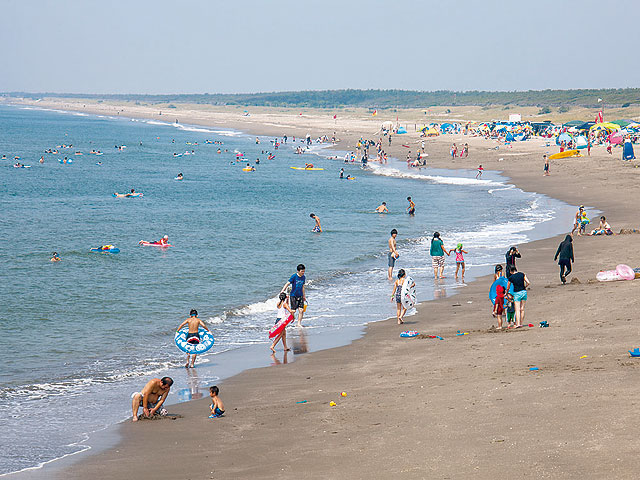

In [30]:
IMG_PATH = "./data/image_samples/sea.jpg"
display_jpeg(Image(IMG_PATH))

In [12]:
# Extract image features using ImageNet model(MobileNet)
img_feature = get_image_features(imagenet, IMG_PATH)

# Match the image features and pre-processed sound features,
# then find the topK best matched sound files 
topk_indecies = get_topk_songs(img_feature, sound_features, k=3)

In [13]:
print("The best-matched sound:")
print

for i in range(3):
    print("Top #", i)
    display(Audio(mp3_files["mp3"][topk_indecies[i]]["filepath"]))

The best-matched sound:
Top # 0


Top # 1


Top # 2
